In [53]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score, \
    calinski_harabasz_score

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook

from umap import UMAP

import warnings

warnings.filterwarnings("ignore")

RAND = 10

In [5]:
df = pd.read_csv('../data/df_labels_EDA.csv')

In [6]:
df

name  Принимает_у_себя  Выезд_к_клиенту  \
0                         Emil Mekhriev                 1                1   
1               Ирина Юрьевна Попенкова                 0                0   
2           Александр Юрьевич Иванченко                 0                0   
3             Максим Станиславович Юдин                 1                0   
4             Светлана Андреевна Орлова                 1                1   
...                                 ...               ...              ...   
1992      Наталья Григорьевна Трегубова                 1                1   
1993    Диана Александровна Гапсаламова                 0                1   
1994       Татьяна Владимировна Олийник                 1                1   
1995  Екатерина Александровна Субботина                 1                1   
1996       Дмитрий Анатольевич Микрюков                 0                0   

      Работает_удаленно  Носитель английского  стажировка в США  \
0                     1                     1                 0   
1                     1                     0                 0   
2                     1                     0                 0   
3                     1                     0                 1   
4                     1                     0                 0   
...                 ...                   ...               ...   
1992                  1                     0                 0   
1993                  1                     0                 0   
1994                  1                     0                 0   
1995                  1                     0                 0   
1996                  1                     0                 0   

      стажировка в Англии  переводчик  лингвист  подготовка_к_IELTS  ...  \
0                       0           0         0                   1  ...   
1                       0           0         1                   1  ...   
2                       0           1         0                   1  ...   
3                       0           1         1                   1  ...   
4                       0           0         0                   1  ...   
...                   ...         ...       ...                 ...  ...   
1992                    0           0         1                   0  ...   
1993                    0           0         0                   0  ...   
1994                    0           0         0                   0  ...   
1995                    0           1         1                   0  ...   
1996                    0           1         1                   0  ...   

      более_250_отзывов  менее_50_отзывов  ср_цена_1500-3500  ср_цена_<1500  \
0                     1                 0                  1              0   
1                     0                 0                  1              0   
2                     0                 0                  1              0   
3                     1                 0                  1              0   
4                     0                 0                  0              0   
...                 ...               ...                ...            ...   
1992                  0                 1                  1              0   
1993                  0                 1                  1              0   
1994                  0                 1                  0              1   
1995                  0                 1                  0              1   
1996                  0                 0                  0              1   

      ср_цена_>3500  уровень_знаний_подтверждён  нет_скидок  паспорт_проверен  \
0                 0                           1           1                 1   
1                 0                           1           1                 1   
2                 0                           1           1                 1   
3                 0                           0           0                 1   
4                 1       

In [7]:
df_cleaned = df.drop(columns=['name'])

In [8]:
def calculate_optimal_distance(list_clusters: list, list_score: list) -> float:
    """
    Поиск наибольшего расстояния для метода локтя
    :param list_clusters: количество кластеров
    :param list_score: параметры для подбора оптим кол-ва кластеров
    :return: максимальное расстояние
    """
    x1, y1 = list_clusters[0], list_score[0]
    x2, y2 = list_clusters[-1], list_score[-1]
    A, B, C = y1 - y2, x2 - x1, x1 * y2 - x2 * y1

    max_dist = -np.inf
    max_x = -np.inf
    for num, i in enumerate(list_score[1:-1]):
        x_0, y_0 = list_clusters[1:-1][num], list_score[1:-1][num]
        dist = abs(A * x_0 + B * y_0 + C) / np.sqrt(A**2 + B**2)

        if dist > max_dist:
            max_dist = dist
            max_x = x_0
        else:
            continue
    return max_dist, max_x


def elbow_picture(labels_std: list, labels_min: list, labels_max: list,
                  labels_median: list, type_optimal: list, min_size: int,
                  max_size: int) -> None:
    """
    Метод локтя
    Функция для вывода графика зависимостей стандартной ошибки, 
    минимального и максимального числа объектов от кол-ва кластеров
    :param labels_std: список значений стандартных ошибок
    :param labels_min: список мин-х значений для каждого кол-ва кластеров
    :param labels_max: список макс-х значений для каждого кол-ва кластеров
    :param labels_median: список медианных значений для каждого кол-ва кластеров
    :param type_optimal: по какому параметру подбираем оптим кол-во кластеров
    :param min_size: минимальное кол-во кластеров.
    :param max_size: максимальное кол-во кластеров.
    """

    _, opt_cluster = calculate_optimal_distance(range(min_size, max_size + 1),
                                                type_optimal)

    plt.figure(figsize=(8, 6))
    plt.plot(range(min_size, max_size + 1),
             labels_std,
             marker='s',
             color='green',
             label='std')
    plt.plot(range(min_size, max_size + 1),
             labels_min,
             marker='s',
             color='grey',
             linestyle='dashed',
             label='min')
    plt.plot(range(min_size, max_size + 1),
             labels_median,
             marker='o',
             color='skyblue',
             linestyle='dashed',
             label='median')
    plt.plot(range(min_size, max_size + 1),
             labels_max,
             marker='o',
             color='grey',
             linestyle='dashed',
             label='max')
    plt.xlabel('Кластер')
    plt.ylabel('Станд.ошибка / Мин.кластер / Median / Макс.кластер')
    plt.axvline(x=opt_cluster,
                color='black',
                label=f'optimal clust= {opt_cluster}',
                linestyle='dashed')
    plt.legend()
    plt.show()


def silhouette_plot(data: pd.DataFrame,
                    labels: pd.Series,
                    metric='euclidean',
                    ax=None) -> None:
    """
    Функция вывода графика силуэтного скора
    :param data: датасэт
    :param labels: метки кластеров
    :param metric: метрика для вычисления силуэтного скора
    :param ax: объект оси для рисования
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(7, 5)

    silhouette_vals = silhouette_samples(data, labels, metric=metric)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(range(y_lower, y_upper),
                cluster_silhouette_vals,
                edgecolor='none',
                height=1)
        ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Получение средней оценки силуэтного скора и построение графика
    avg_score = np.mean(silhouette_vals)
    ax.axvline(avg_score, linestyle='--', linewidth=1, color='red')
    ax.set_xlabel(f'Silhouette  = {round(avg_score,1)}')
    ax.set_ylabel('Метки кластеров')
    ax.set_title('График силуэта для различных кластеров', y=1.02)


def metric_picture(score_list: float,
                   min_size: int,
                   max_size: int,
                   name_metric,
                   optimal: bool = True) -> None:
    """
    Функция для вывода графика зависимости метрики от кол-ва кластеров
    :param score_list: значения метрики для каждого кол-ва кластеров
    :param min_size: минимальное кол-во кластеров
    :param max_size: Максимальное кол-во кластеров
    :param name_metric: название метрики
    :param optimal: отображение оптимального количества кластеров
    """
    plt.figure(figsize=(8, 6))
    if optimal:
        _, opt_cluster = calculate_optimal_distance(range(
            min_size, max_size + 1),
                                                    list_score=score_list)
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.axvline(x=opt_cluster,
                    color='black',
                    label=f'optimal clust= {opt_cluster}',
                    linestyle='dashed')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    else:
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    plt.show()


def check_fullness(data: pd.DataFrame, labels: pd.Series) -> None:
    """
    Функция для проверки медианной заполненности кластера
    Для бинаризованных данных
    :param data: датасэт
    :param labels: метки кластеров
    """
    sums = []
    for label in np.unique(labels):
        # Находим медианную заполненность кластера
        cluster_quantile = data[labels == label].sum(axis=0).quantile(.5)
        sums.append(cluster_quantile)
    pd.DataFrame(sums).sort_values(by=[0]).plot(kind="barh", figsize=(8, 6))
    plt.title('Заполненность кластеров')
    plt.ylabel('clusters')
    plt.show()


def plot_size(data: pd.DataFrame, labels: pd.Series) -> None:
    """
    Фунция для вывода графика размера кластеров
    :param data: датасэт
    :param labels: метки кластеров.
    """
    plt.title('Размер кластеров')
    cluster_size = data.assign(
        cluster=labels).groupby('cluster').count().iloc[:, 0]
    cluster_size.sort_values().plot.barh(figsize=(6, 4), color='C0')
    plt.show()


def plot_top_features(data, labels, n_clusters) -> None:
    """
    ТОП признаков для бинаризованных данных
    :param data: датасэт
    :param labels: метки кластеров
    :param n_clusters: количество кластеров
    """
    binary_label = data.assign(cluster=labels)
    size_cluster = binary_label.groupby('cluster').count().iloc[:, 0]
    data_sum = binary_label.groupby('cluster').sum()
    data_sum_norm = data_sum.T / size_cluster

    fig, ax_lst = plt.subplots(n_clusters, 1, figsize=(6, n_clusters * 5))
    plt.subplots_adjust(wspace=0.8, hspace=0.3)
    for i in range(n_clusters):
        ax_lst.reshape(-1)[i].set_title('cluster = ' + str(i))
        data_sum_norm.loc[:, i].sort_values()[-10:].plot.barh(
            ax=ax_lst.reshape(-1)[i], color='C0')
    plt.show()

# UMAP

In [9]:
um = UMAP(n_components=2, random_state=RAND)
clean_df_embedding = um.fit_transform(df_cleaned)

<Axes: >

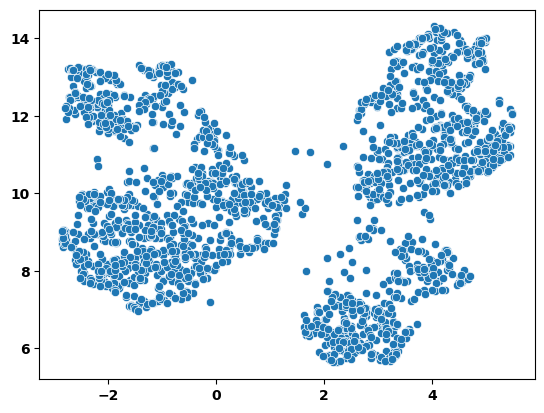

In [11]:
sns.scatterplot(x=clean_df_embedding[:, 0], y=clean_df_embedding[:, 1])

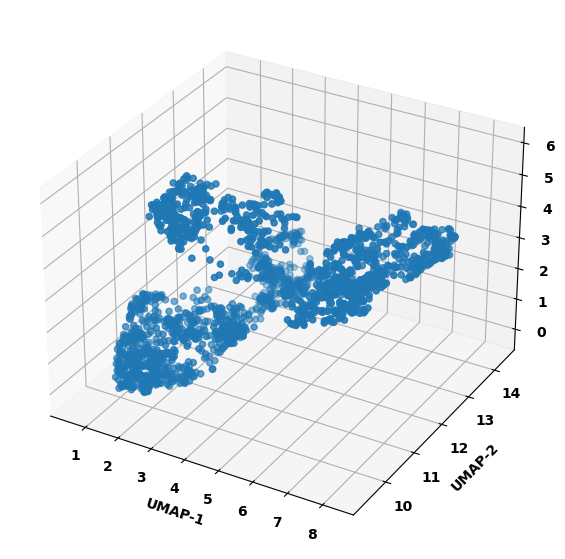

In [12]:
um3 = UMAP(n_components=3, random_state=RAND)
um3_embedding = um3.fit_transform(df_cleaned)

ax = plt.figure(figsize=(10, 7)).add_subplot(projection='3d')
ax.scatter(xs=um3_embedding[:, 0],
           ys=um3_embedding[:, 1],
           zs=um3_embedding[:, 2])
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
plt.show()

# K-means

  0%|          | 0/7 [00:00<?, ?it/s]

2 clusters
----------------------------------------------------------------------------------------------------


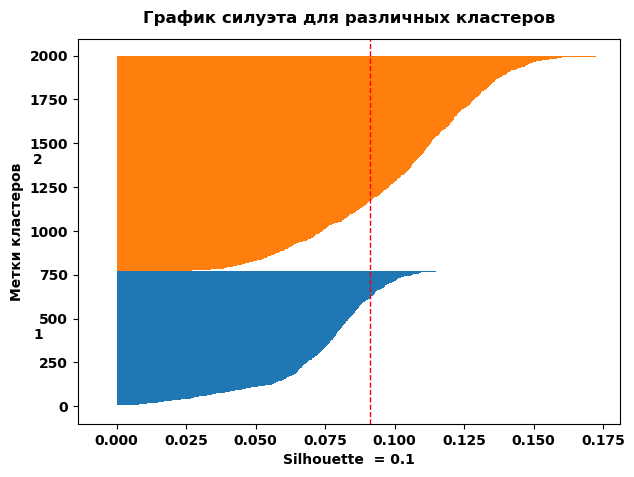

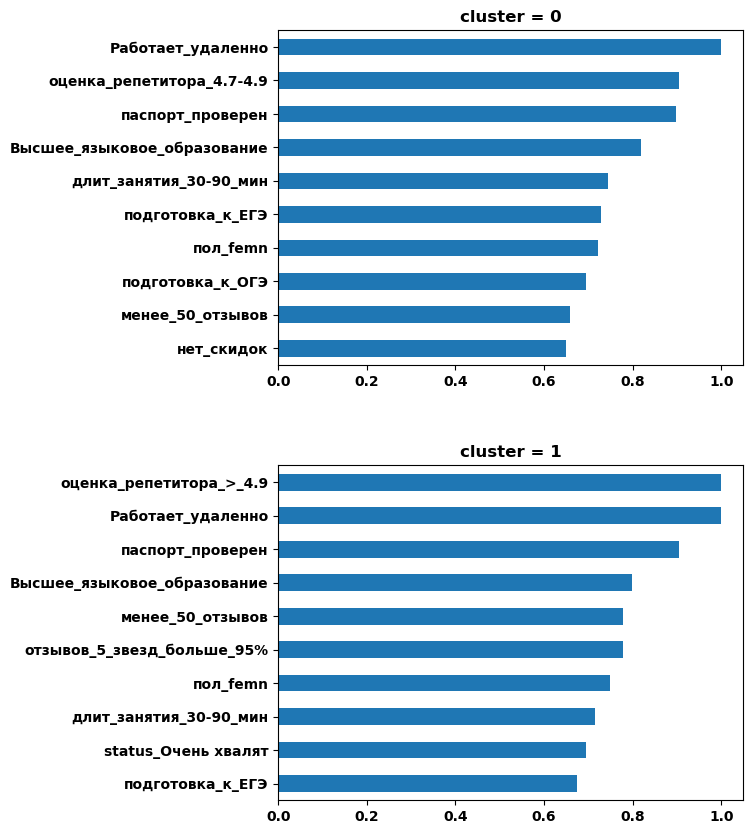

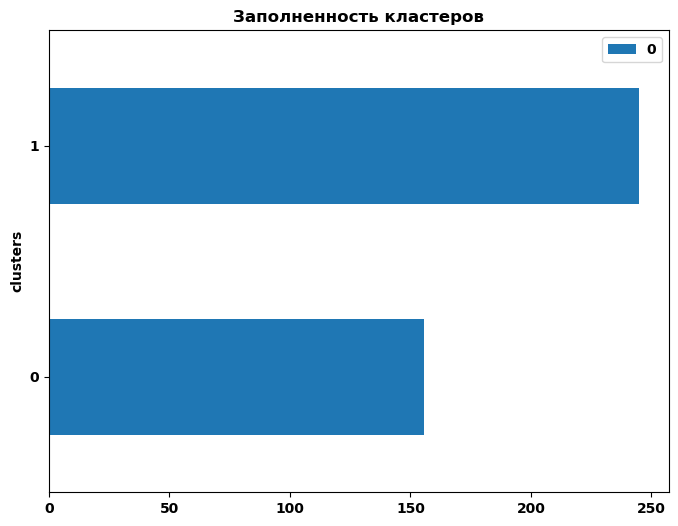

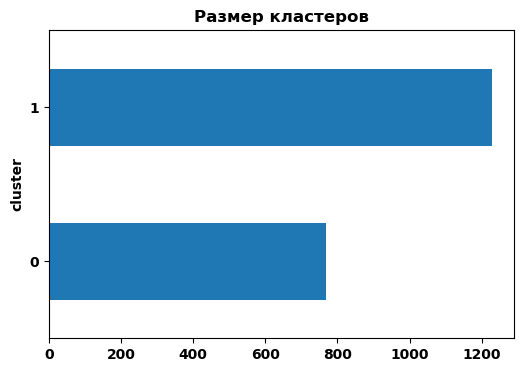

3 clusters
----------------------------------------------------------------------------------------------------


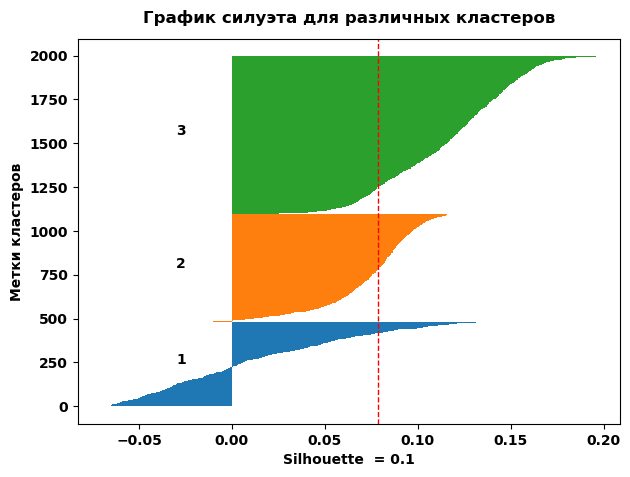

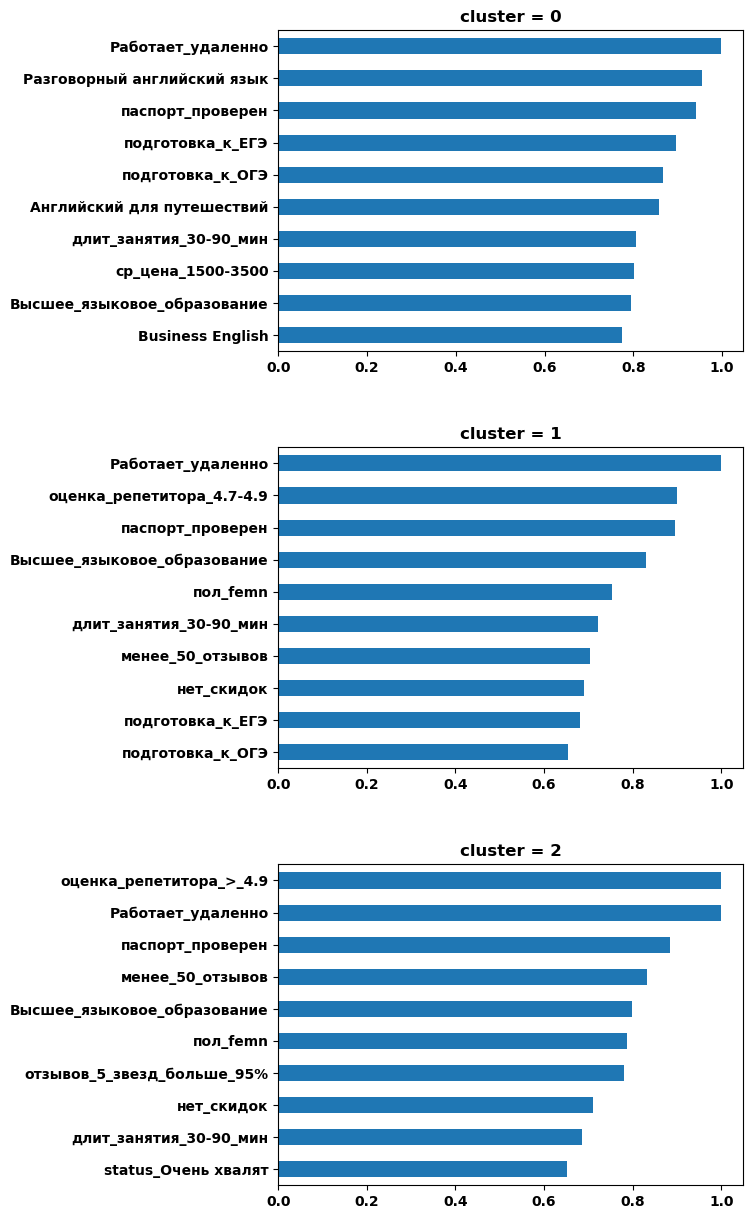

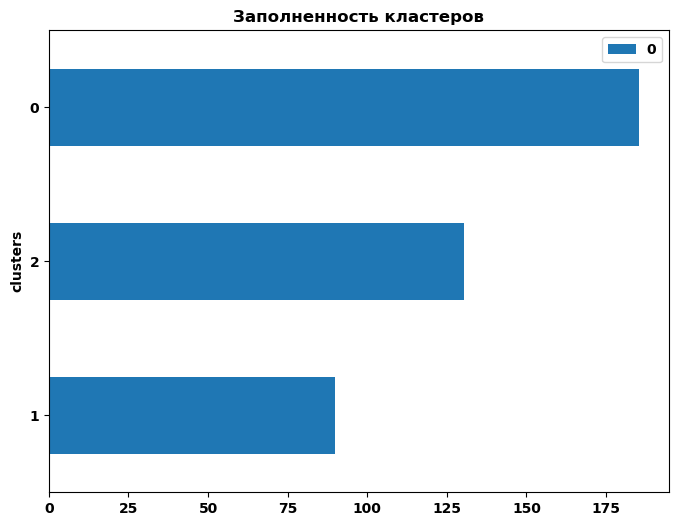

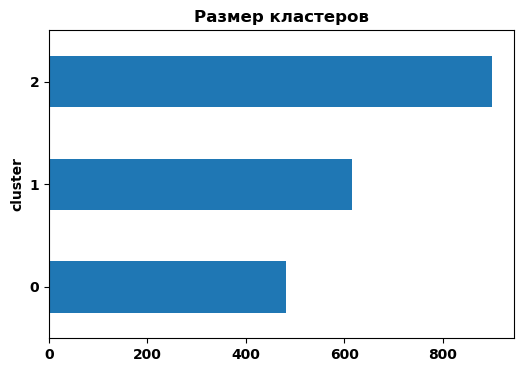

4 clusters
----------------------------------------------------------------------------------------------------


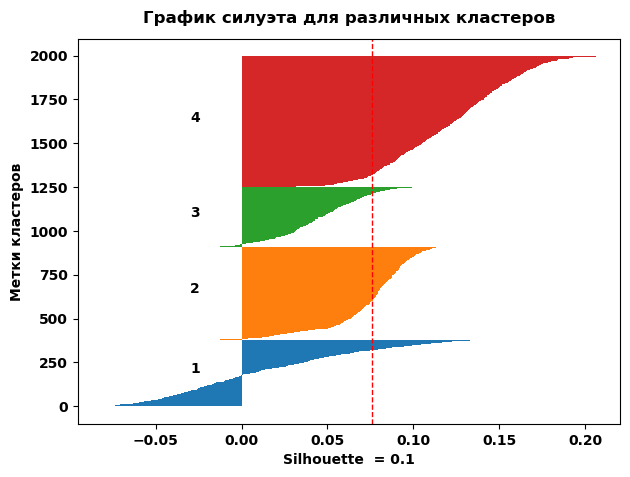

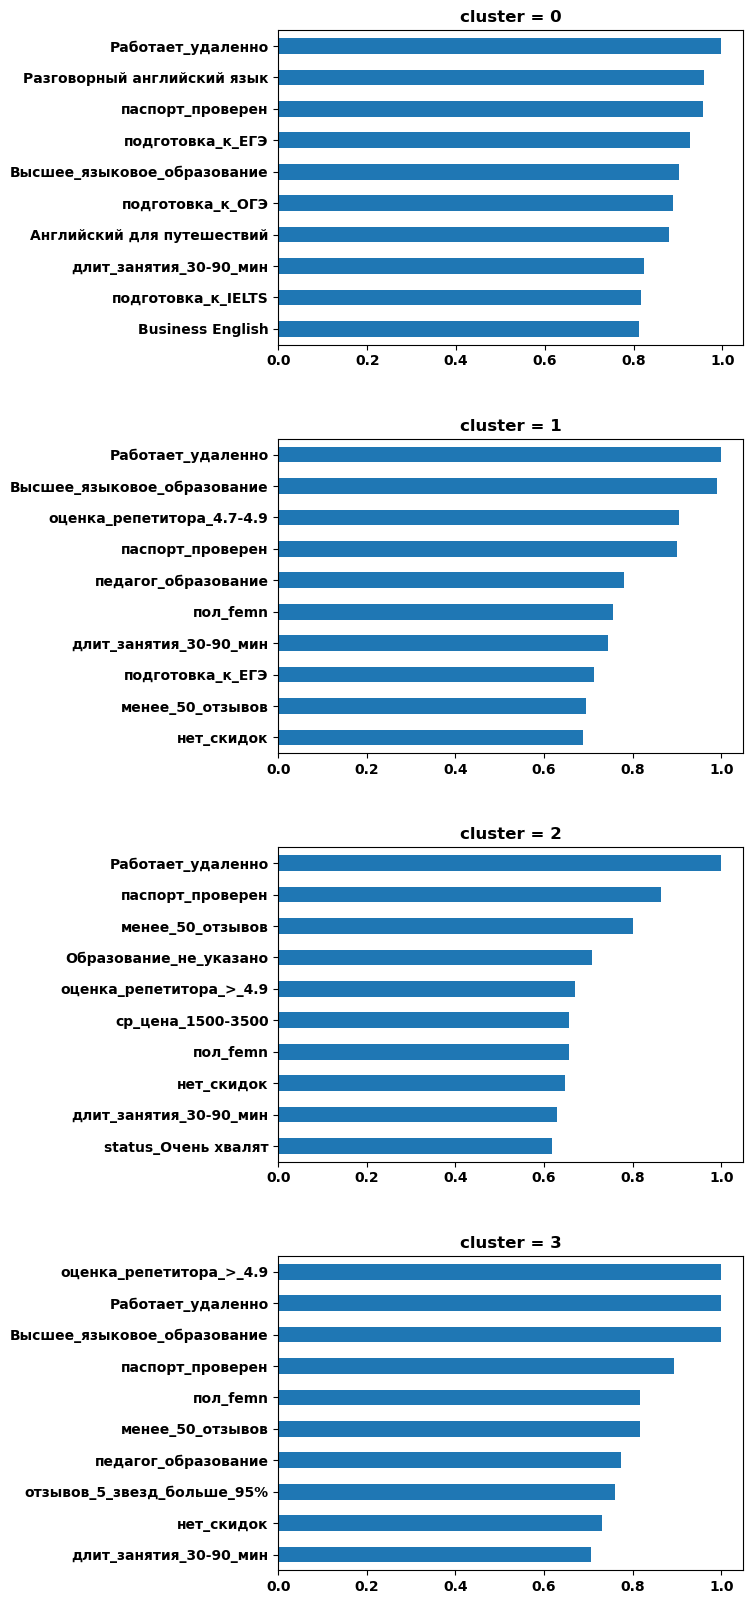

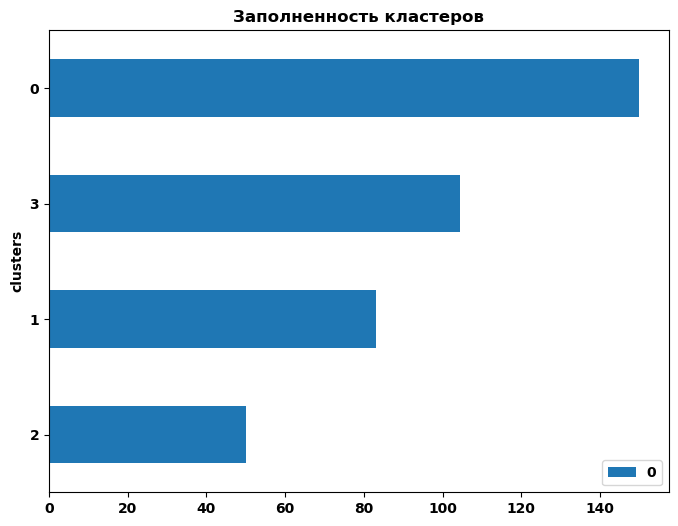

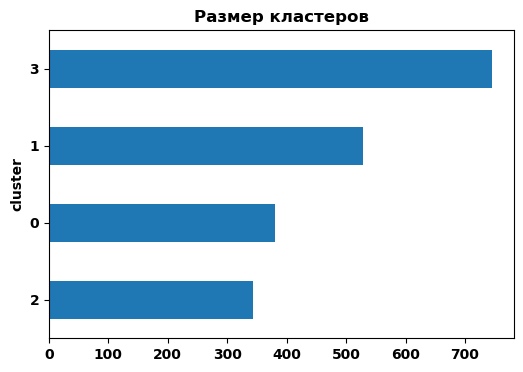

5 clusters
----------------------------------------------------------------------------------------------------


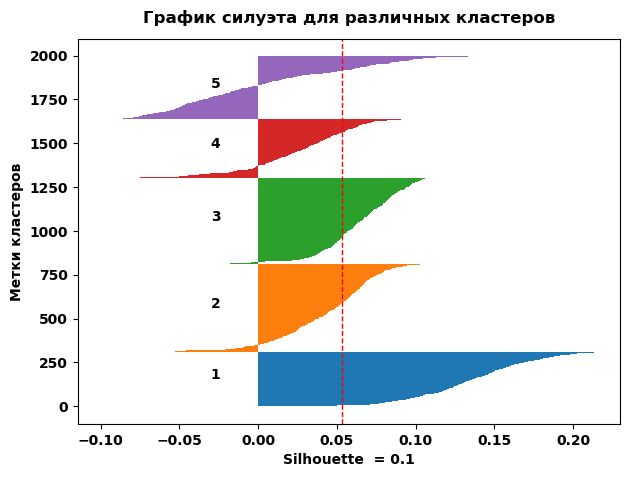

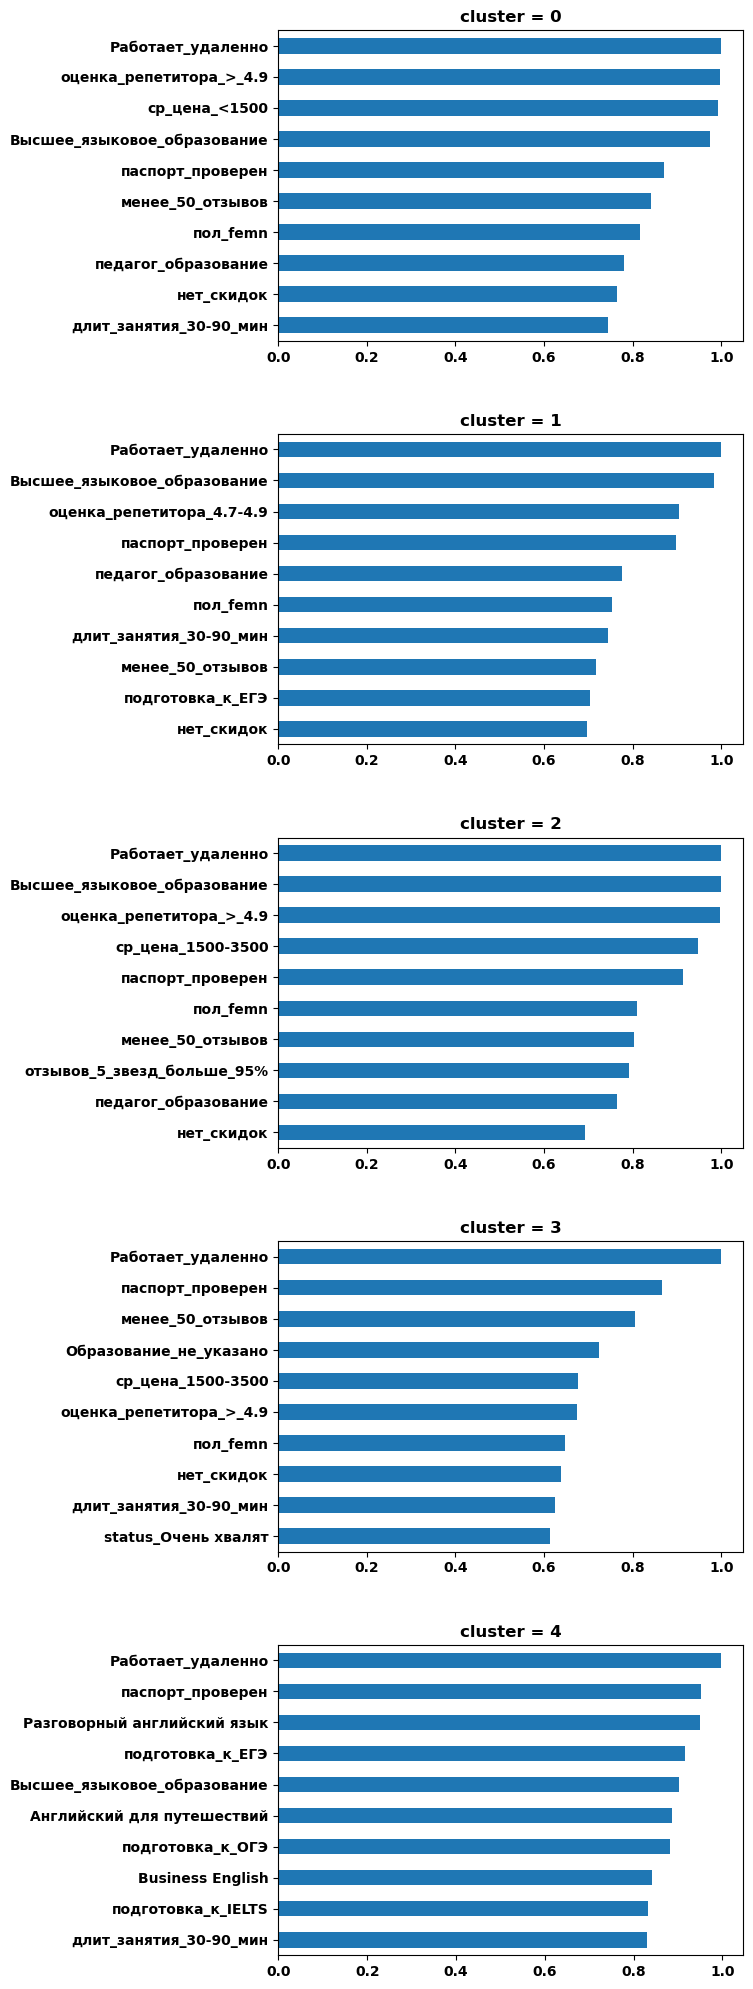

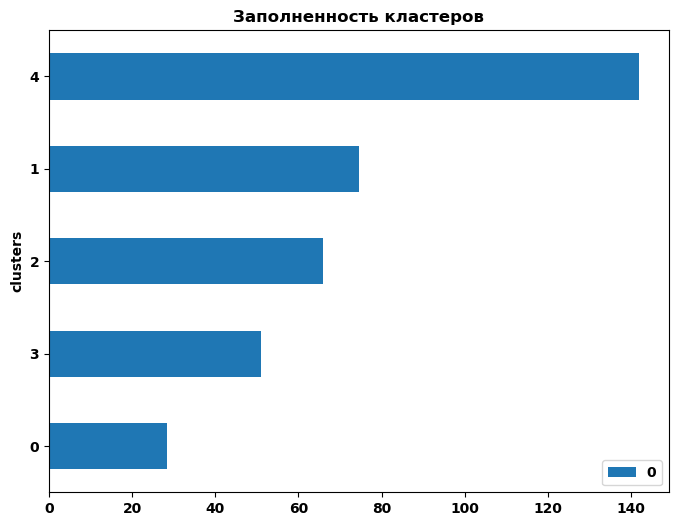

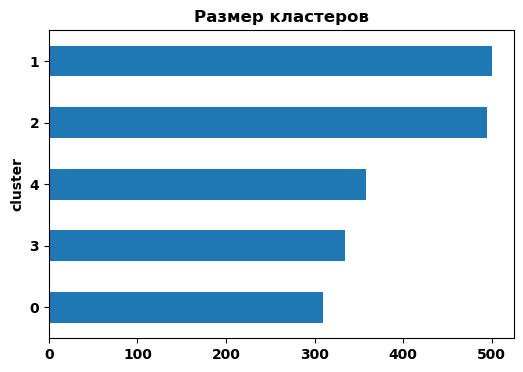

6 clusters
----------------------------------------------------------------------------------------------------


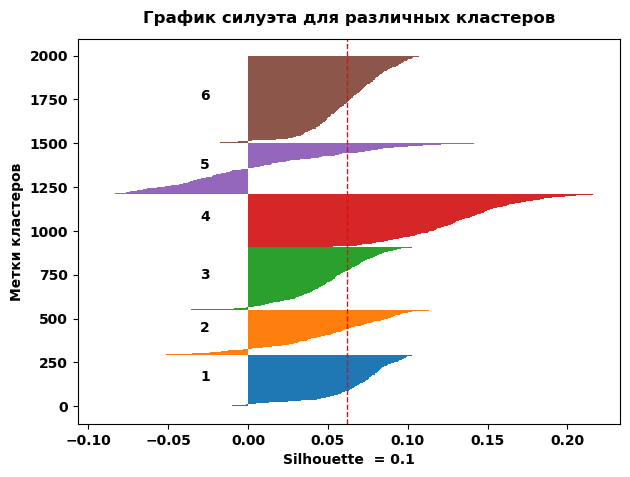

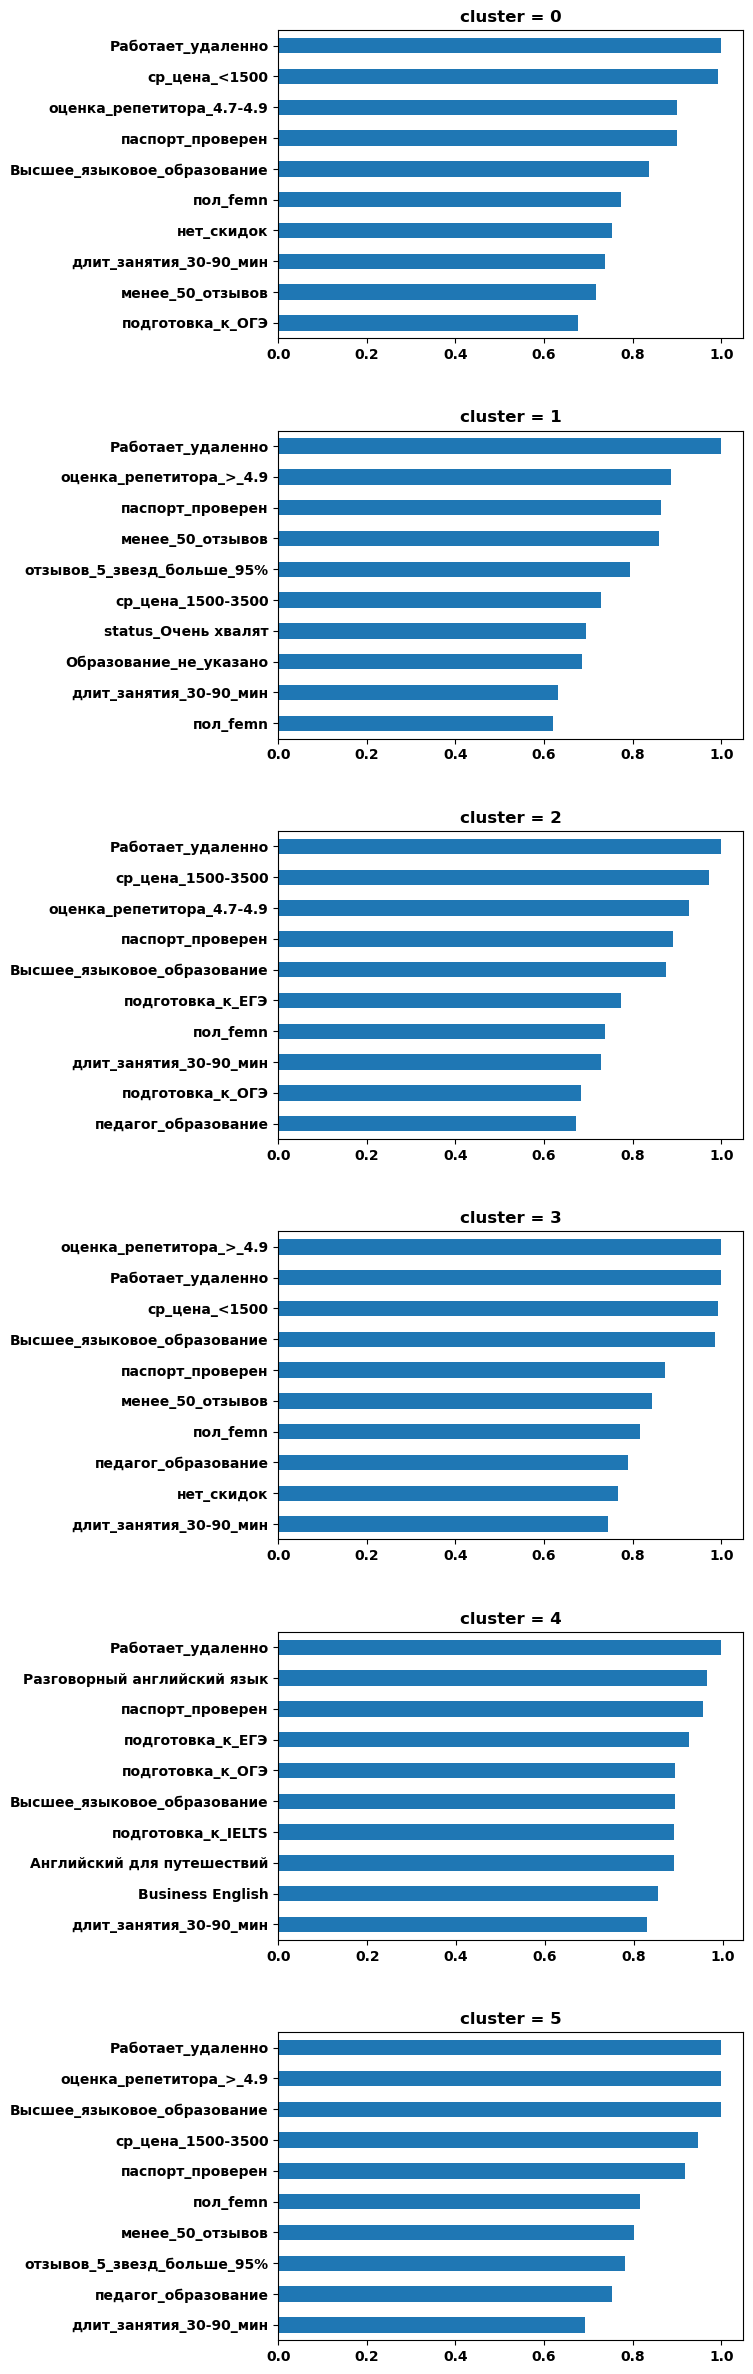

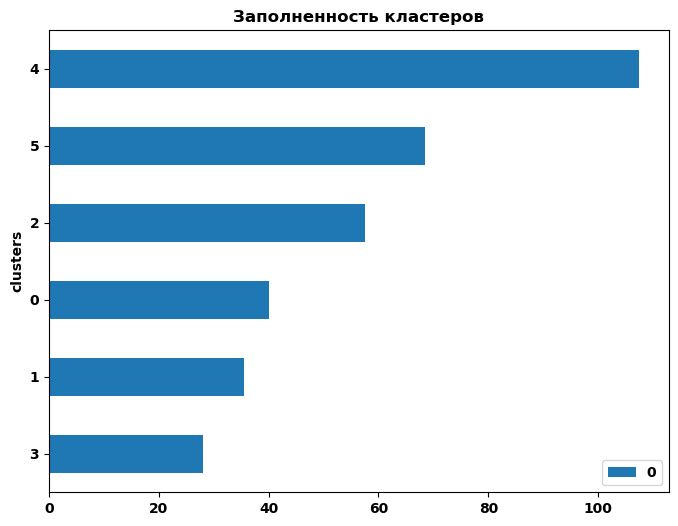

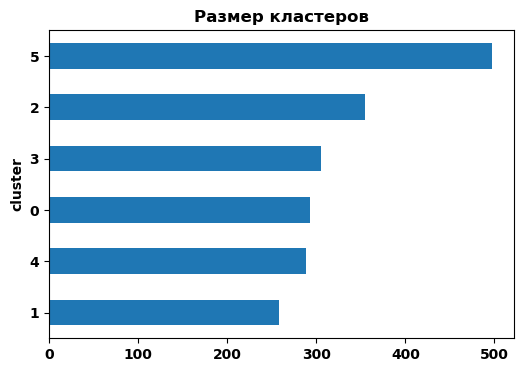

7 clusters
----------------------------------------------------------------------------------------------------


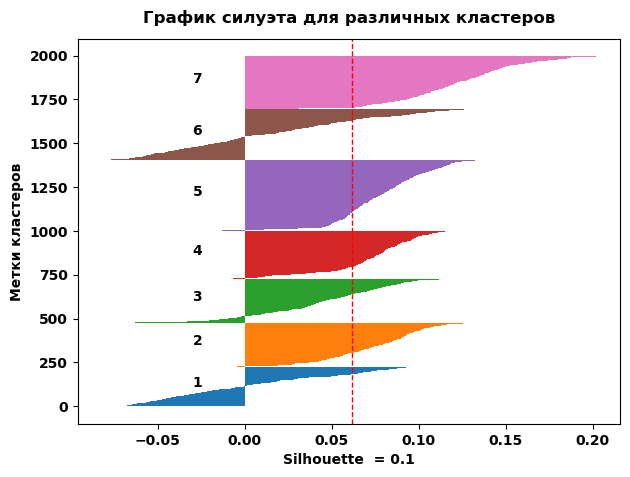

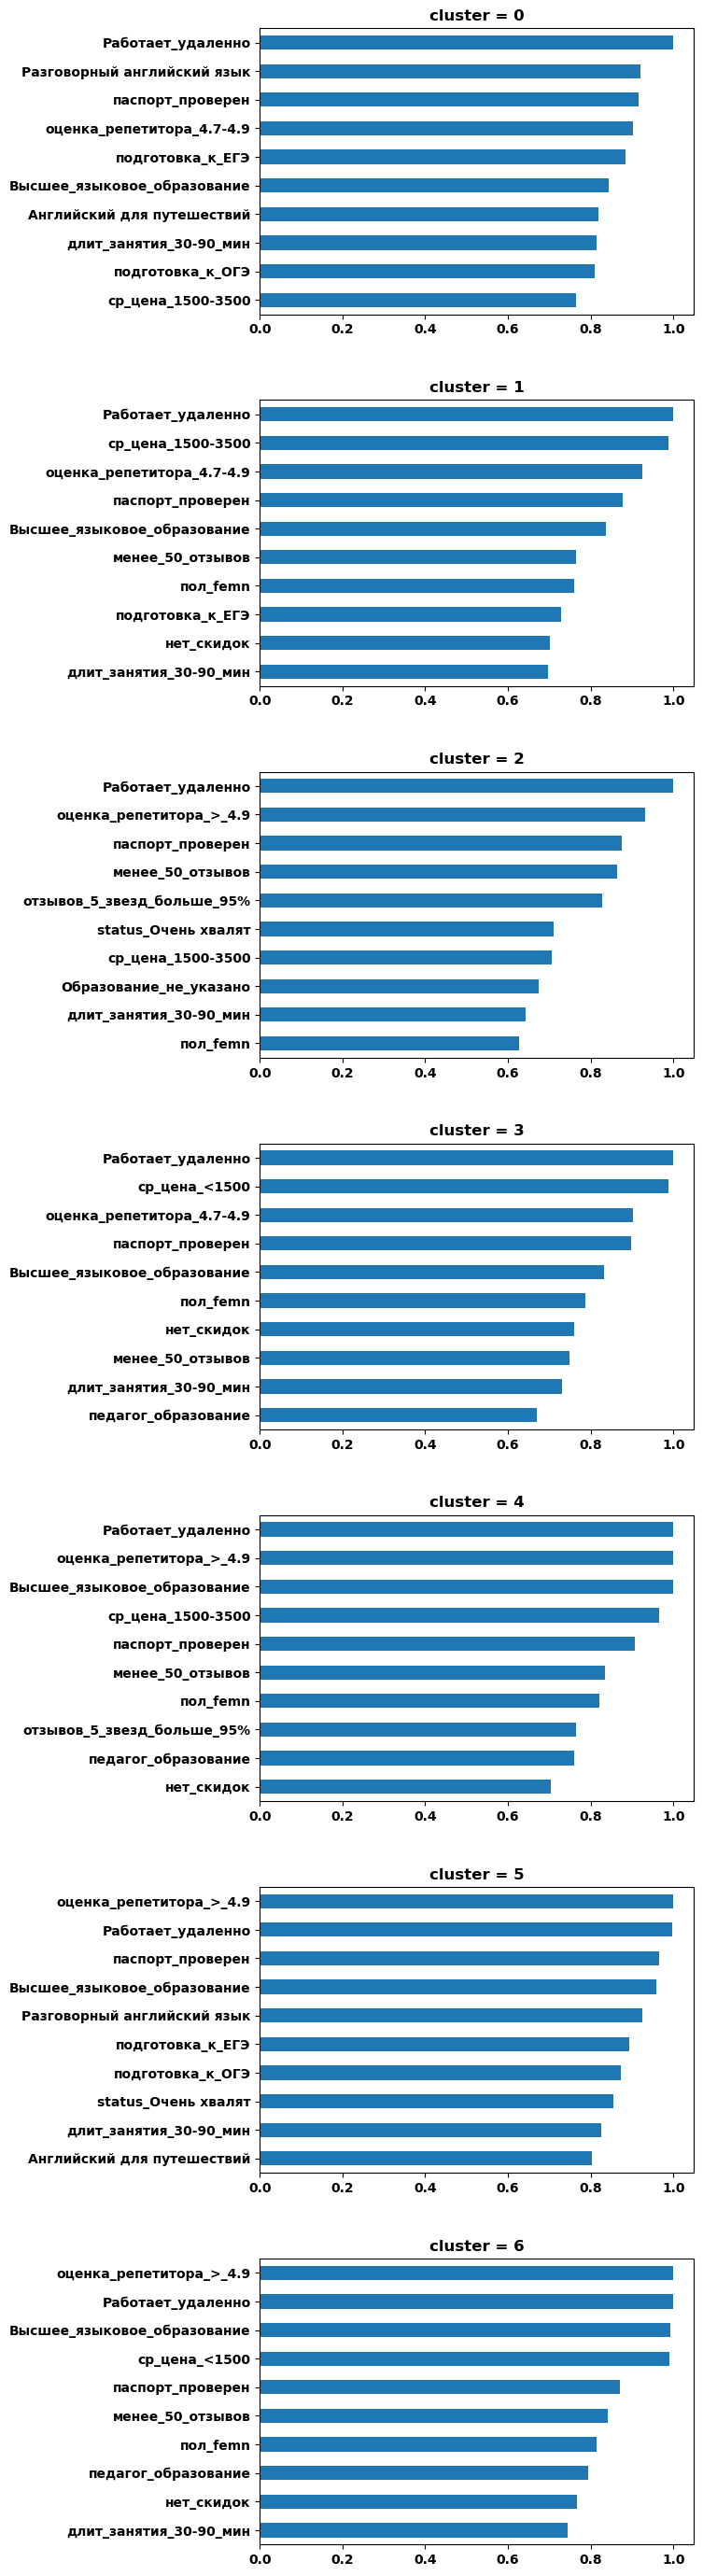

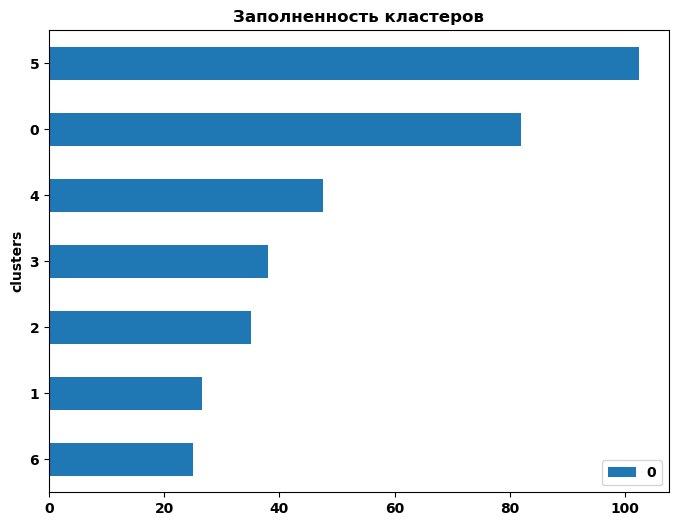

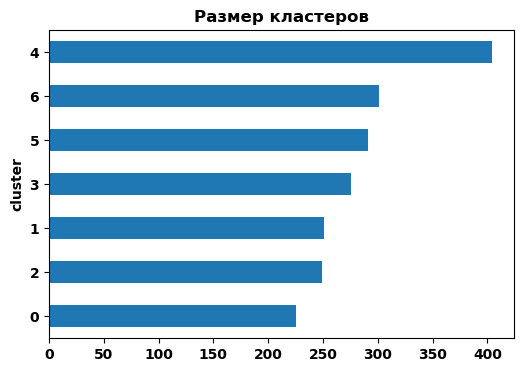

8 clusters
----------------------------------------------------------------------------------------------------


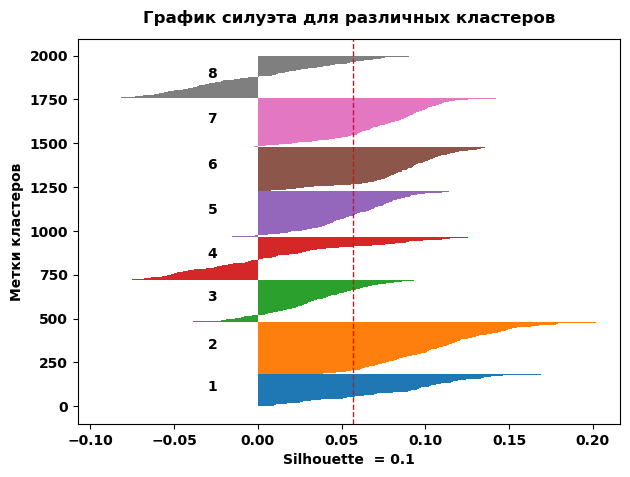

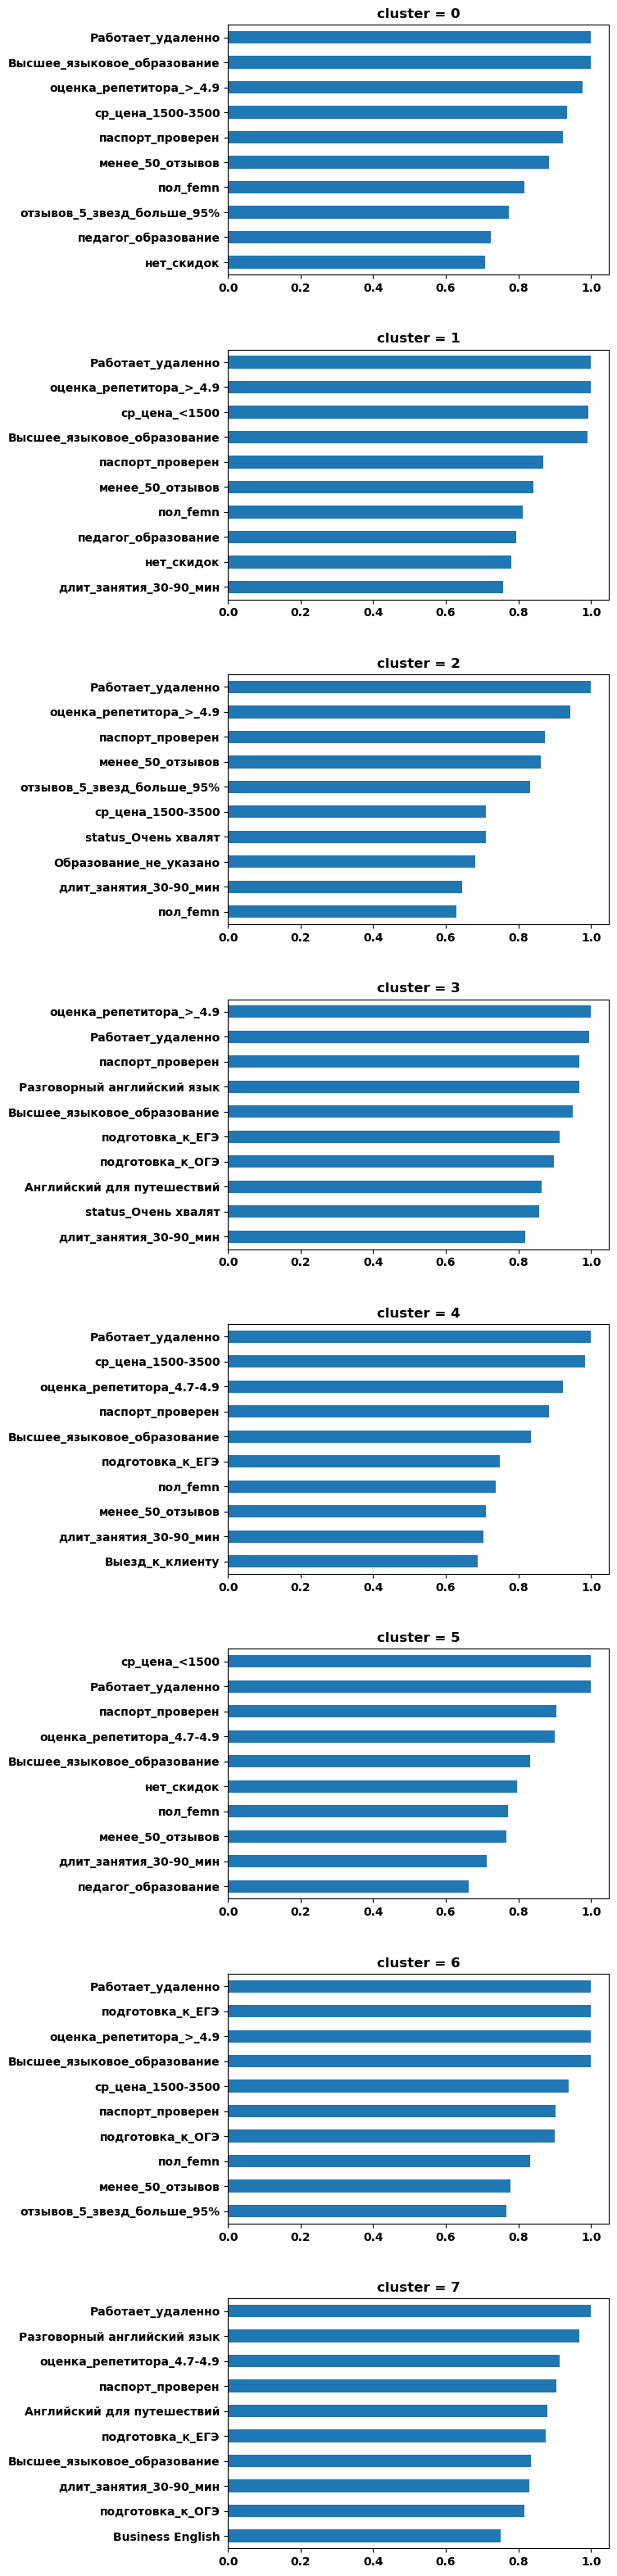

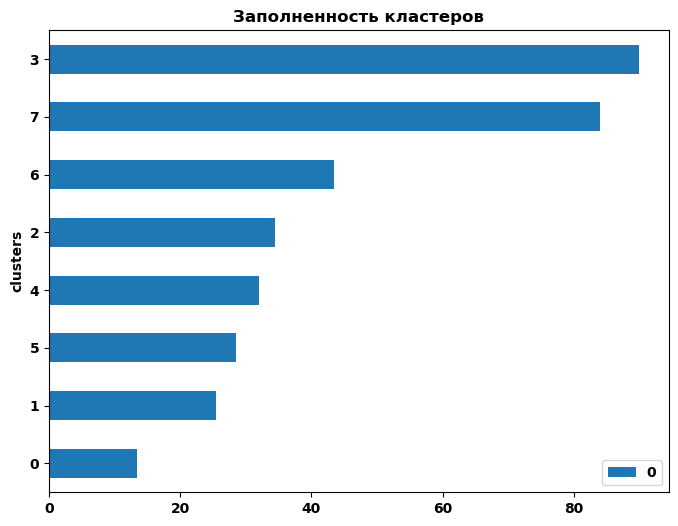

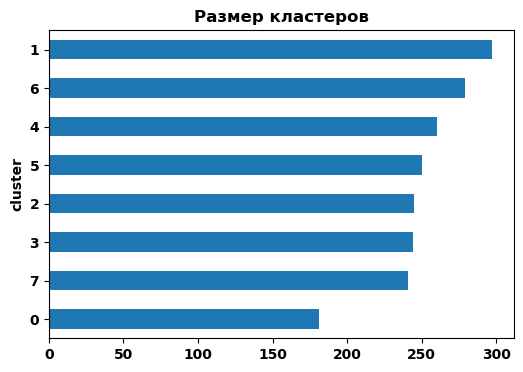

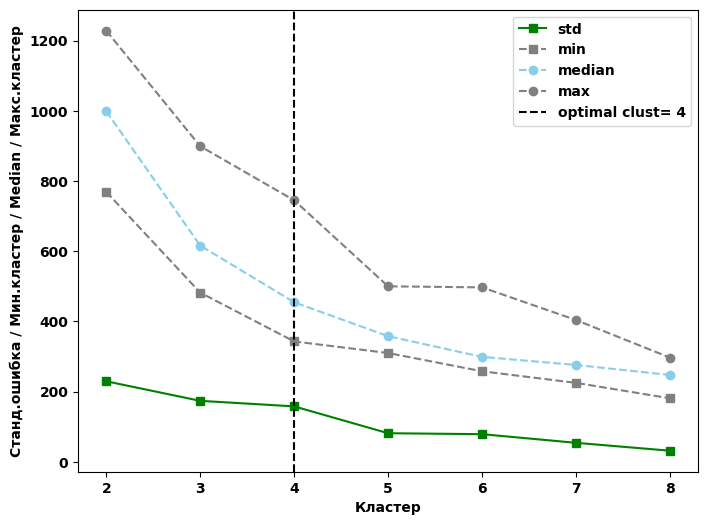

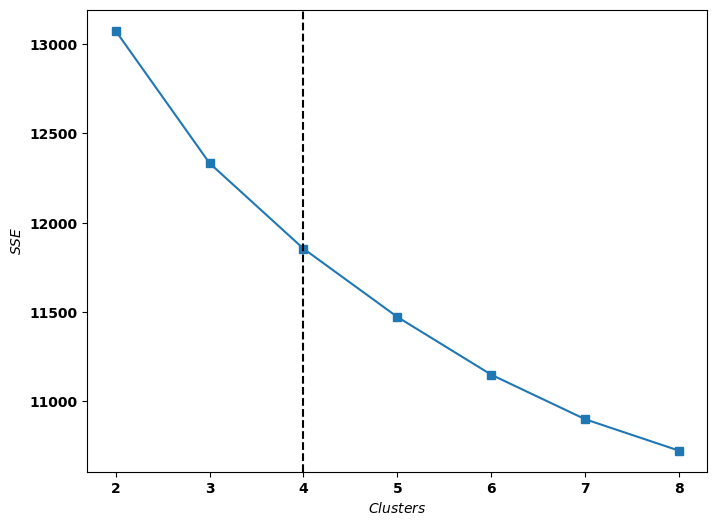

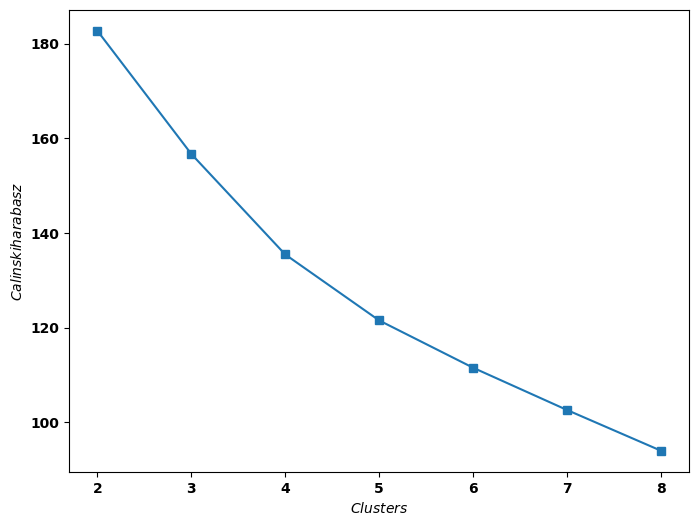

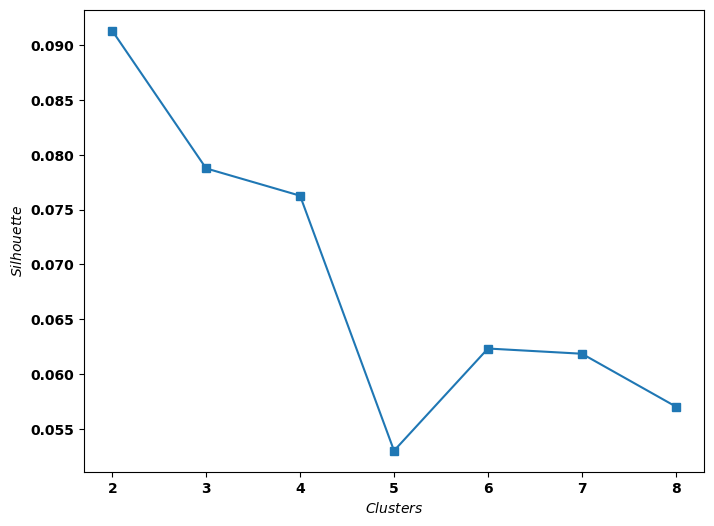

In [54]:
labels_std = []
labels_min = []
labels_max = []
labels_median = []

min_size = 2
max_size = 8

sse = []
calinski_harabasz = []
silhouette_list = []

for clust in tqdm_notebook(range(min_size, max_size + 1)):
    clf = KMeans(n_clusters=clust, random_state=RAND)
    clf.fit(df_cleaned)

    print(clust, 'clusters')
    print('-' * 100)

    silhouette_plot(df_cleaned, clf.labels_)
    # топ-признаков
    plot_top_features(df_cleaned, clf.labels_, clust)
    # медианная заполненность
    check_fullness(df_cleaned, clf.labels_)
    # размер кластеров
    plot_size(df_cleaned, clf.labels_)

    sse.append(clf.inertia_)
    calinski_harabasz.append(calinski_harabasz_score(df_cleaned, clf.labels_))
    silhouette_list.append(silhouette_score(df_cleaned, clf.labels_))

    _, counts = np.unique(clf.labels_, return_counts=True)

    labels_std.append(np.std(counts))
    labels_min.append(np.min(counts))
    labels_max.append(np.max(counts))
    labels_median.append(np.median(counts))

elbow_picture(labels_std, labels_min, labels_max, labels_median, labels_median,
              min_size, max_size)
metric_picture(sse, min_size, max_size, name_metric='SSE')
metric_picture(calinski_harabasz,
               min_size,
               max_size,
               name_metric='Calinski harabasz',
               optimal=False)
metric_picture(silhouette_list,
               min_size,
               max_size,
               name_metric='Silhouette',
               optimal=False)

In [24]:
clf_km = KMeans(n_clusters=3, random_state=RAND)
labels_km3 = clf_km.fit_predict(df_cleaned)

In [25]:
print(f'silhouette: {silhouette_score(df_cleaned, labels_km3)}')
print(f'calinski_harabasz: {calinski_harabasz_score(df_cleaned, labels_km3)}')

silhouette: 0.0787556600182026
calinski_harabasz: 156.68634018866692


In [26]:
clf_km = KMeans(n_clusters=4, random_state=RAND)
labels_km4 = clf_km.fit_predict(df_cleaned)

In [27]:
print(f'silhouette: {silhouette_score(df_cleaned, labels_km4)}')
print(f'calinski_harabasz: {calinski_harabasz_score(df_cleaned, labels_km4)}')

silhouette: 0.07626530979318887
calinski_harabasz: 135.4573946827014


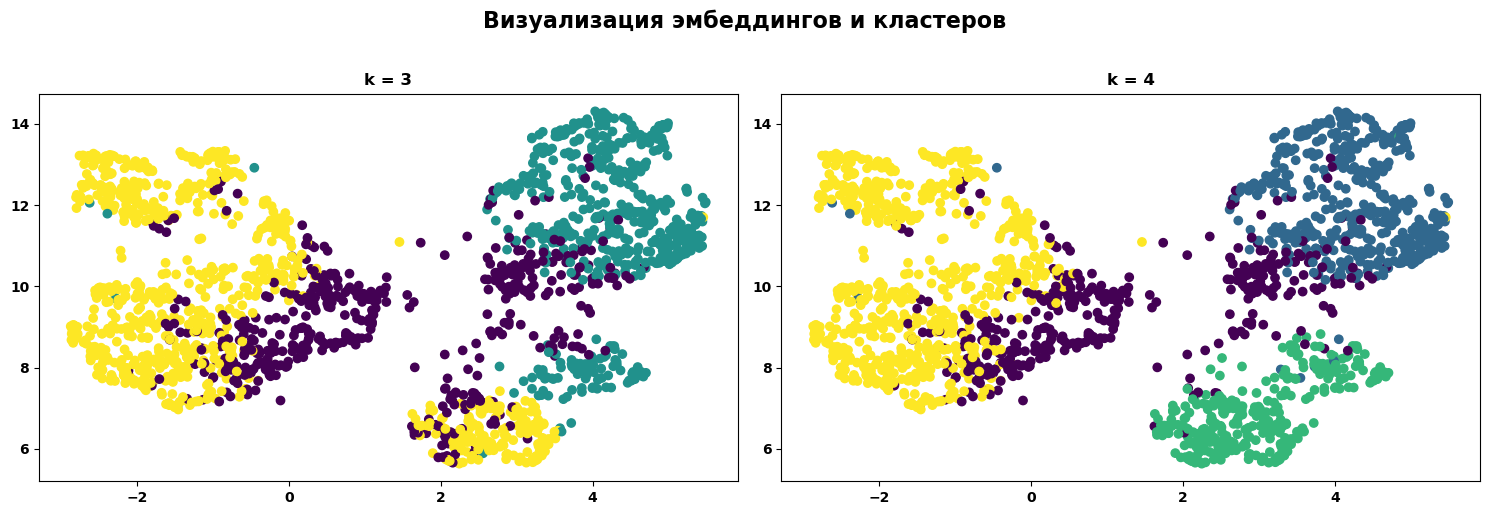

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, k in enumerate([3, 4]):
    clf_km = KMeans(n_clusters=k, random_state=RAND)
    labels_km = clf_km.fit_predict(df_cleaned)

    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels_km)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

In [28]:
km_final = df_cleaned.assign(target=labels_km3)
km_final[:4]

Принимает_у_себя  Выезд_к_клиенту  Работает_удаленно  Носитель английского  \
0                 1                1                  1                     1   
1                 0                0                  1                     0   
2                 0                0                  1                     0   
3                 1                0                  1                     0   

   стажировка в США  стажировка в Англии  переводчик  лингвист  \
0                 0                    0           0         0   
1                 0                    0           0         1   
2                 0                    0           1         0   
3                 1                    0           1         1   

   подготовка_к_IELTS  подготовка_к_IELTS_Academic  ...  менее_50_отзывов  \
0                   1                            1  ...                 0   
1                   1                            0  ...                 0   
2                   1                            0  ...                 0   
3                   1                            1  ...                 0   

   ср_цена_1500-3500  ср_цена_<1500  ср_цена_>3500  \
0                  1              0              0   
1                  1              0              0   
2                  1              0              0   
3                  1              0              0   

   уровень_знаний_подтверждён  нет_скидок  паспорт_проверен  \
0                           1           1                 1   
1                           1           1                 1   
2                           1           1                 1   
3                           0           0                 1   

   доля_плохих_отзывов_10%_и_более  отзывов_5_звезд_больше_95%  target  
0                                0                           0       0  
1                                0                           0       1  
2                                0                           1       2  
3                                0                           1       0  

[4 rows x 53 columns]

In [29]:
km_final['target'].value_counts()

target
2    899
1    616
0    482
Name: count, dtype: int64

In [30]:
count = km_final.groupby('target').count().iloc[:, :1].T.values
normalize = km_final.groupby('target').sum().T / count * 100

<Axes: xlabel='target'>

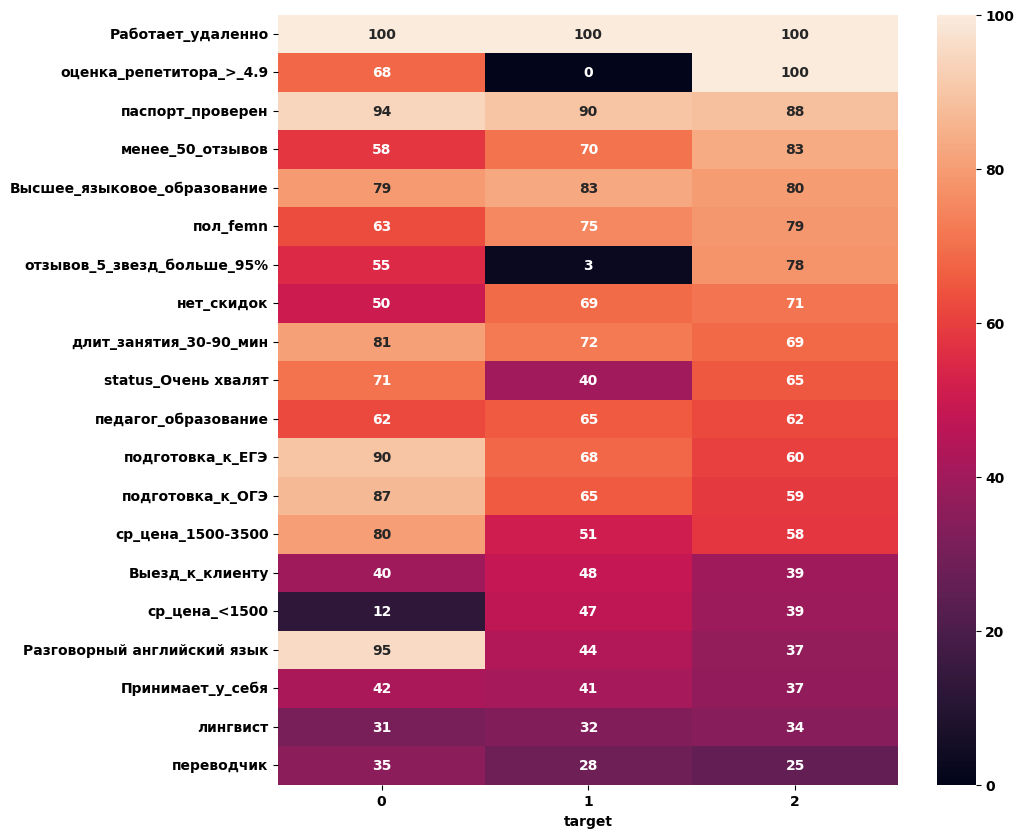

In [31]:
plt.figure(figsize=(10, 10))

sns.heatmap(normalize.sort_values(by=2, ascending=False)[:20],
            fmt='.0f',
            annot=True)

- кластер 0 - преобладают женщины (перевес небольшой), мало отзывов, зачастую очень высокие оценки, почти отсутствуют бюджетные варианты, преподают разговорный англ, ОГЭ/ЕГЭ;
- кластер 1 - в основном женщины, отсутствуют высокие оценки (>4.9), высшее языковое образ-е, большинство не делает скидок,;
- кластер 2 - большинство женщины, все имеют очень высокие оценки, мало отзывов;

# Spectral_clusterization

  0%|          | 0/7 [00:00<?, ?it/s]

2 clusters
----------------------------------------------------------------------------------------------------


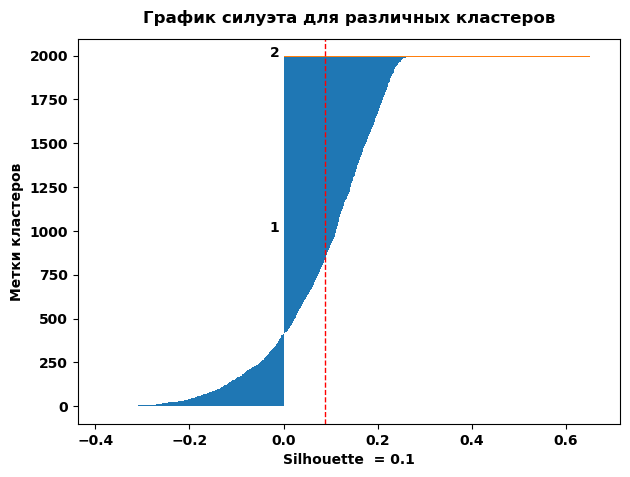

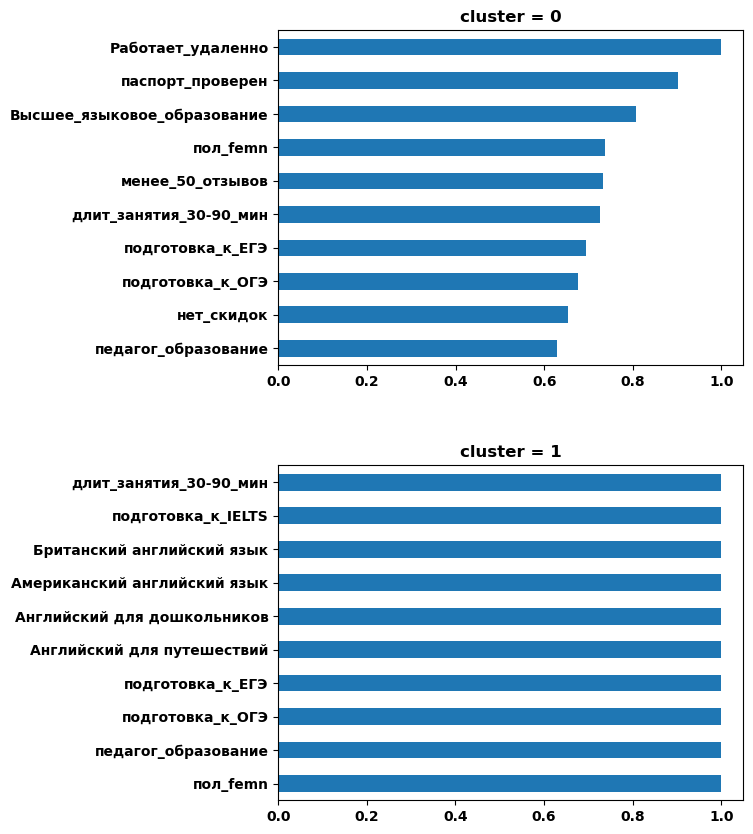

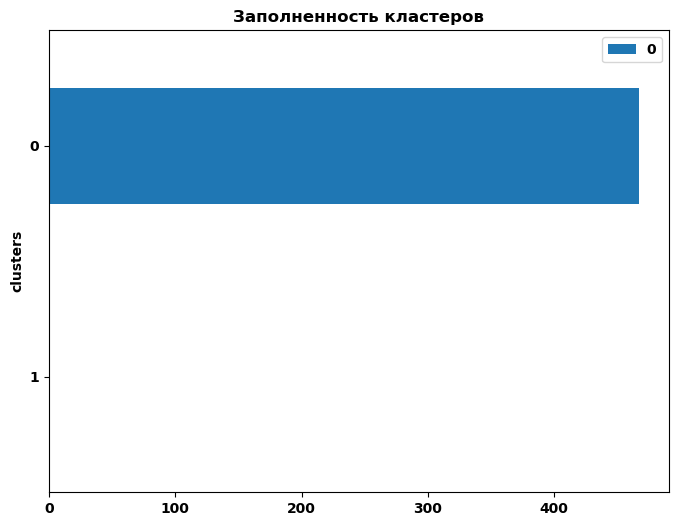

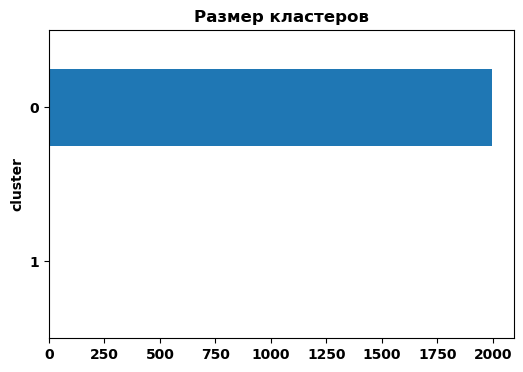

3 clusters
----------------------------------------------------------------------------------------------------


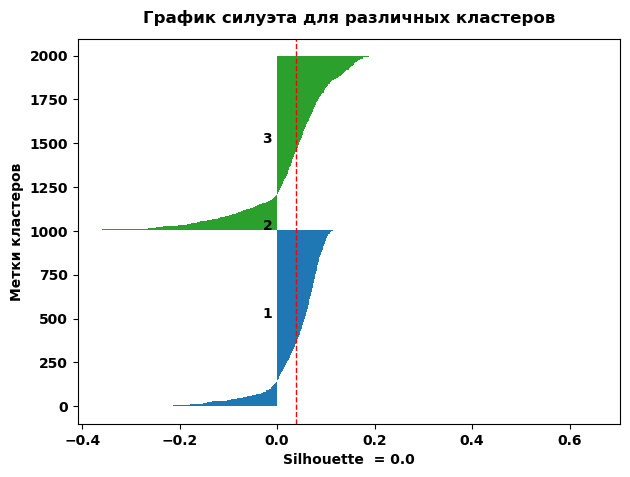

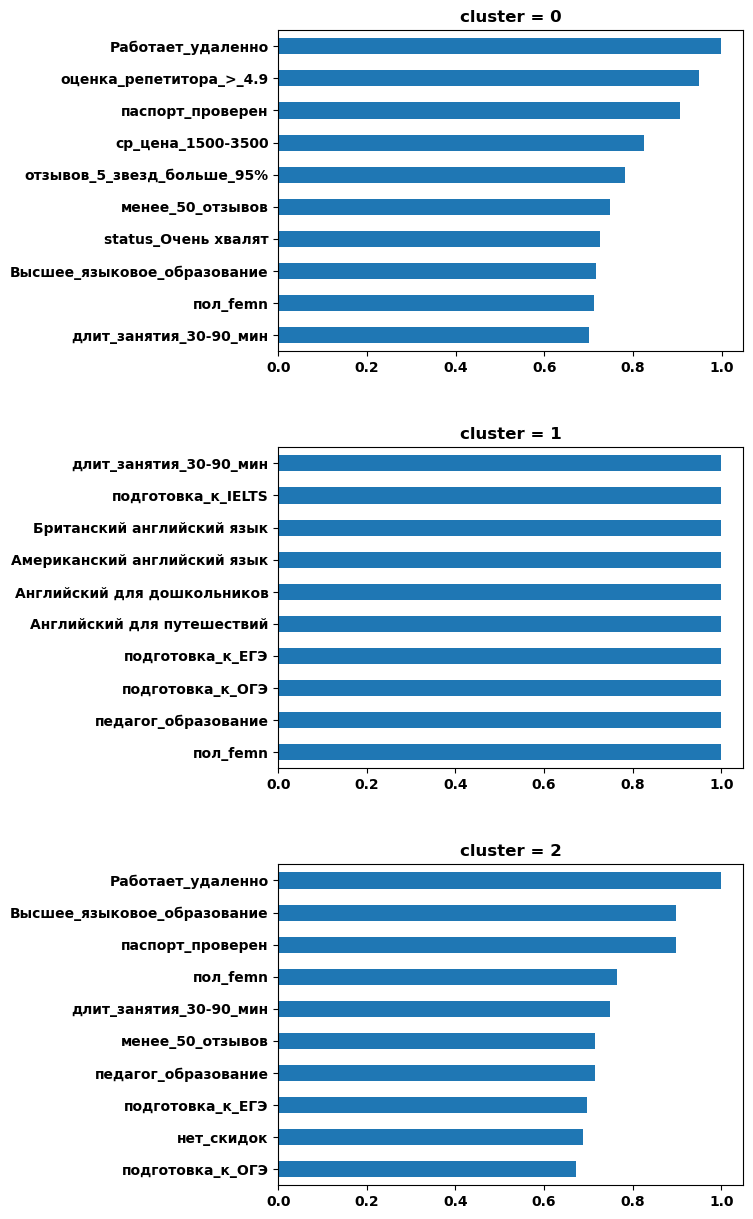

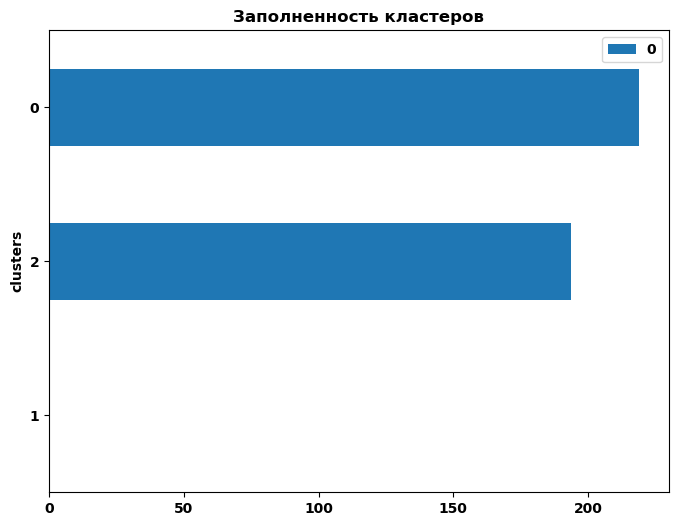

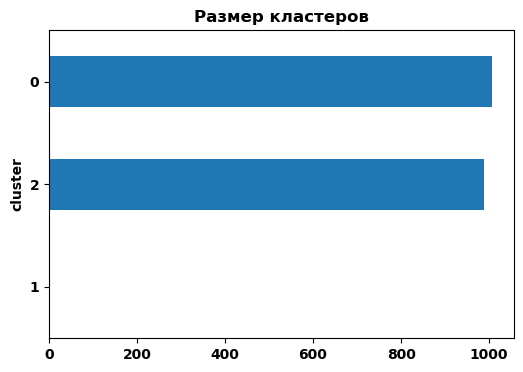

4 clusters
----------------------------------------------------------------------------------------------------


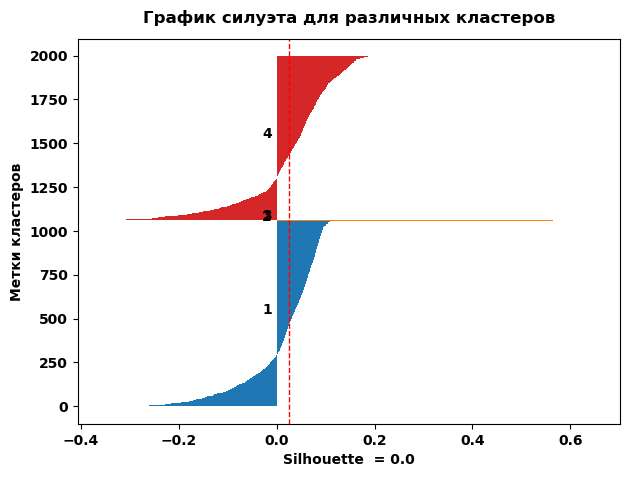

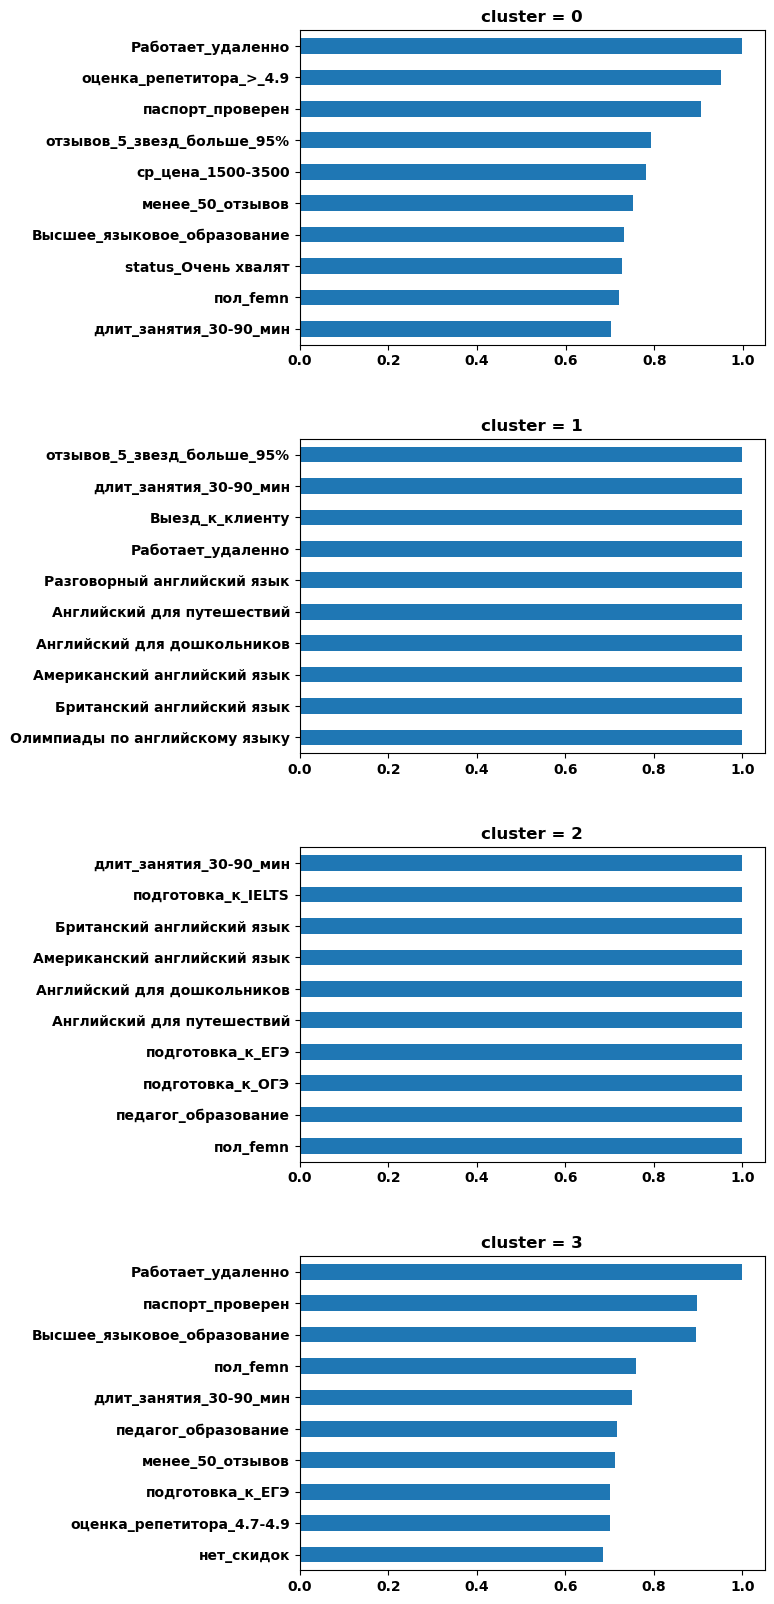

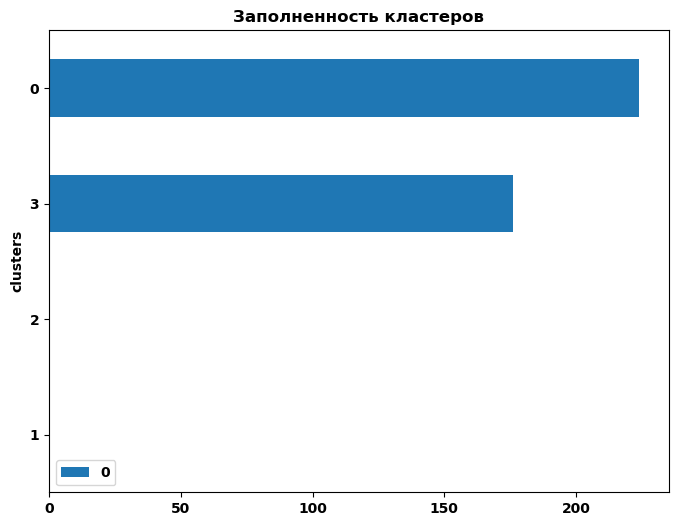

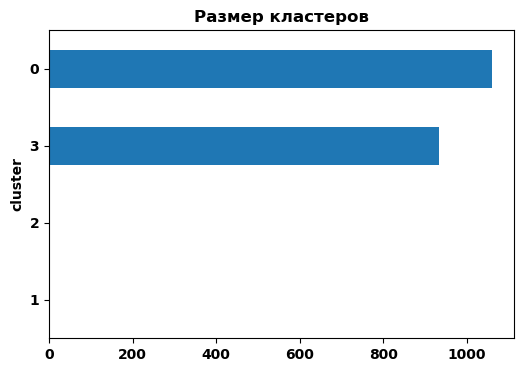

5 clusters
----------------------------------------------------------------------------------------------------


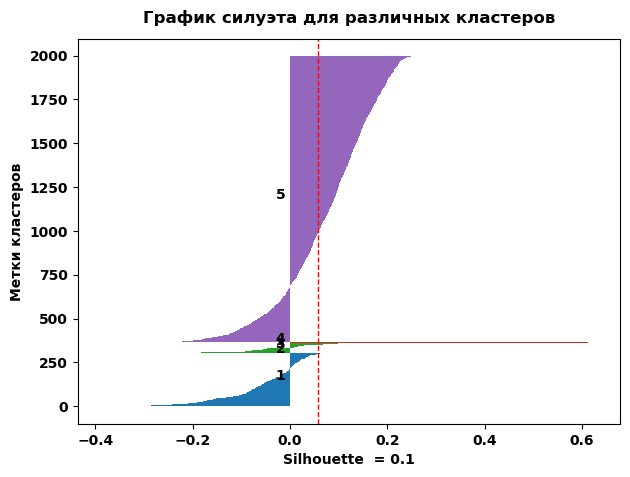

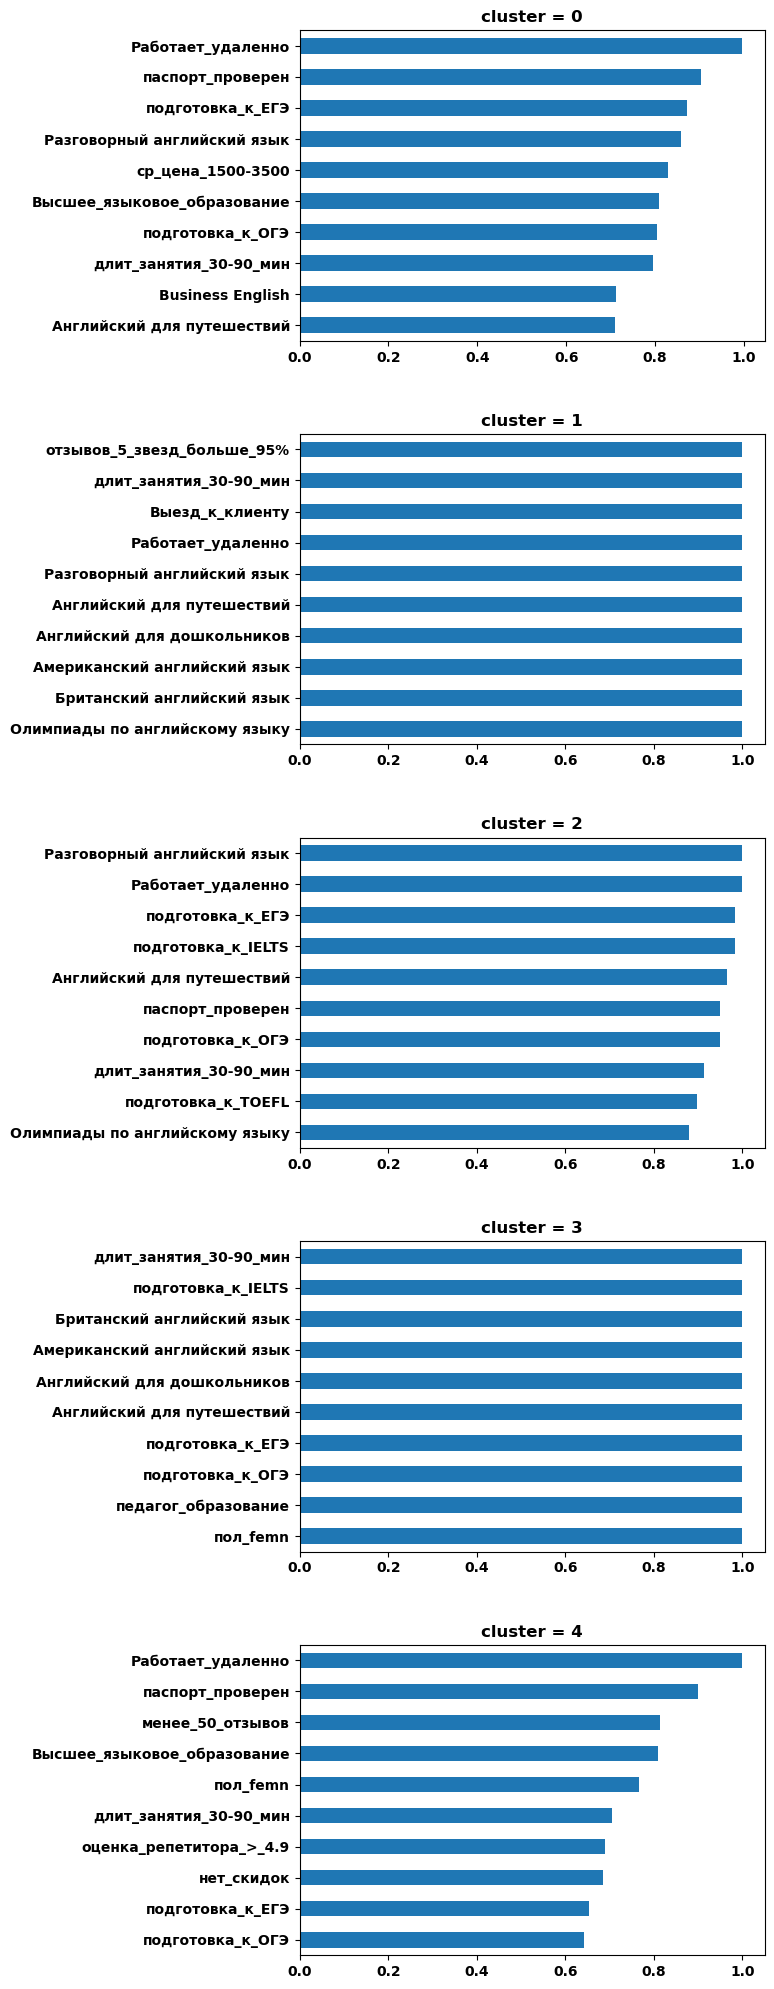

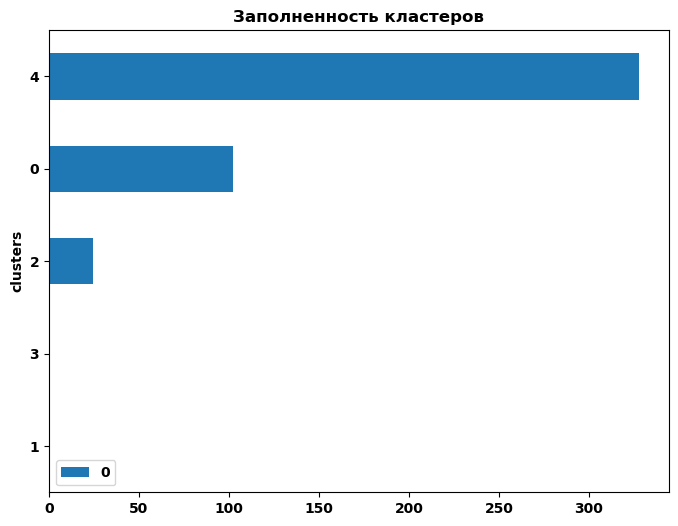

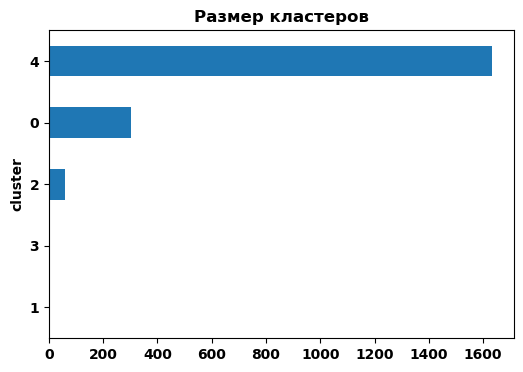

6 clusters
----------------------------------------------------------------------------------------------------


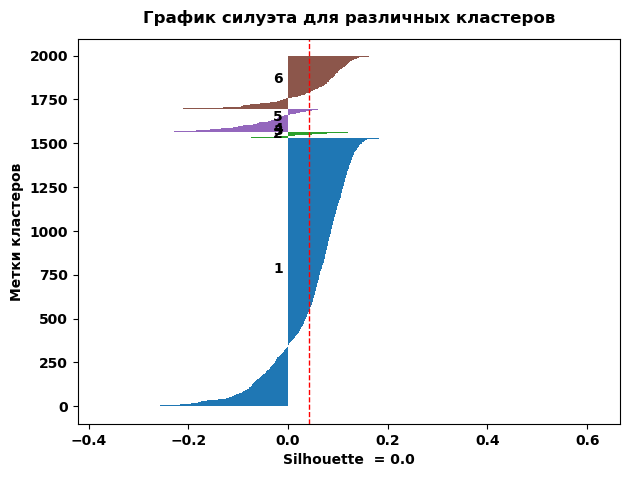

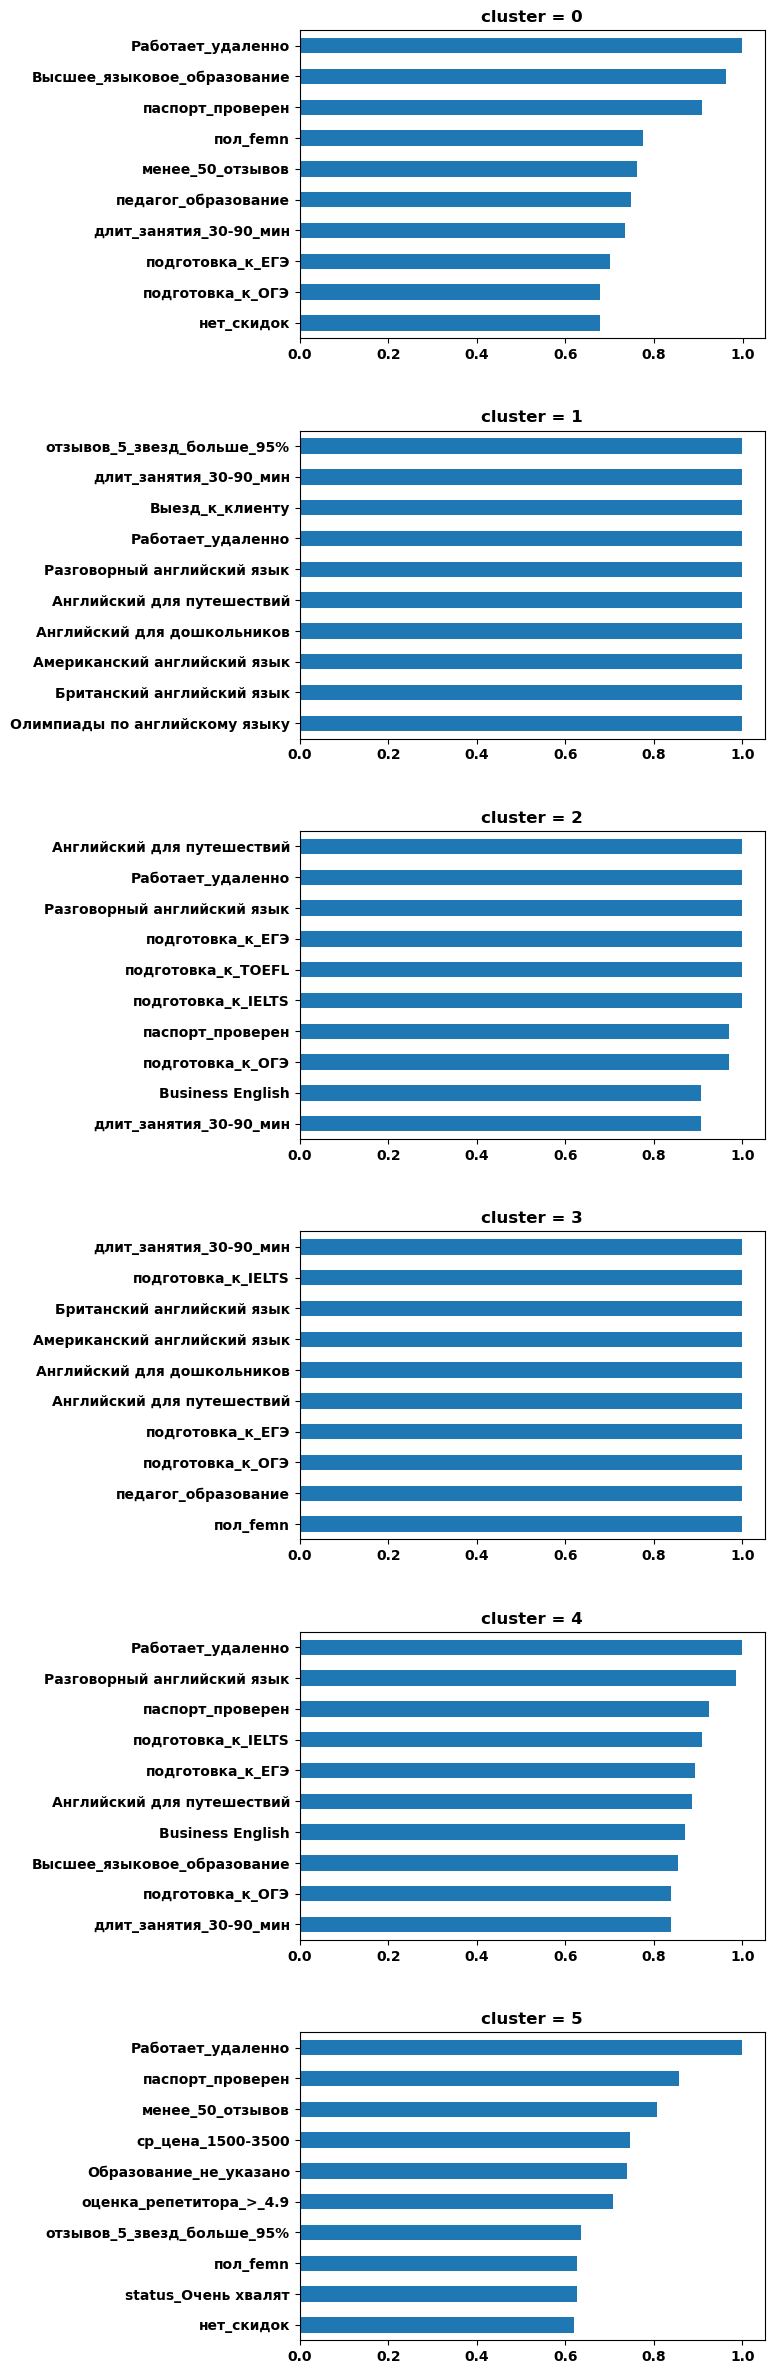

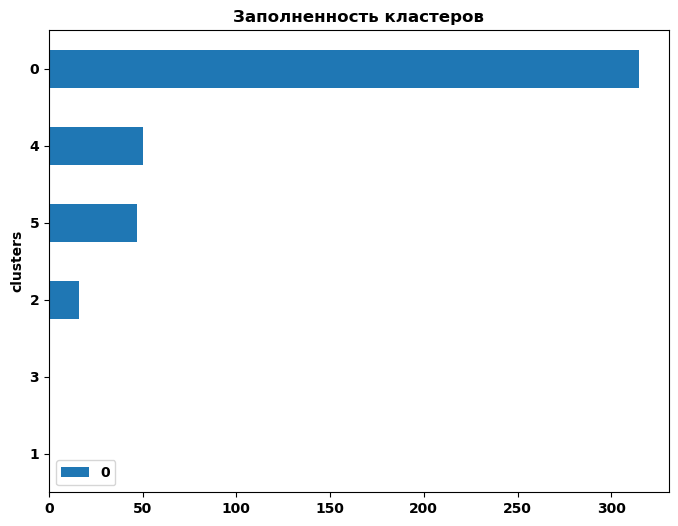

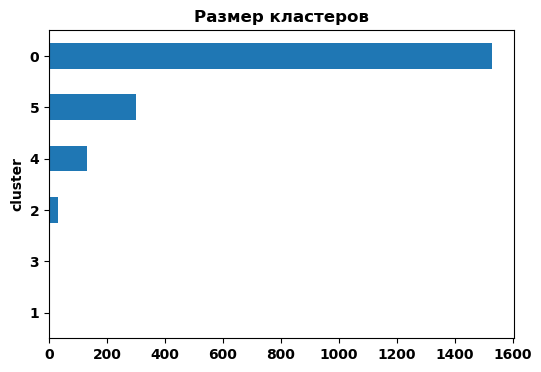

7 clusters
----------------------------------------------------------------------------------------------------


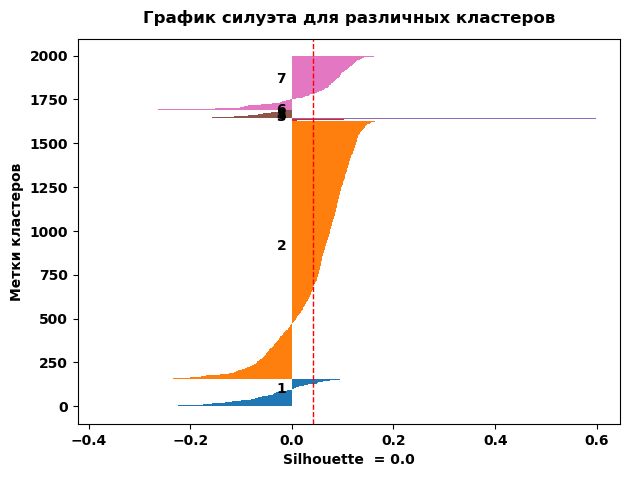

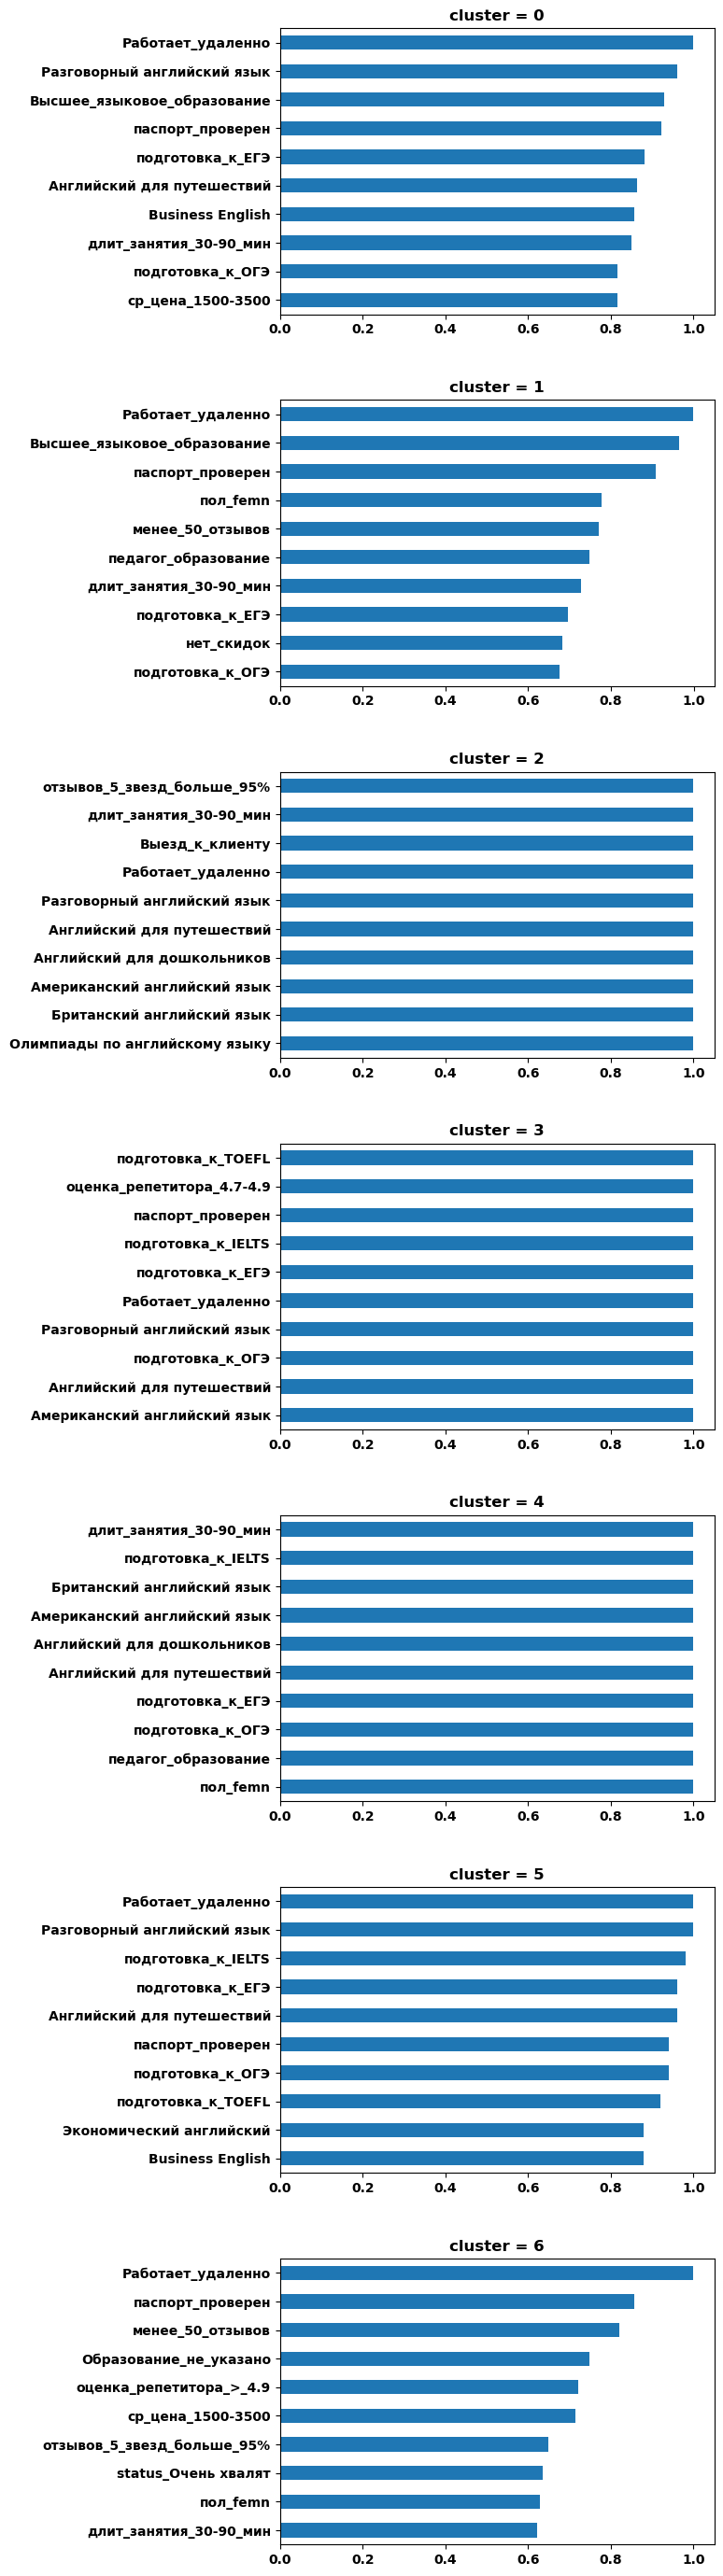

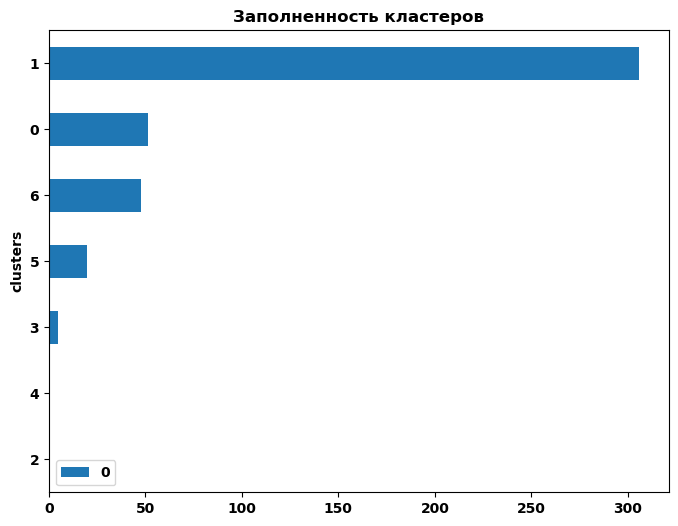

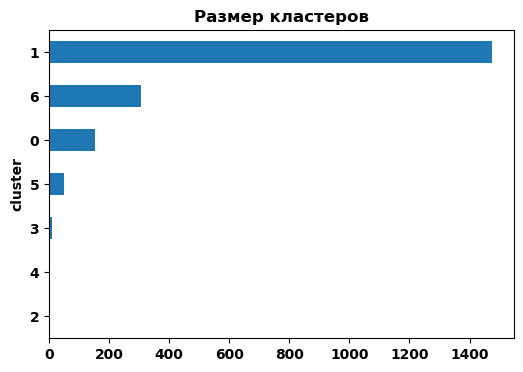

8 clusters
----------------------------------------------------------------------------------------------------


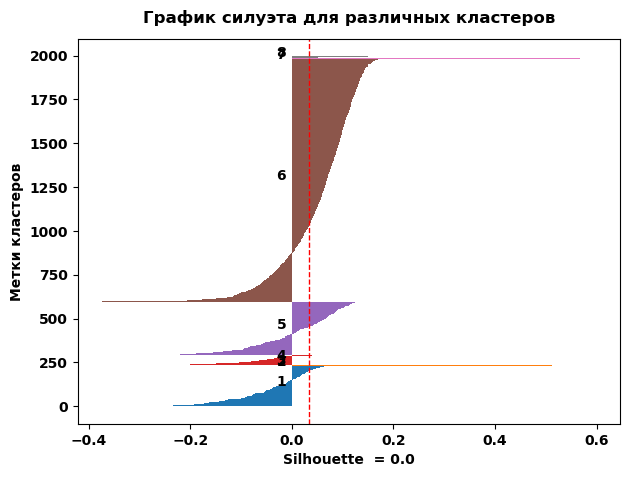

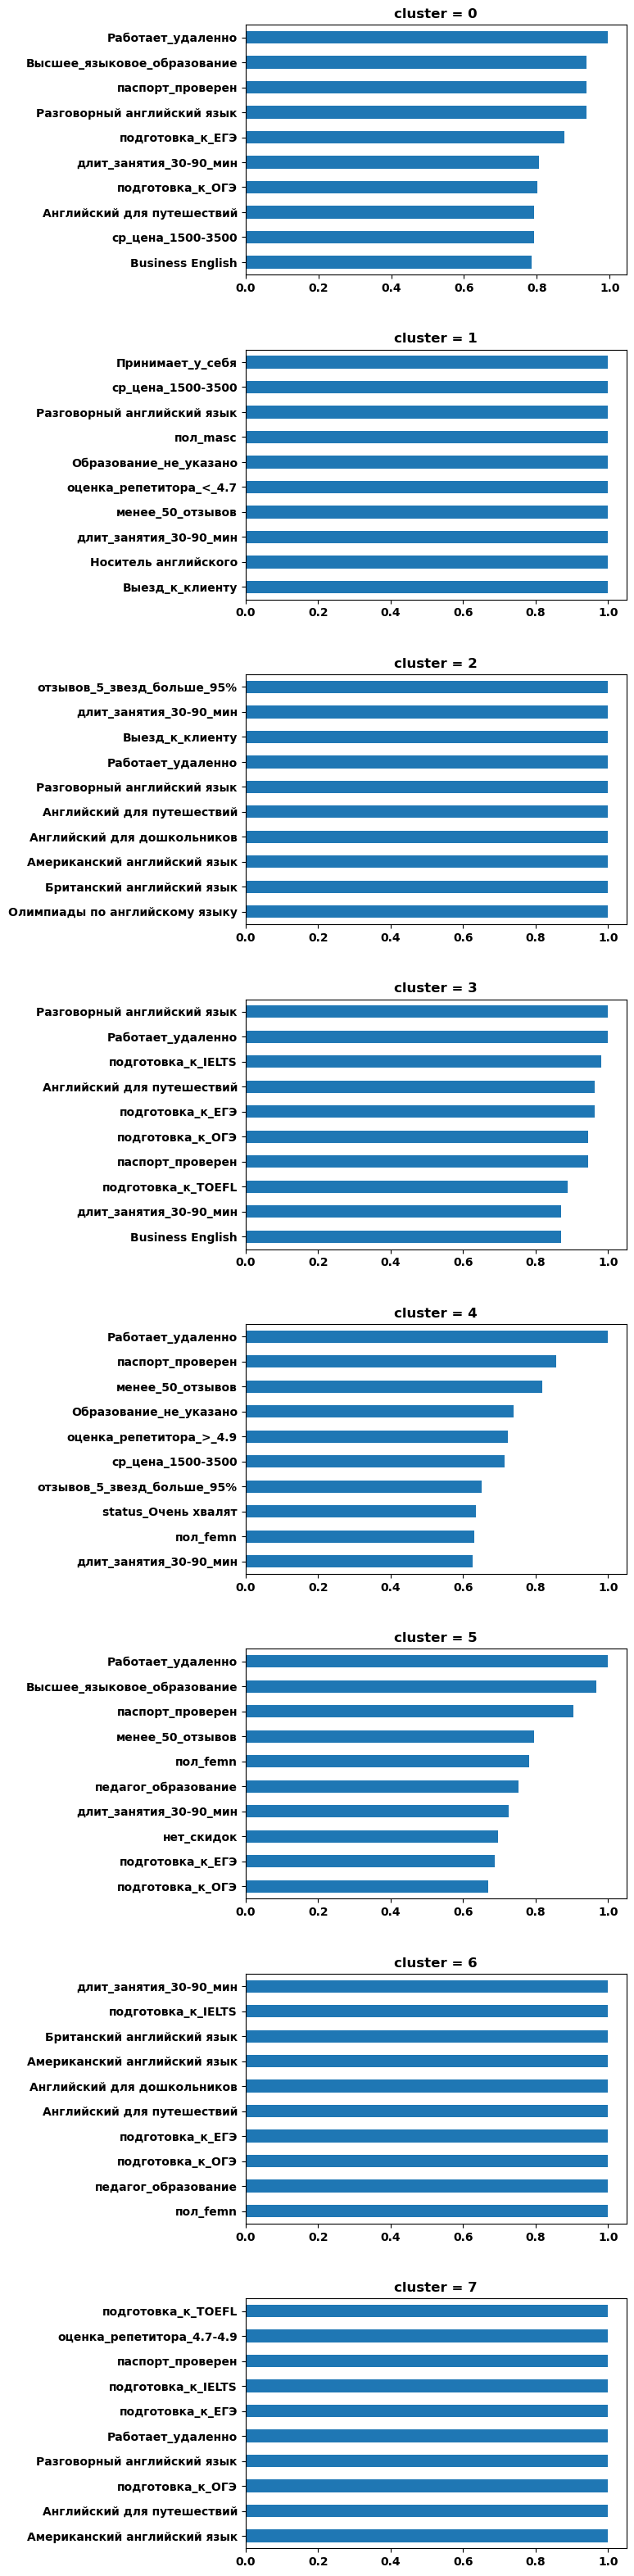

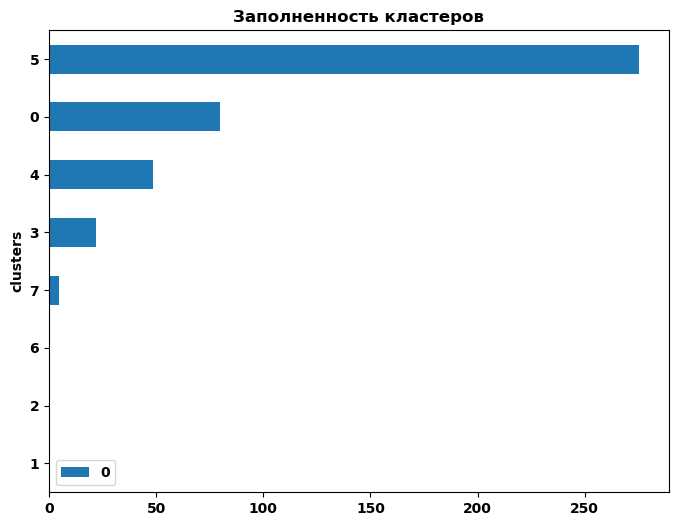

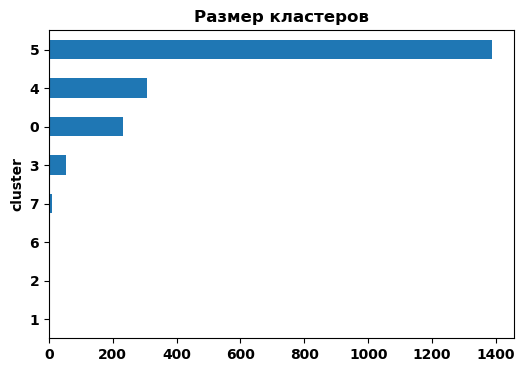

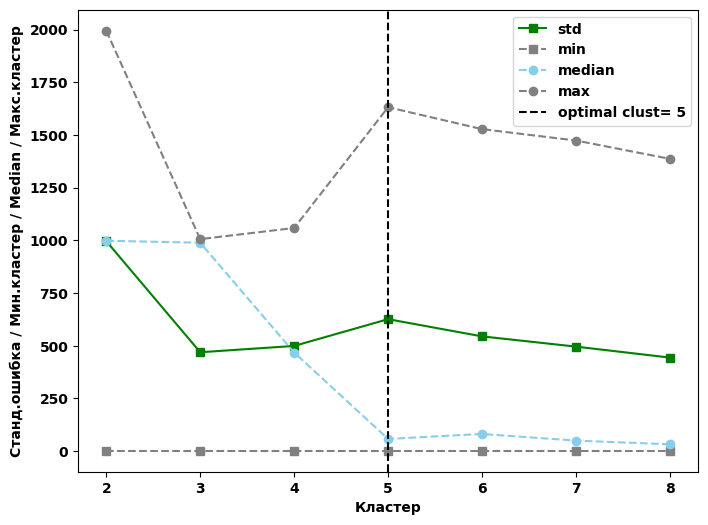

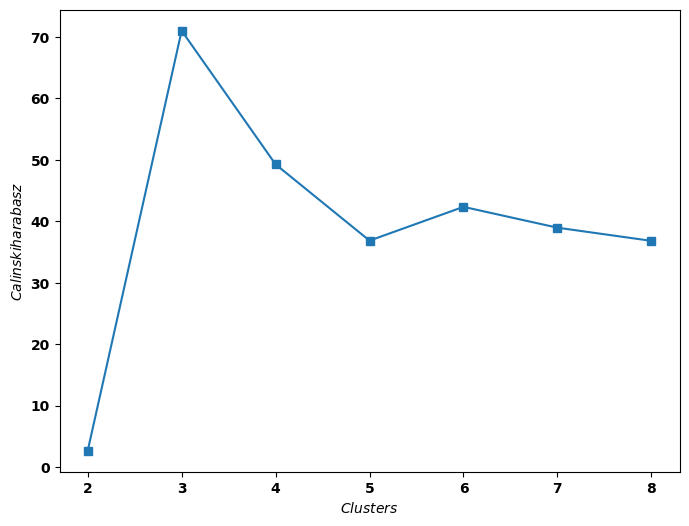

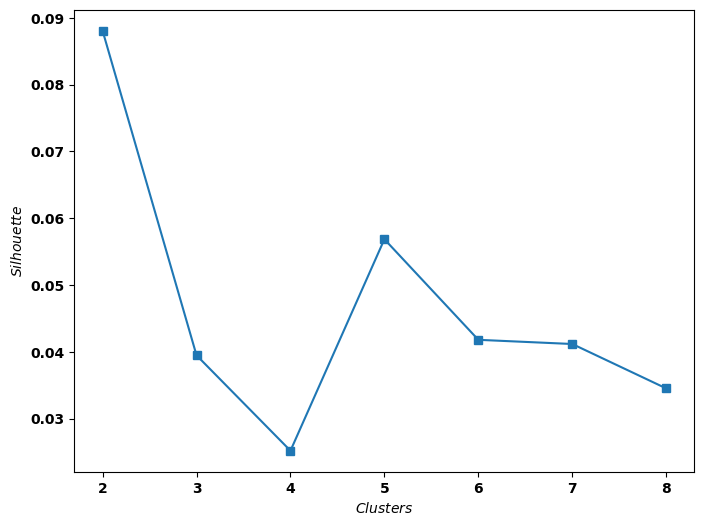

In [25]:
labels_std = []
labels_min = []
labels_median = []
labels_max = []

min_size = 2
max_size = 8
calinski_harabasz = []
silhouette_list = []

for clust in tqdm_notebook(range(min_size, max_size + 1)):
    clf = SpectralClustering(n_clusters=clust)
    clf.fit(df_cleaned)

    print(clust, 'clusters')
    print('-' * 100)

    silhouette_plot(df_cleaned, clf.labels_)
    # топ-признаков
    plot_top_features(df_cleaned, clf.labels_, clust)
    # медианная заполненность
    check_fullness(df_cleaned, clf.labels_)
    # размер кластеров
    plot_size(df_cleaned, clf.labels_)

    calinski_harabasz.append(calinski_harabasz_score(df_cleaned, clf.labels_))
    silhouette_list.append(silhouette_score(df_cleaned, clf.labels_))

    _, counts = np.unique(clf.labels_, return_counts=True)

    labels_std.append(np.std(counts))
    labels_min.append(np.min(counts))
    labels_median.append(np.median(counts))
    labels_max.append(np.max(counts))

elbow_picture(labels_std, labels_min, labels_max, labels_median, labels_median,
              min_size, max_size)
metric_picture(calinski_harabasz,
               min_size,
               max_size,
               name_metric='Calinski harabasz',
               optimal=False)
metric_picture(silhouette_list,
               min_size,
               max_size,
               name_metric='Silhouette',
               optimal=False)

In [37]:
clf_spectral = SpectralClustering(n_clusters=3, random_state=RAND)
labels_spectral = clf_spectral.fit_predict(df_cleaned)

In [38]:
spectral_final = df_cleaned.assign(target=labels_spectral)
spectral_final[:4]

Принимает_у_себя  Выезд_к_клиенту  Работает_удаленно  Носитель английского  \
0                 1                1                  1                     1   
1                 0                0                  1                     0   
2                 0                0                  1                     0   
3                 1                0                  1                     0   

   стажировка в США  стажировка в Англии  переводчик  лингвист  \
0                 0                    0           0         0   
1                 0                    0           0         1   
2                 0                    0           1         0   
3                 1                    0           1         1   

   подготовка_к_IELTS  подготовка_к_IELTS_Academic  ...  менее_50_отзывов  \
0                   1                            1  ...                 0   
1                   1                            0  ...                 0   
2                   1                            0  ...                 0   
3                   1                            1  ...                 0   

   ср_цена_1500-3500  ср_цена_<1500  ср_цена_>3500  \
0                  1              0              0   
1                  1              0              0   
2                  1              0              0   
3                  1              0              0   

   уровень_знаний_подтверждён  нет_скидок  паспорт_проверен  \
0                           1           1                 1   
1                           1           1                 1   
2                           1           1                 1   
3                           0           0                 1   

   доля_плохих_отзывов_10%_и_более  отзывов_5_звезд_больше_95%  target  
0                                0                           0       2  
1                                0                           0       0  
2                                0                           1       2  
3                                0                           1       2  

[4 rows x 53 columns]

In [39]:
spectral_final['target'].value_counts()

target
2    1006
0     989
1       2
Name: count, dtype: int64

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 3')

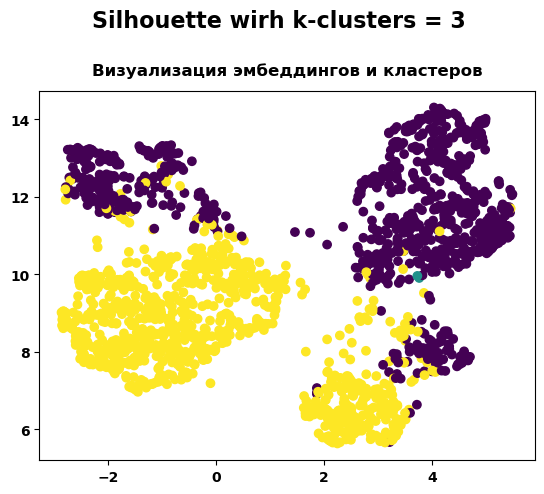

In [40]:
plt.scatter(clean_df_embedding[:, 0],
            clean_df_embedding[:, 1],
            c=labels_spectral)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {3}', fontsize=16, y=1.05)

**Спектральная кластеризация без подбора параметров очень плохо разделяет кластеры. При любом кол-ве кластеров будут кластеры, которые содержат всего несколько элементов. При разделении на 3 кластера такой кластер только 1.**

# Agglomerative

  0%|          | 0/7 [00:00<?, ?it/s]

2 clusters
----------------------------------------------------------------------------------------------------


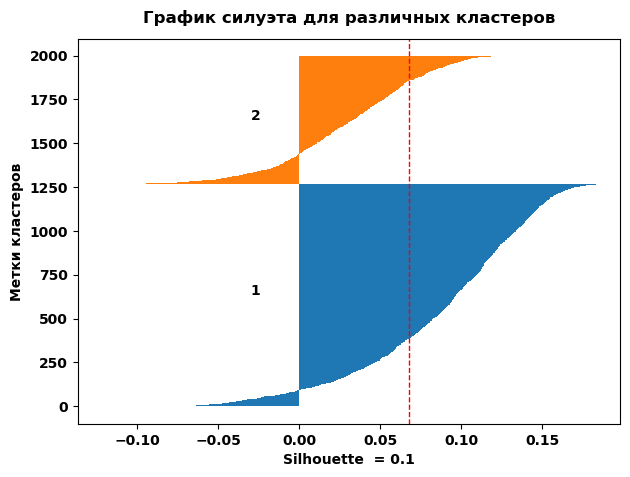

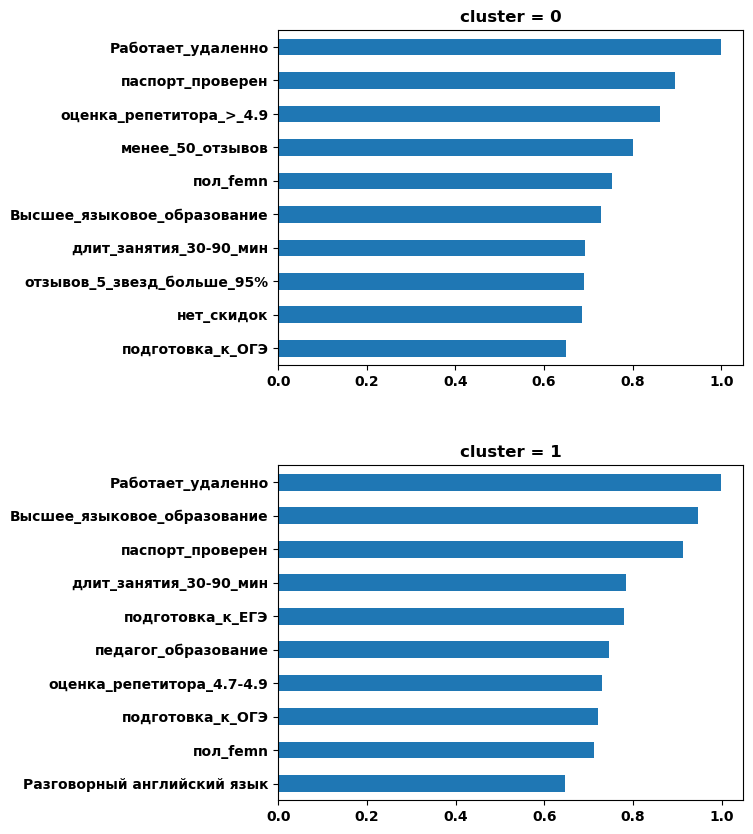

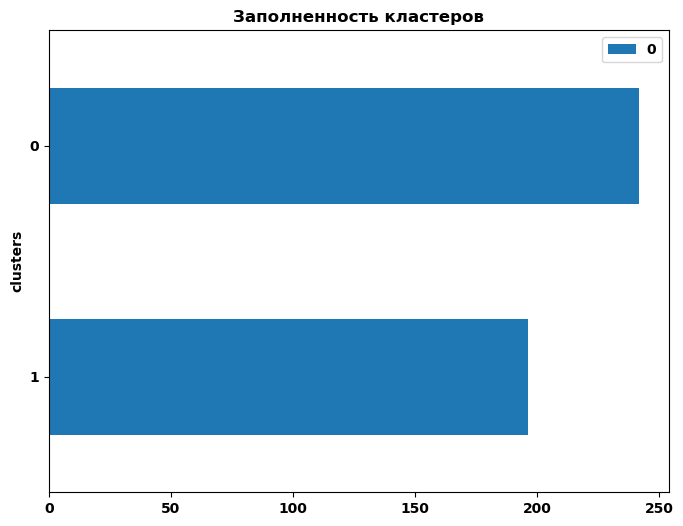

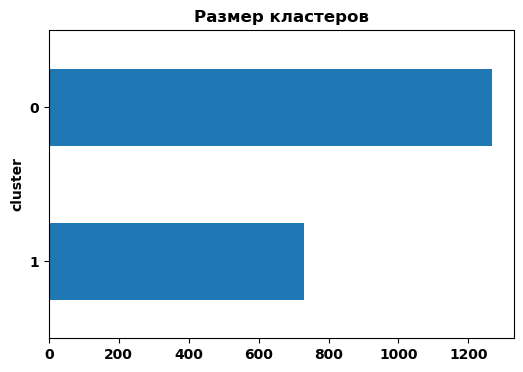

3 clusters
----------------------------------------------------------------------------------------------------


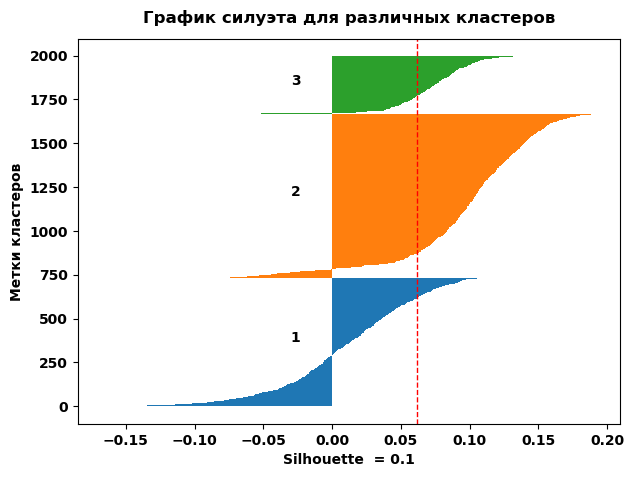

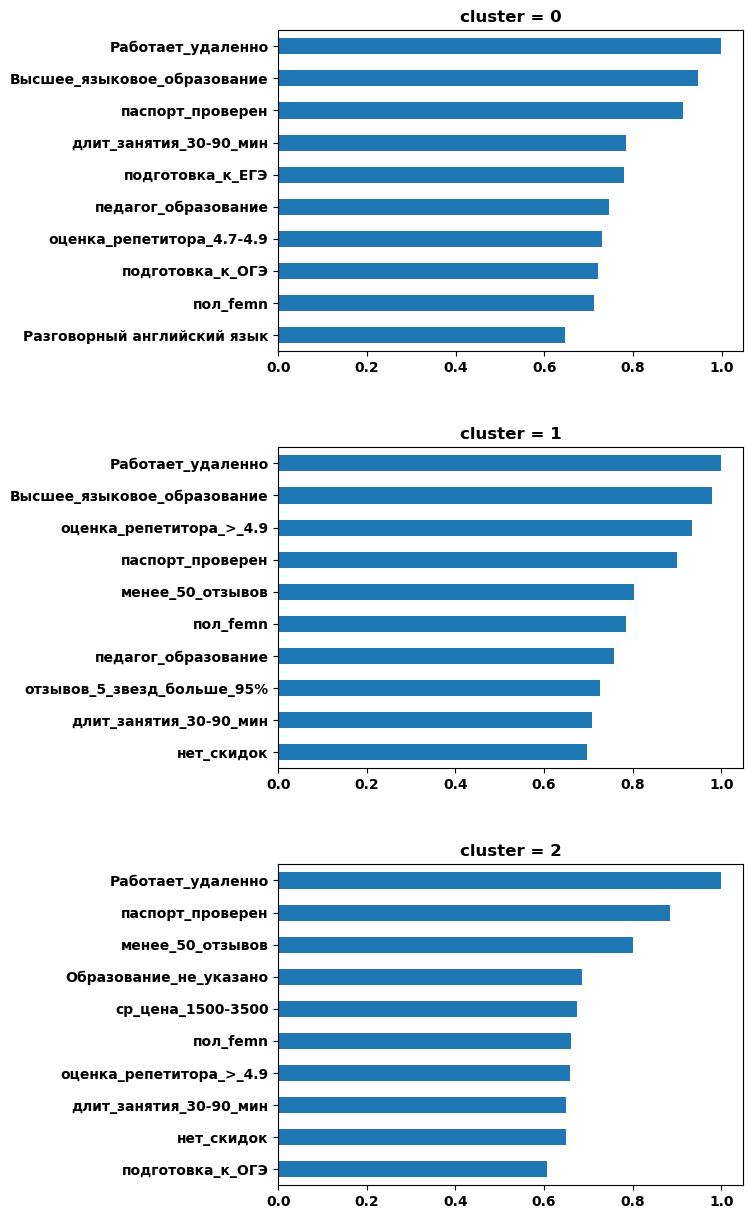

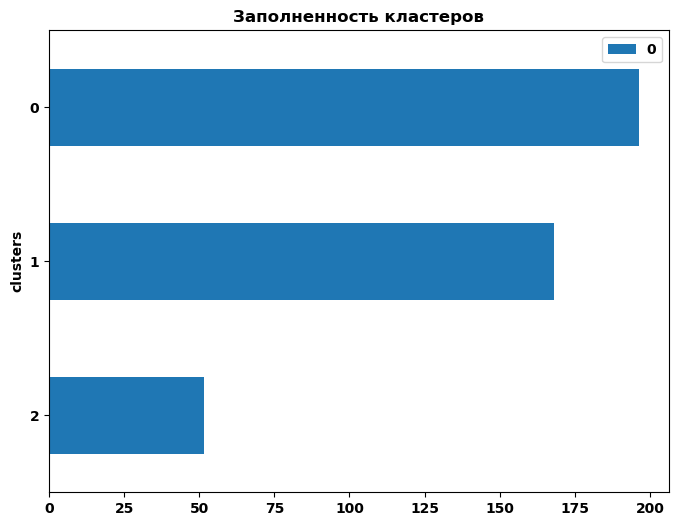

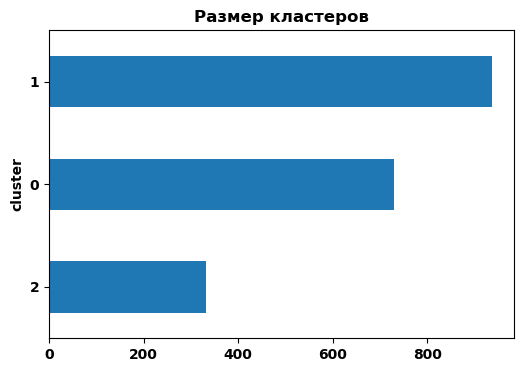

4 clusters
----------------------------------------------------------------------------------------------------


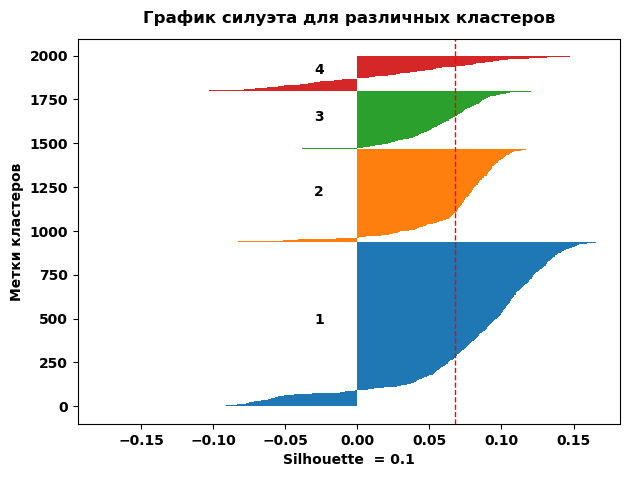

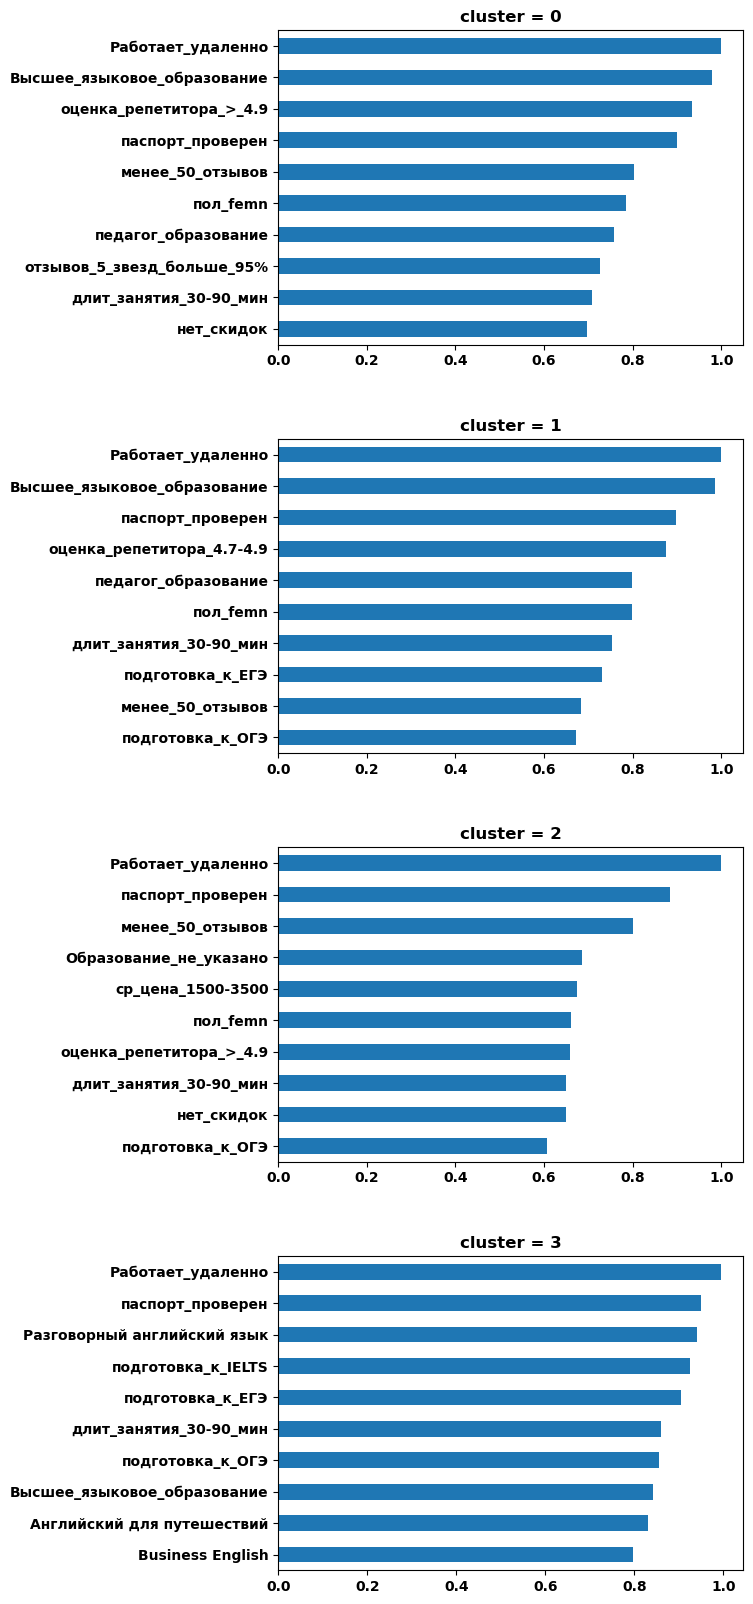

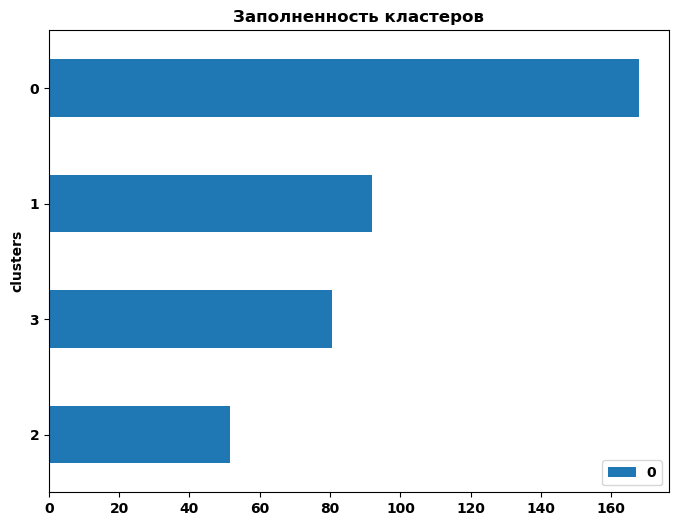

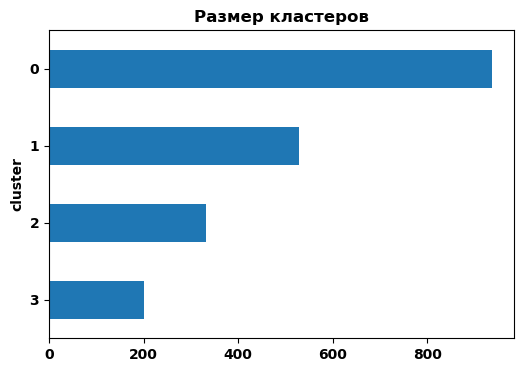

5 clusters
----------------------------------------------------------------------------------------------------


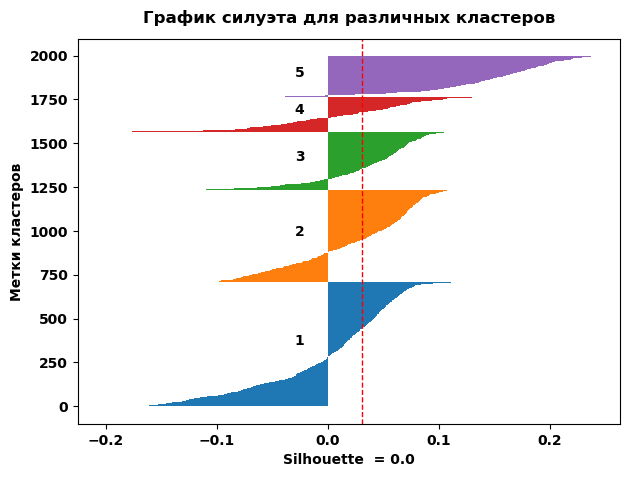

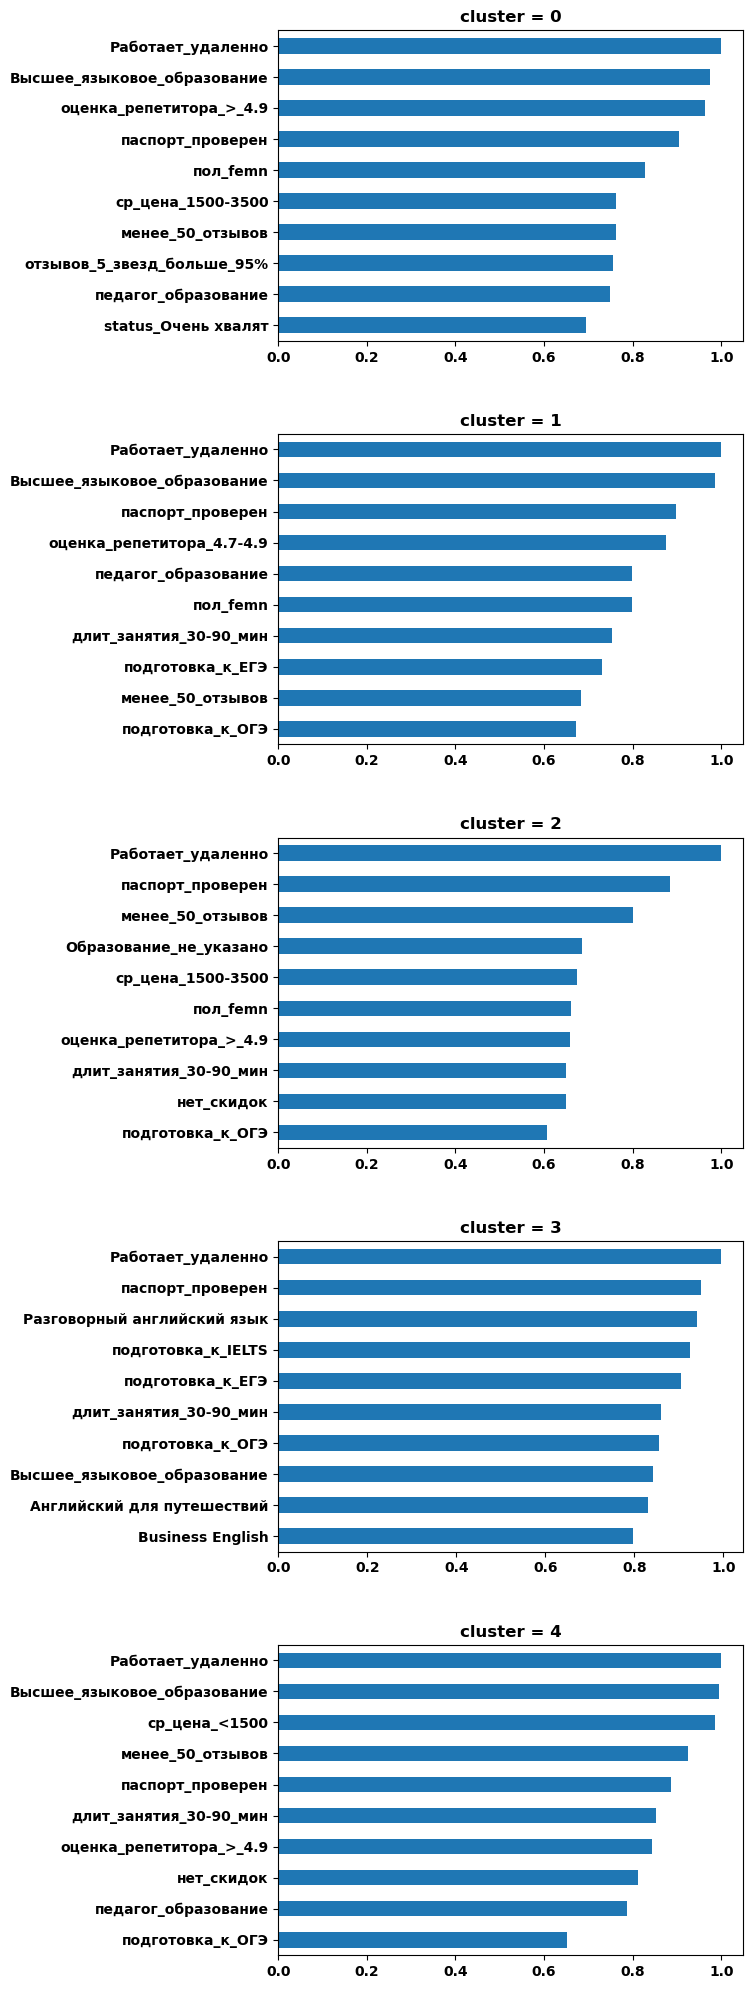

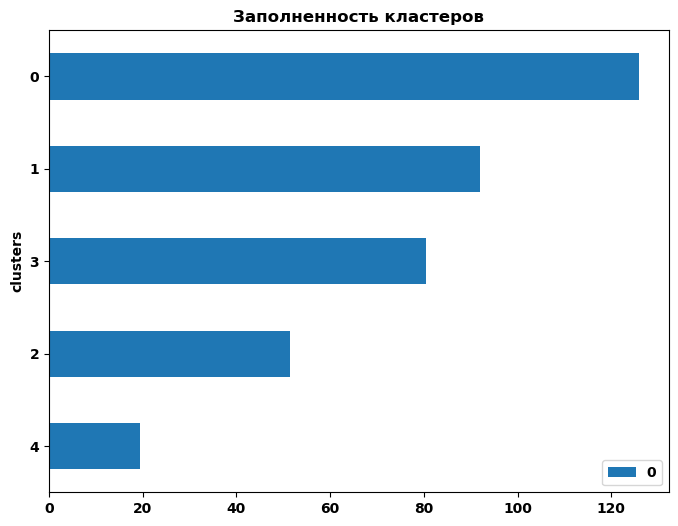

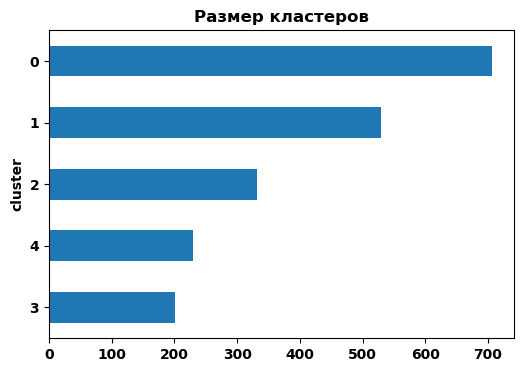

6 clusters
----------------------------------------------------------------------------------------------------


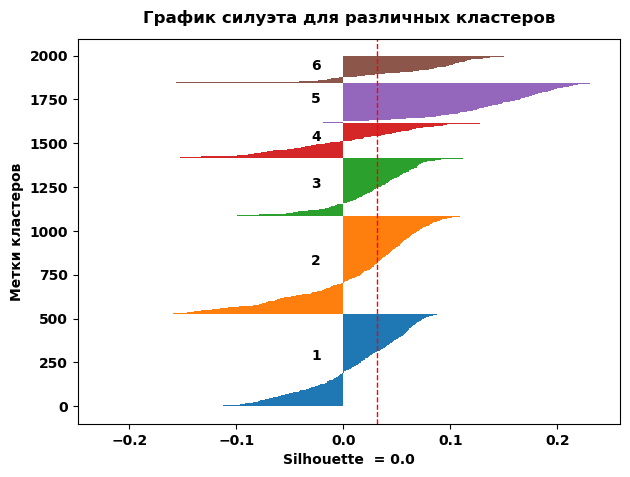

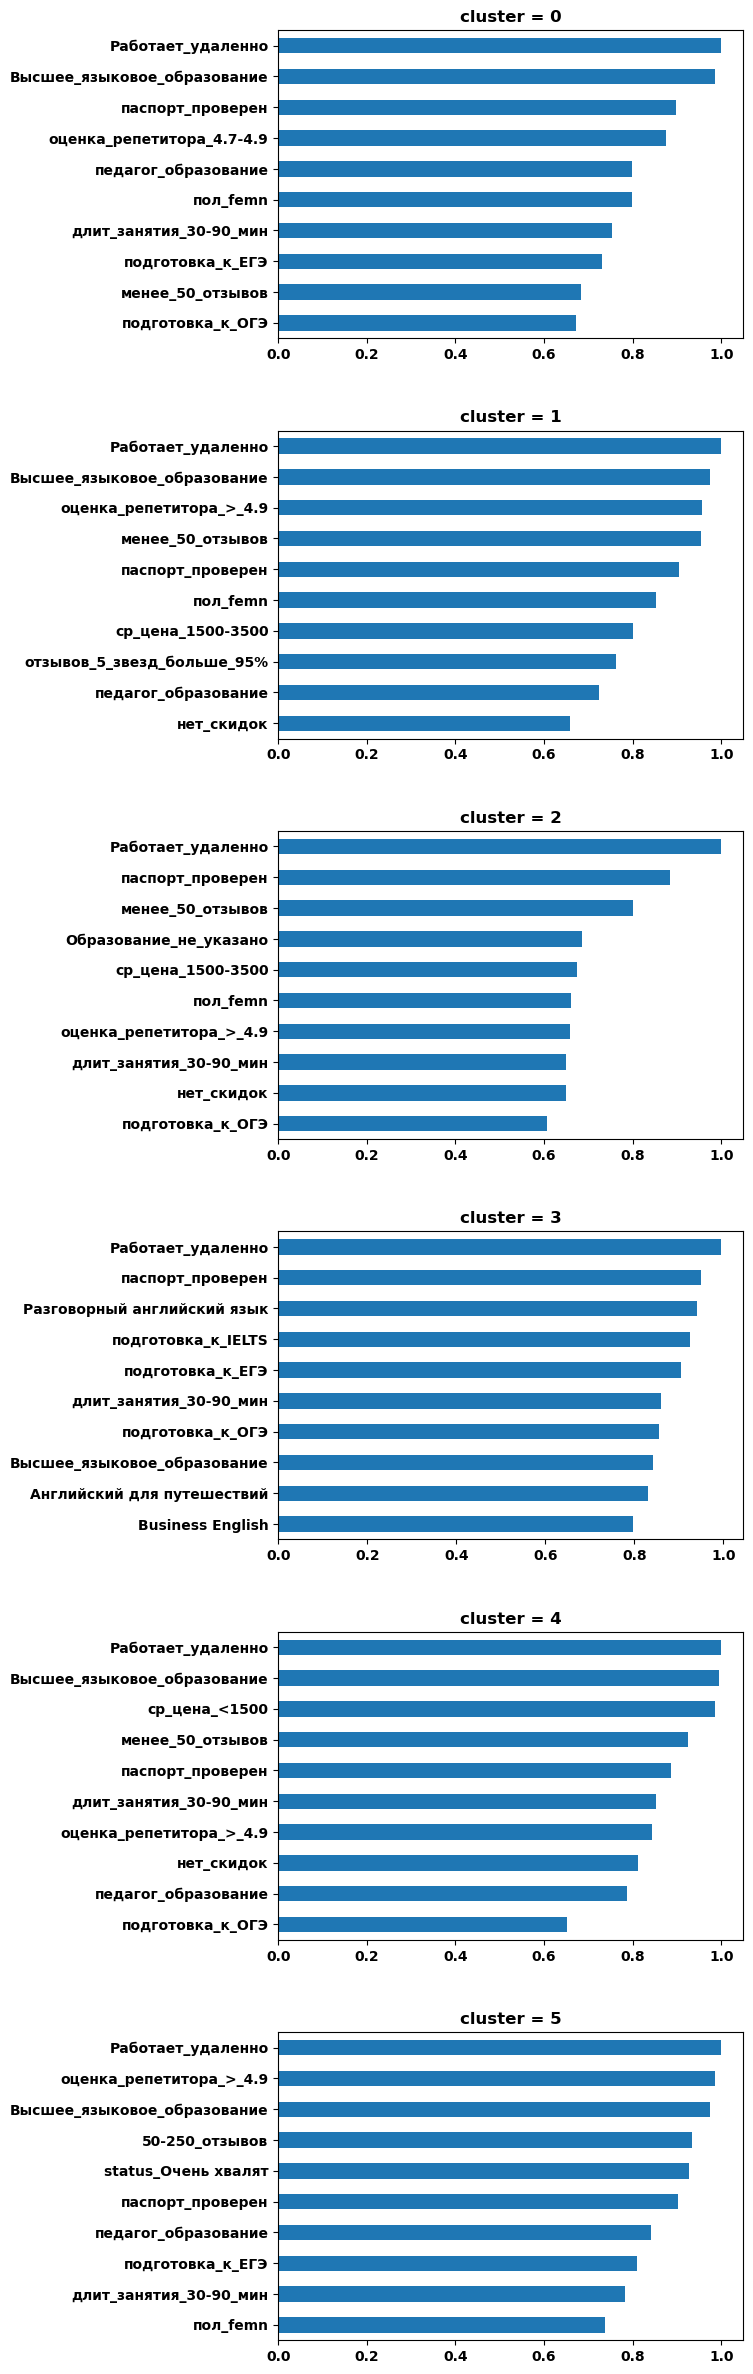

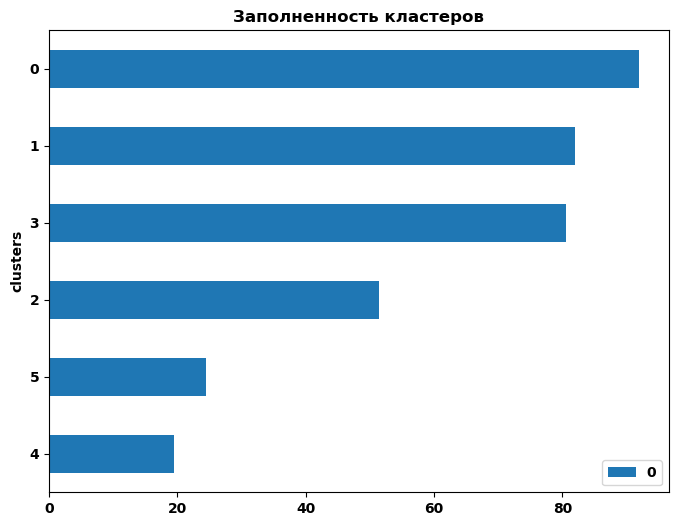

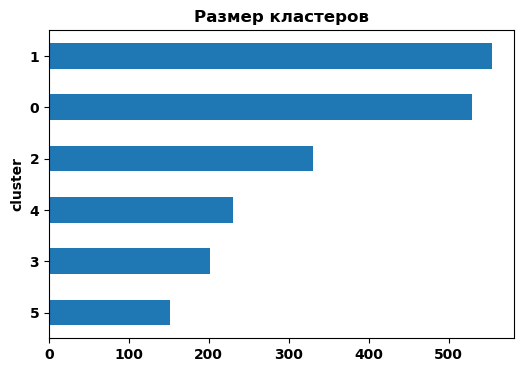

7 clusters
----------------------------------------------------------------------------------------------------


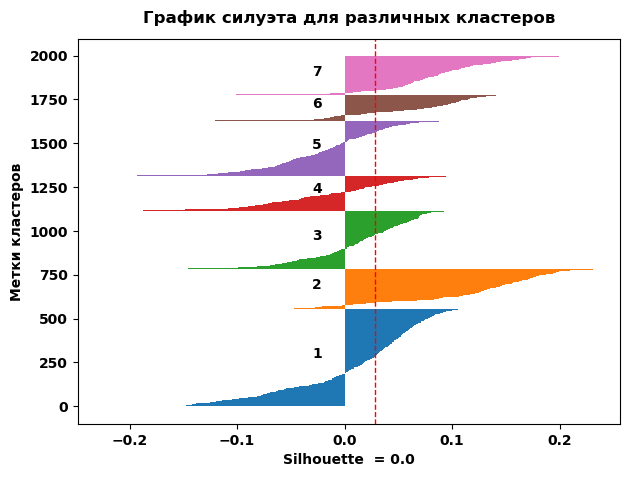

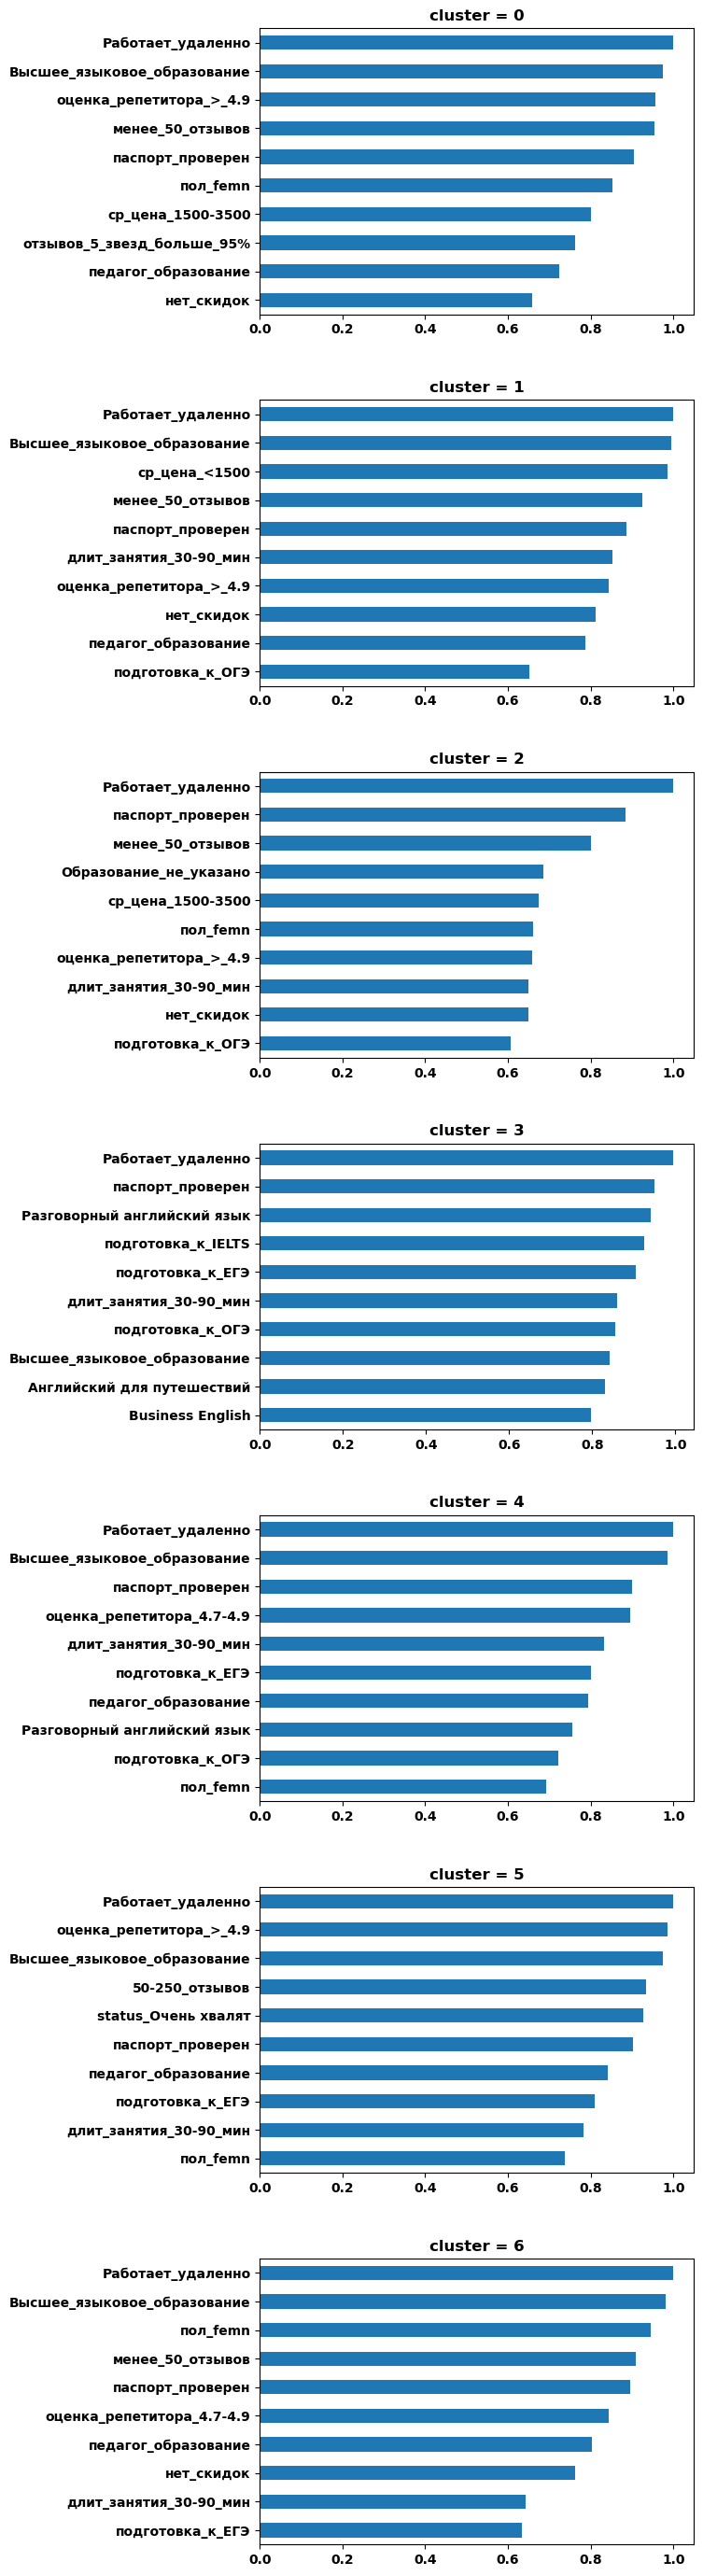

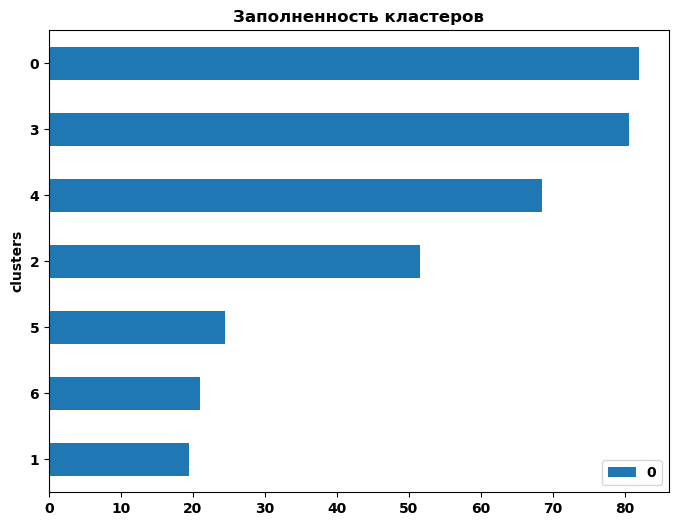

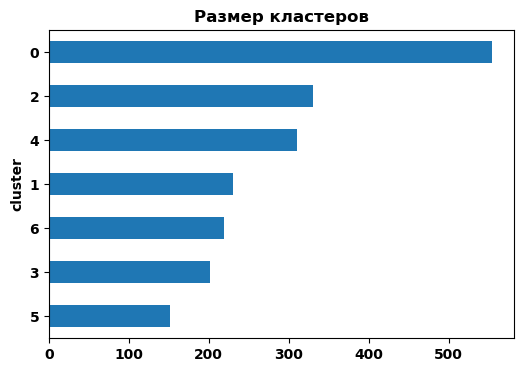

8 clusters
----------------------------------------------------------------------------------------------------


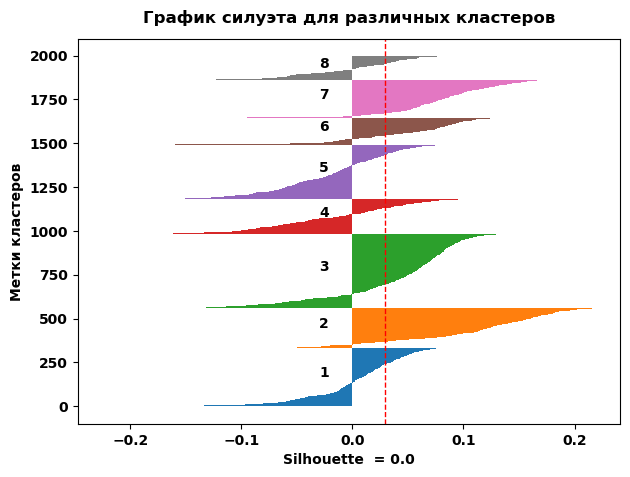

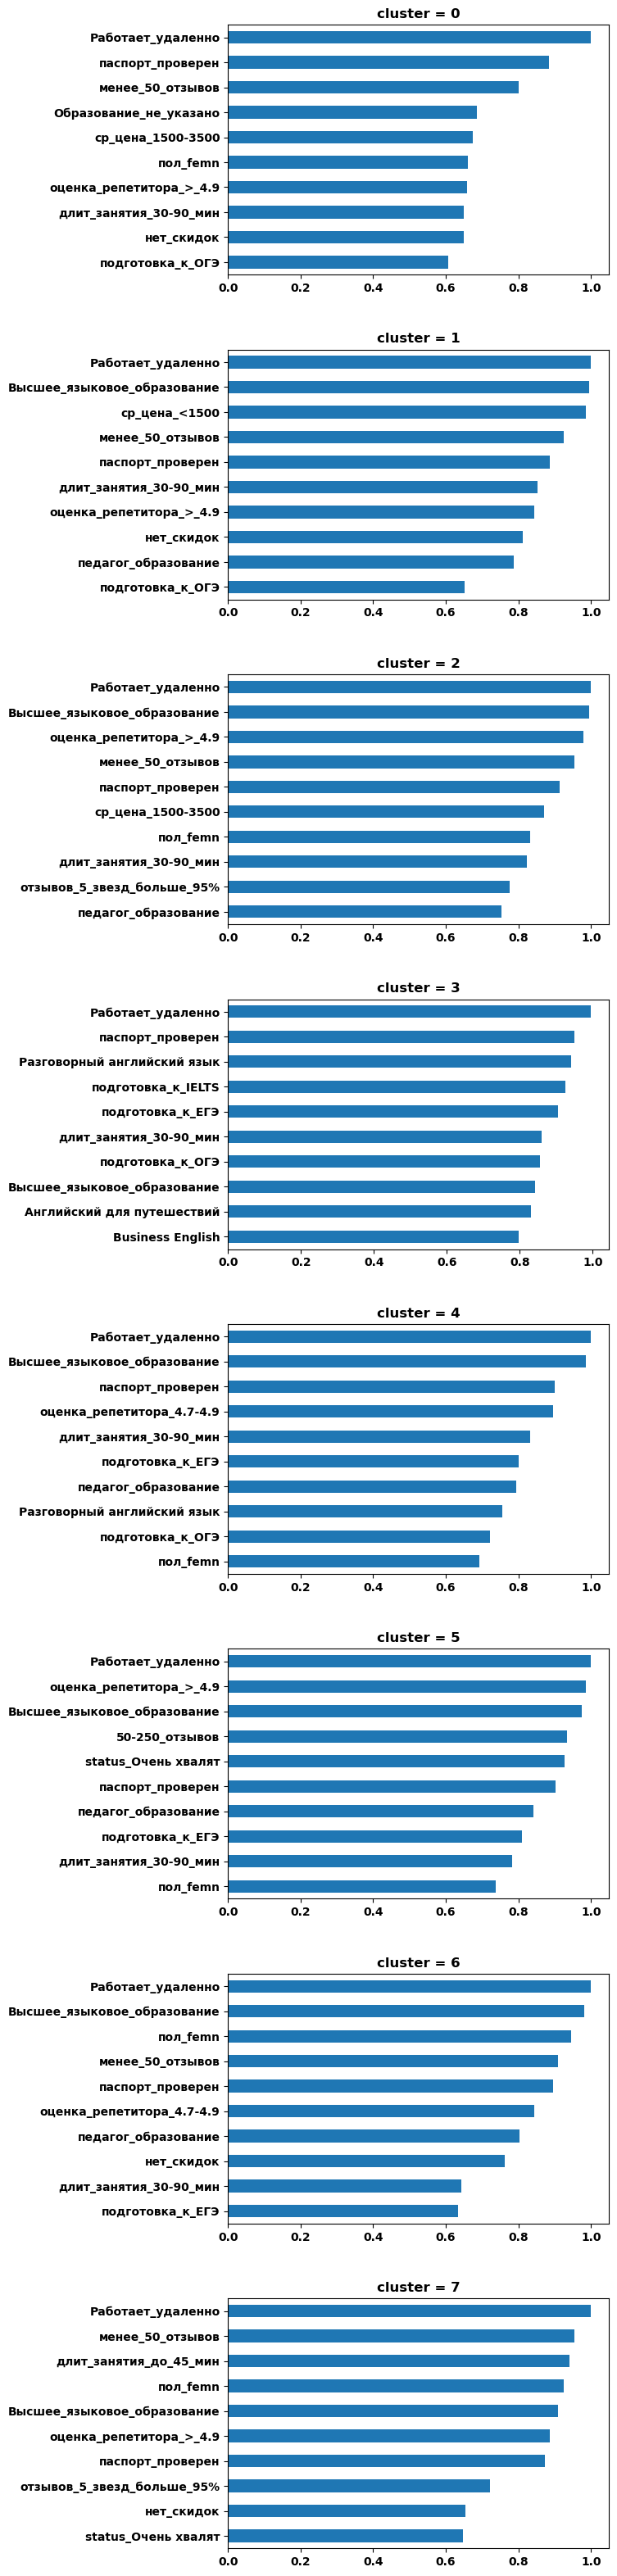

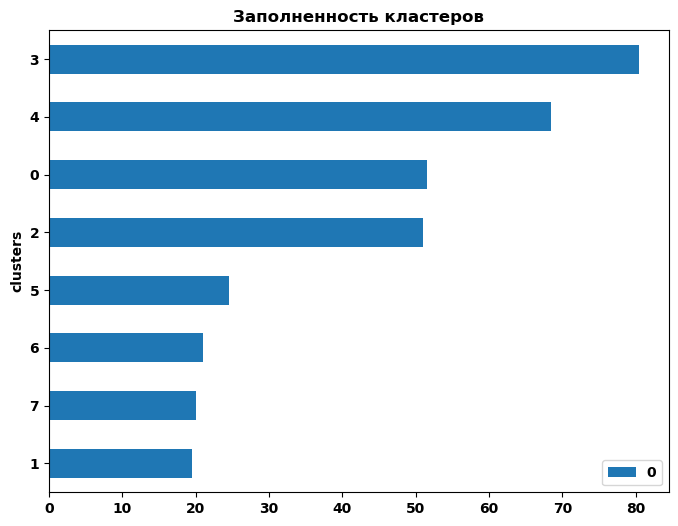

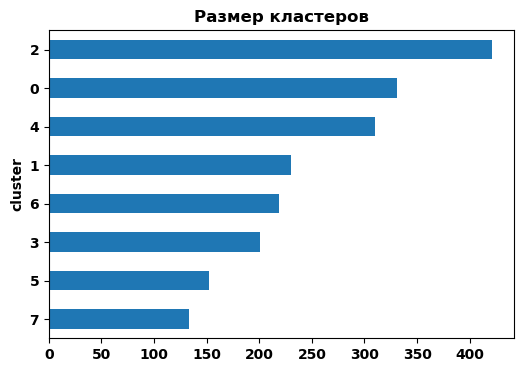

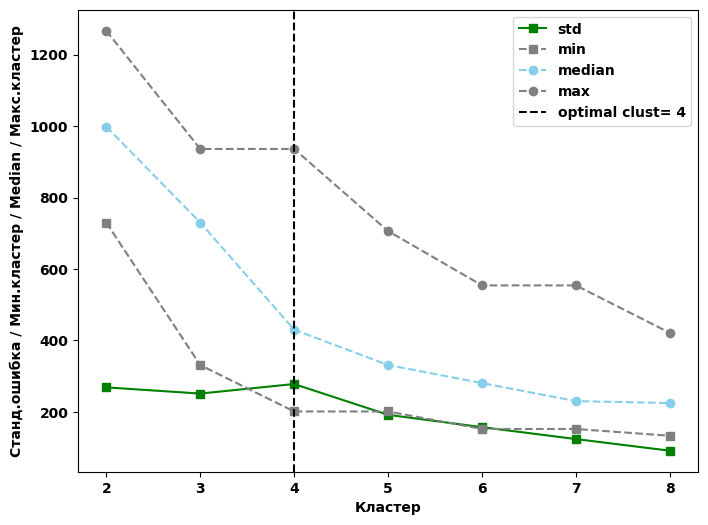

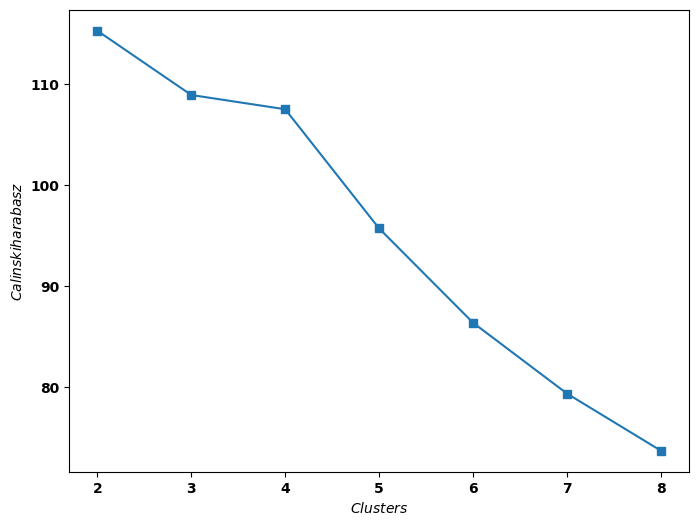

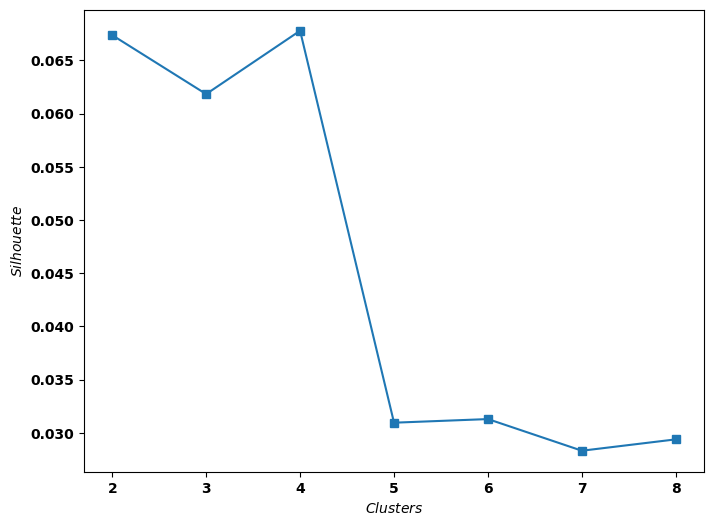

In [33]:
labels_std = []
labels_min = []
labels_max = []
labels_median = []

min_size = 2
max_size = 8
calinski_harabasz = []
silhouette_list = []

for clust in tqdm_notebook(range(min_size, max_size + 1)):
    clf = AgglomerativeClustering(n_clusters=clust)
    clf.fit(df_cleaned)

    print(clust, 'clusters')
    print('-' * 100)

    silhouette_plot(df_cleaned, clf.labels_)
    # топ-признаков
    plot_top_features(df_cleaned, clf.labels_, clust)
    # медианная заполненность
    check_fullness(df_cleaned, clf.labels_)
    # размер кластеров
    plot_size(df_cleaned, clf.labels_)

    calinski_harabasz.append(calinski_harabasz_score(df_cleaned, clf.labels_))
    silhouette_list.append(silhouette_score(df_cleaned, clf.labels_))

    _, counts = np.unique(clf.labels_, return_counts=True)

    labels_std.append(np.std(counts))
    labels_min.append(np.min(counts))
    labels_max.append(np.max(counts))
    labels_median.append(np.median(counts))

elbow_picture(labels_std, labels_min, labels_max, labels_median, labels_median,
              min_size, max_size)
metric_picture(calinski_harabasz,
               min_size,
               max_size,
               name_metric='Calinski harabasz',
               optimal=False)
metric_picture(silhouette_list,
               min_size,
               max_size,
               name_metric='Silhouette',
               optimal=False)

In [55]:
clf_aggl_clust = AgglomerativeClustering(n_clusters=4)
aggl_labels = clf_aggl_clust.fit_predict(df_cleaned)

df_agl_clust = df_cleaned.assign(target=aggl_labels)
df_agl_clust[:4]

Принимает_у_себя  Выезд_к_клиенту  Работает_удаленно  Носитель английского  \
0                 1                1                  1                     1   
1                 0                0                  1                     0   
2                 0                0                  1                     0   
3                 1                0                  1                     0   

   стажировка в США  стажировка в Англии  переводчик  лингвист  \
0                 0                    0           0         0   
1                 0                    0           0         1   
2                 0                    0           1         0   
3                 1                    0           1         1   

   подготовка_к_IELTS  подготовка_к_IELTS_Academic  ...  менее_50_отзывов  \
0                   1                            1  ...                 0   
1                   1                            0  ...                 0   
2                   1                            0  ...                 0   
3                   1                            1  ...                 0   

   ср_цена_1500-3500  ср_цена_<1500  ср_цена_>3500  \
0                  1              0              0   
1                  1              0              0   
2                  1              0              0   
3                  1              0              0   

   уровень_знаний_подтверждён  нет_скидок  паспорт_проверен  \
0                           1           1                 1   
1                           1           1                 1   
2                           1           1                 1   
3                           0           0                 1   

   доля_плохих_отзывов_10%_и_более  отзывов_5_звезд_больше_95%  target  
0                                0                           0       3  
1                                0                           0       1  
2                                0                           1       0  
3                                0                           1       3  

[4 rows x 53 columns]

In [56]:
print(f'silhouette: {silhouette_score(df_cleaned, labels_gmm3)}')
print(f'calinski_harabasz: {calinski_harabasz_score(df_cleaned, labels_gmm3)}')

silhouette: 0.06874379935942487
calinski_harabasz: 127.94888415485705


In [57]:
df_agl_clust['target'].value_counts()

target
0    936
1    529
2    331
3    201
Name: count, dtype: int64

Text(0.5, 1.05, 'Silhouette wirh k-clusters = 4')

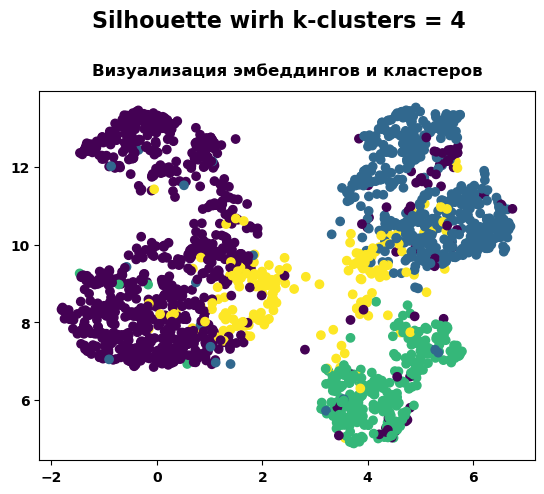

In [38]:
plt.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=aggl_labels)
plt.title('Визуализация эмбеддингов и кластеров', y=1.02)
plt.suptitle(f'Silhouette wirh k-clusters = {4}', fontsize=16, y=1.05)

<AxesSubplot: xlabel='target'>

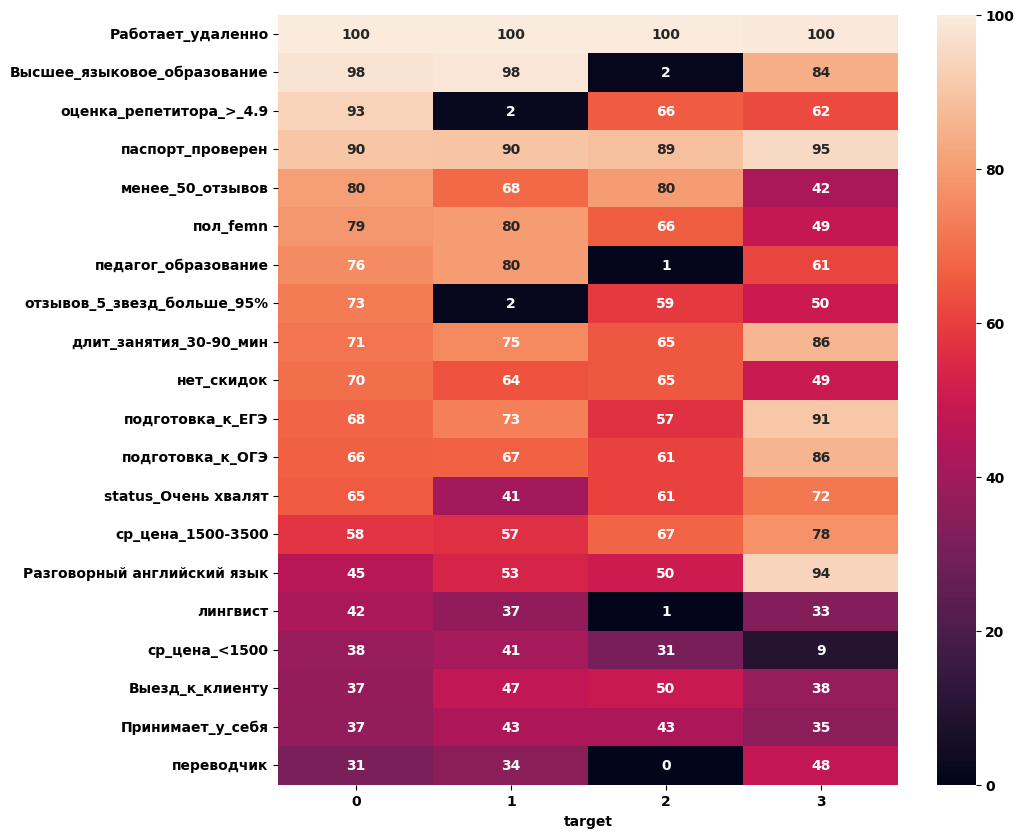

In [37]:
count = df_agl_clust.groupby('target').count().iloc[:, :1].T.values
normalize = df_agl_clust.groupby('target').sum().T / count * 100

plt.figure(figsize=(10, 10))
sns.heatmap(normalize.sort_values(by=0, ascending=False)[:20],
            fmt='.0f',
            annot=True)

- кластер 0 - преобладают женщины, с высшим языковым образованием (в основном педагогич.), самыми высокими оценками;
- кластер 1 - преобладают женщины, отсутствуют специалисты с очень высокими оценками, большинство имеет пед. образование;
- кластер 2 - преобладают женщины, без высшего язык. образования(или не указано), каждый второй готов выезжать к клиенту, мало отзывов;
- кластер 3 - женщин и мужчин примерно одинак. кол-во, преподают разговорный/бизнес английский, подготовку к ЕГЭ/ОГЭ, преобладают специалисты среднего ценового сегмента, скидки предоставляет только половина специалистов.

# GMM

  0%|          | 0/7 [00:00<?, ?it/s]

2 clusters
----------------------------------------------------------------------------------------------------


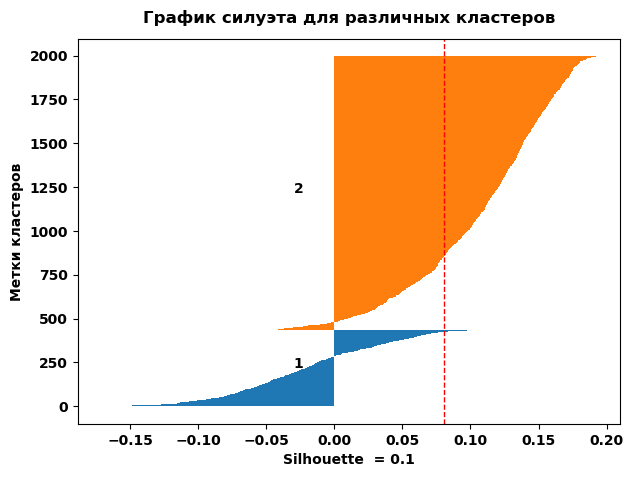

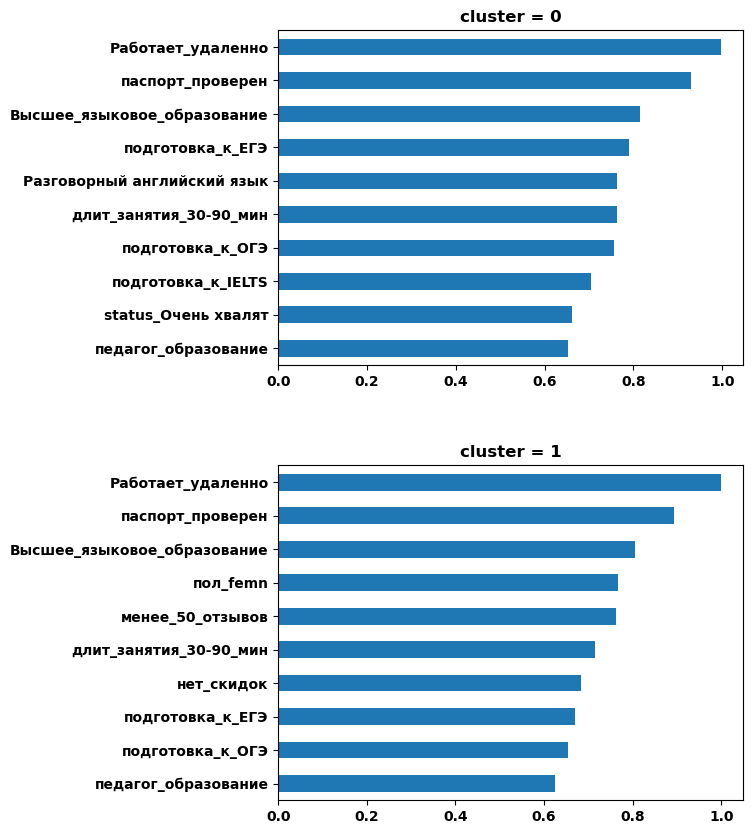

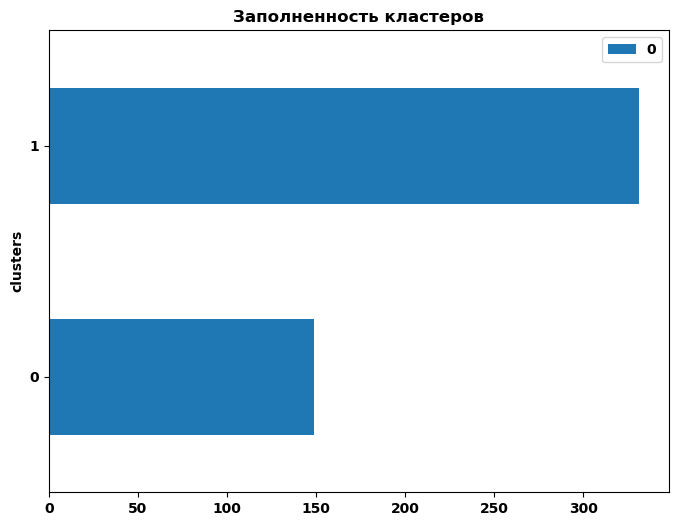

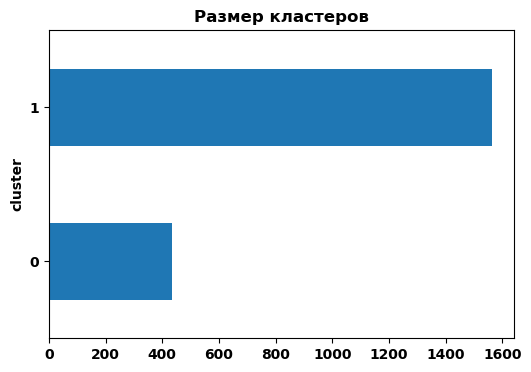

3 clusters
----------------------------------------------------------------------------------------------------


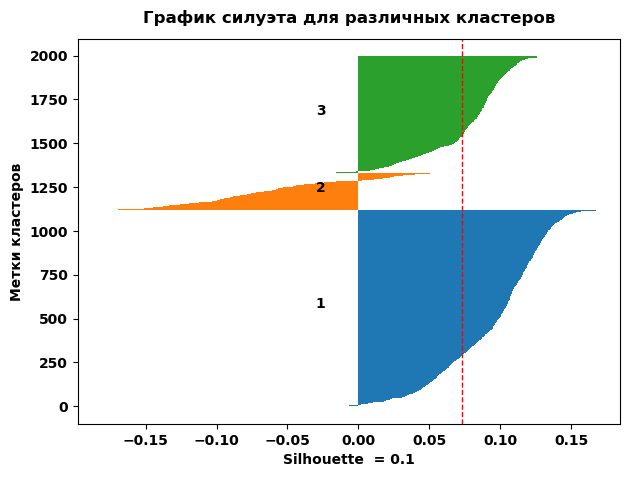

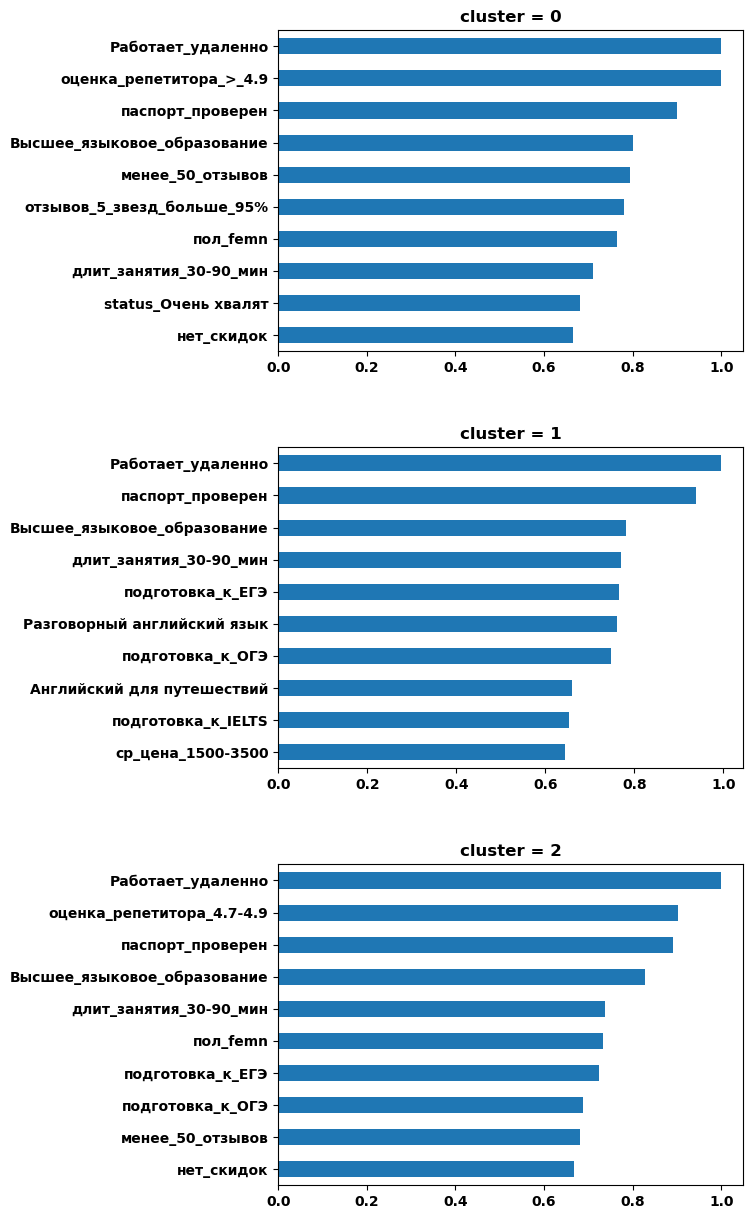

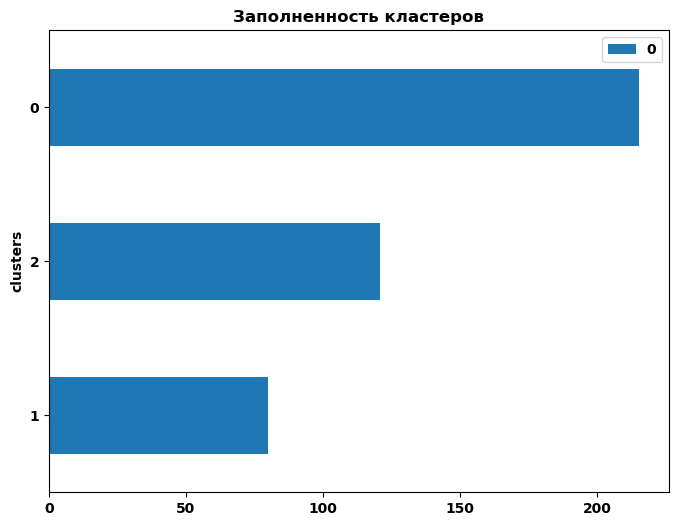

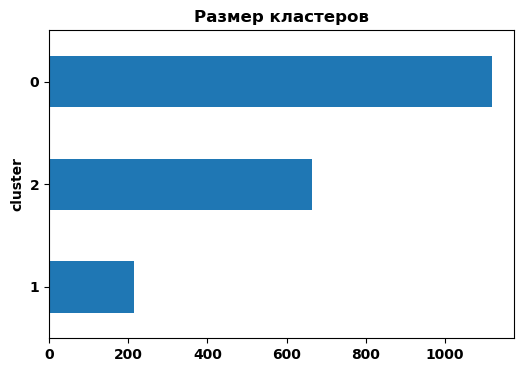

4 clusters
----------------------------------------------------------------------------------------------------


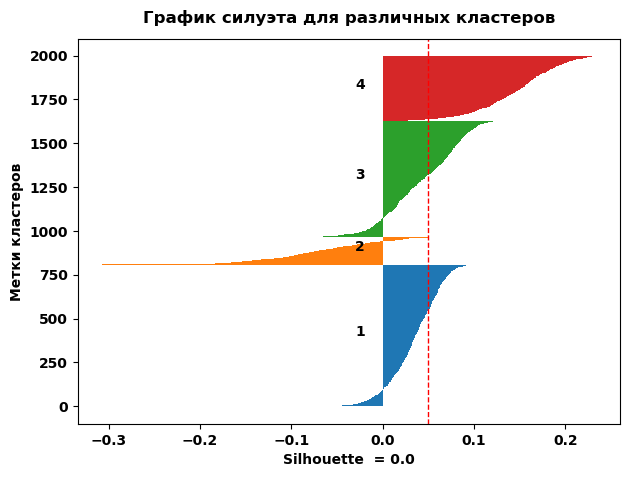

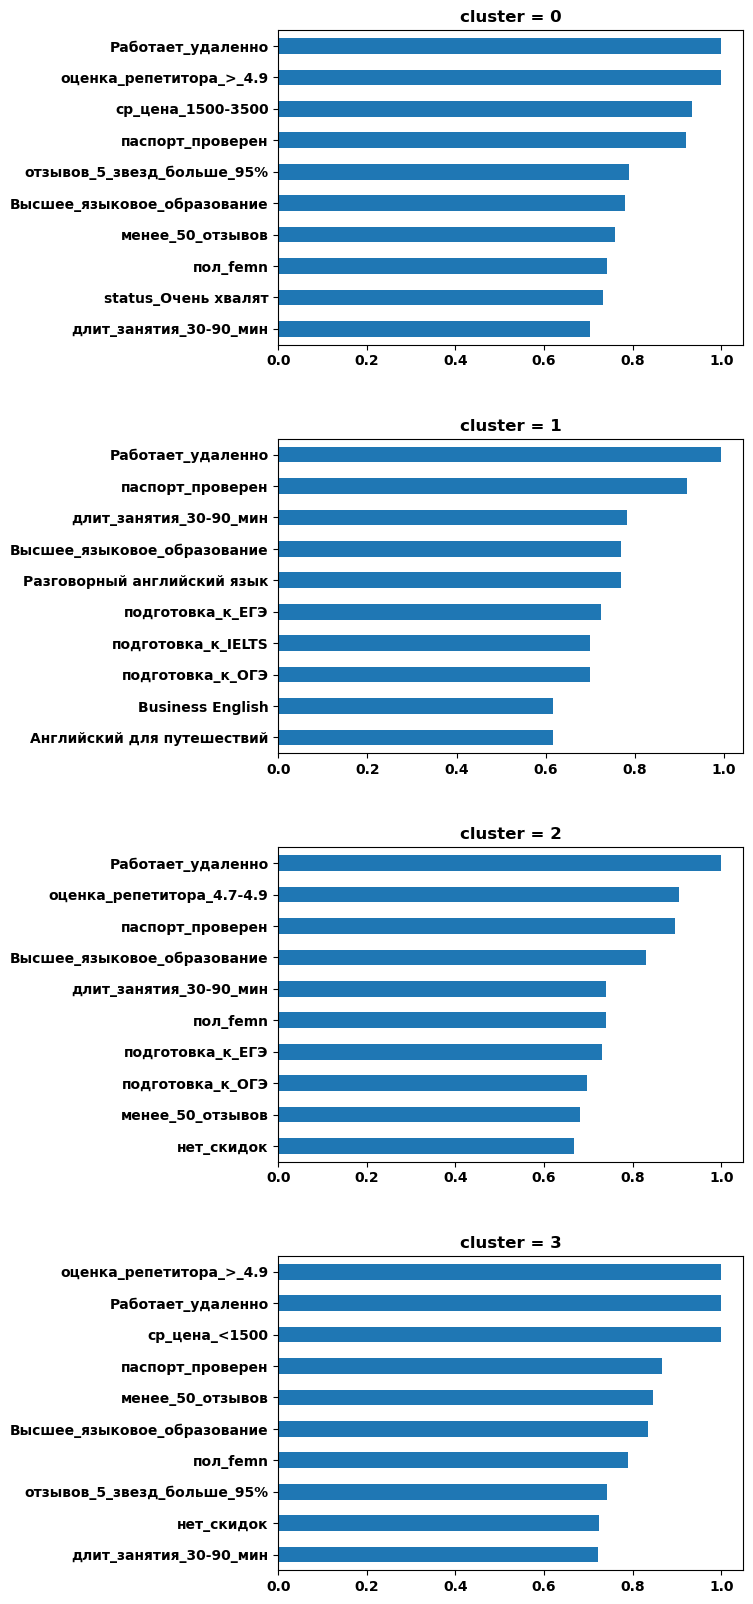

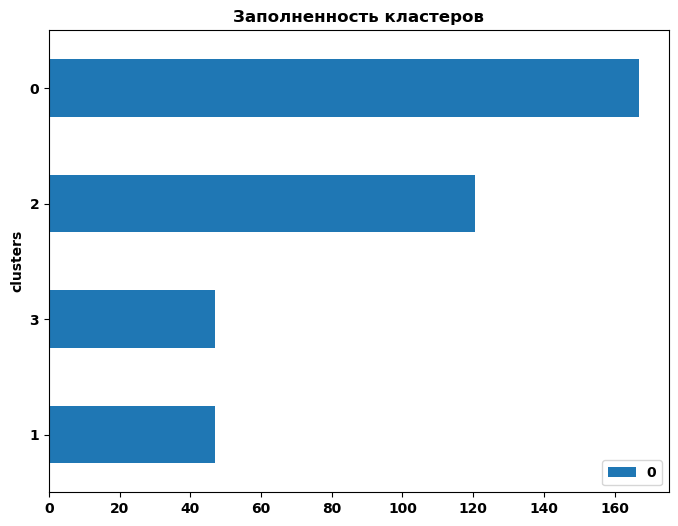

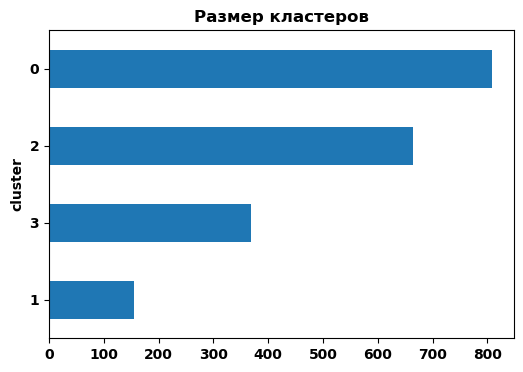

5 clusters
----------------------------------------------------------------------------------------------------


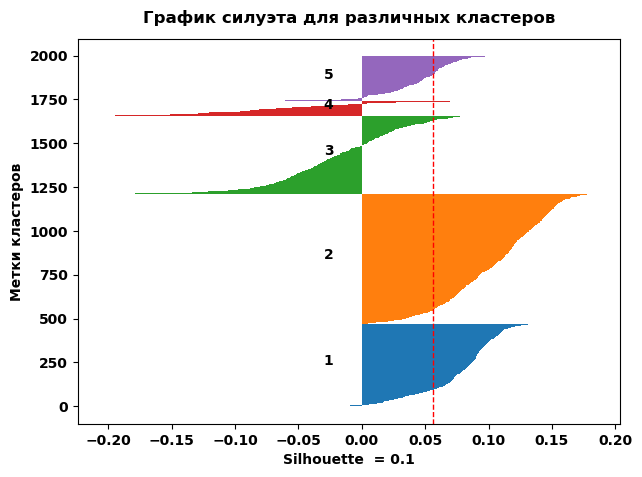

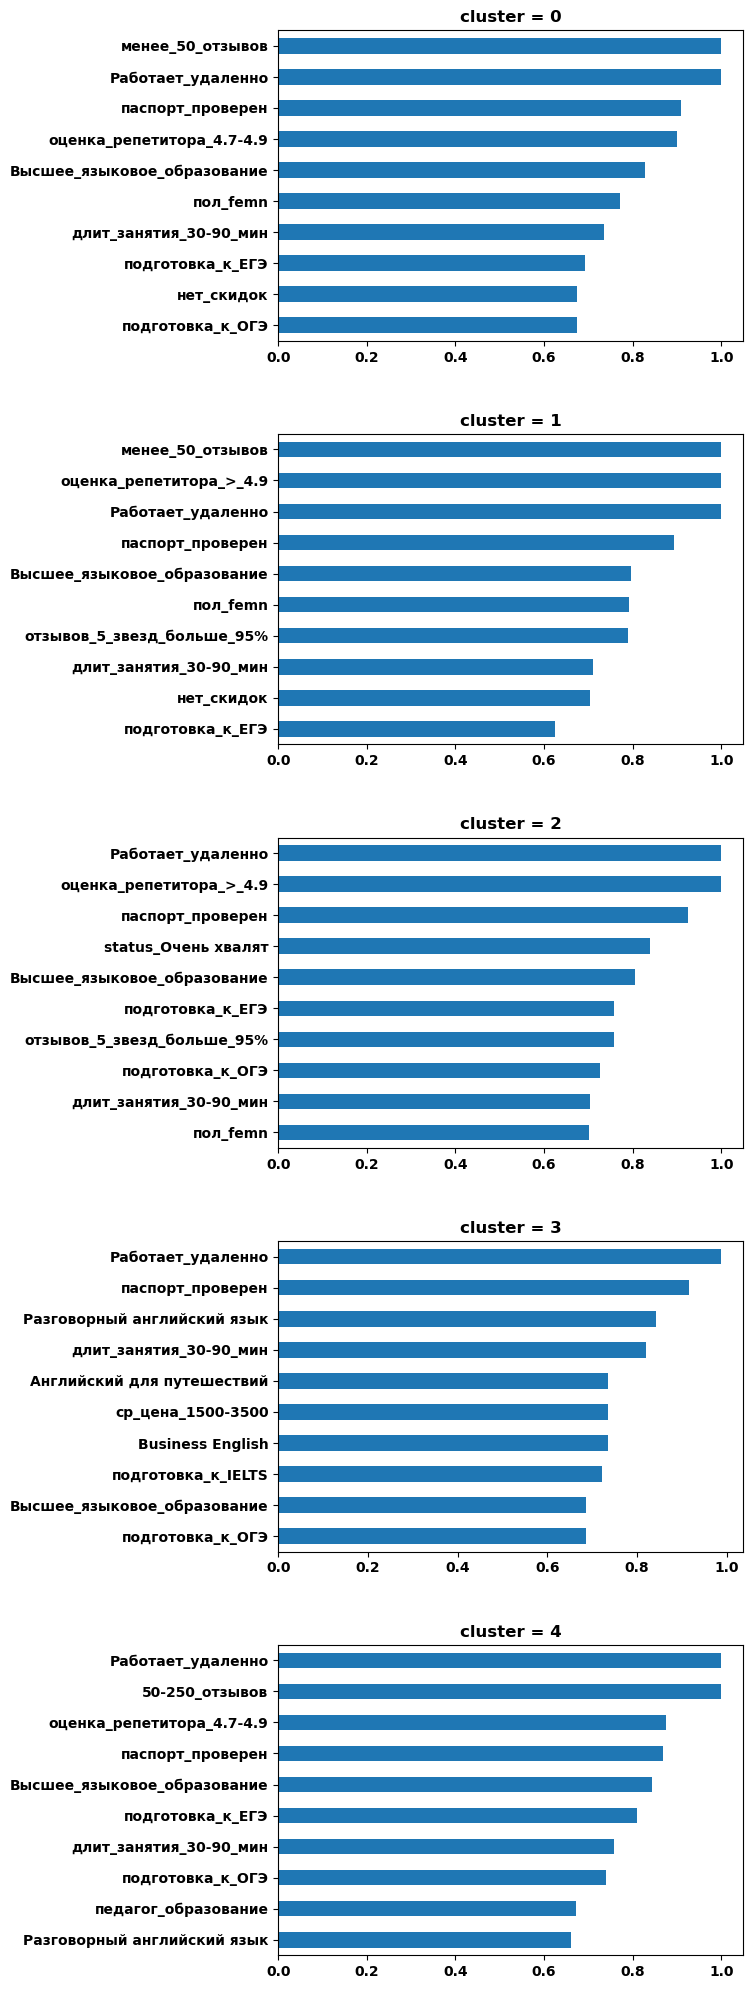

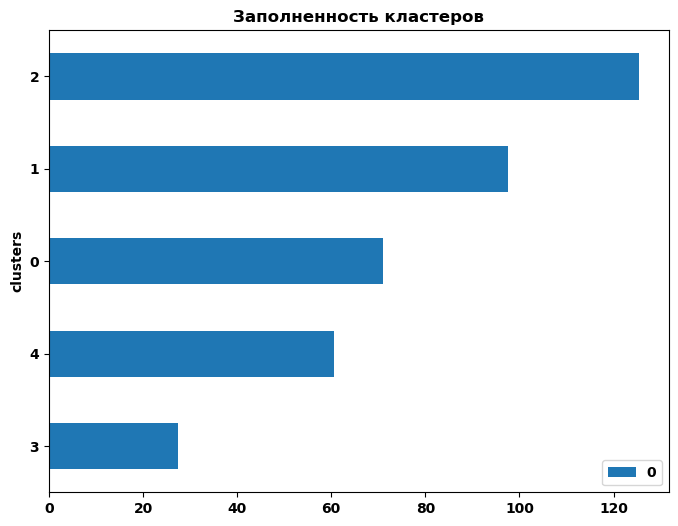

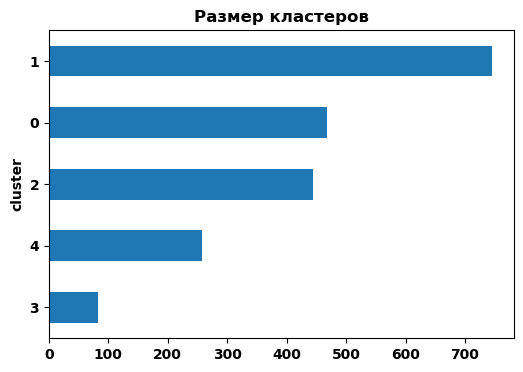

6 clusters
----------------------------------------------------------------------------------------------------


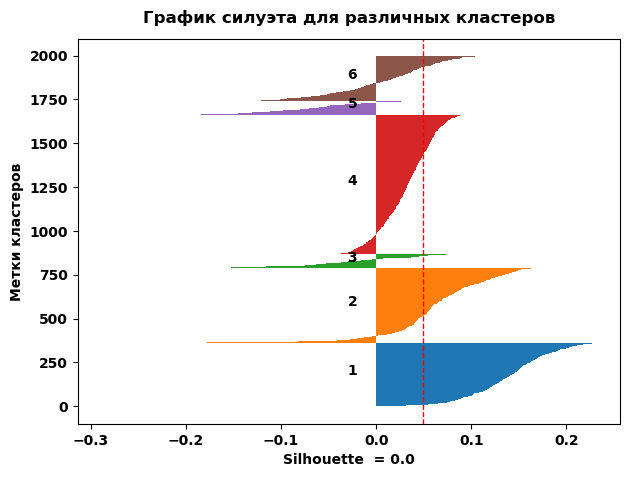

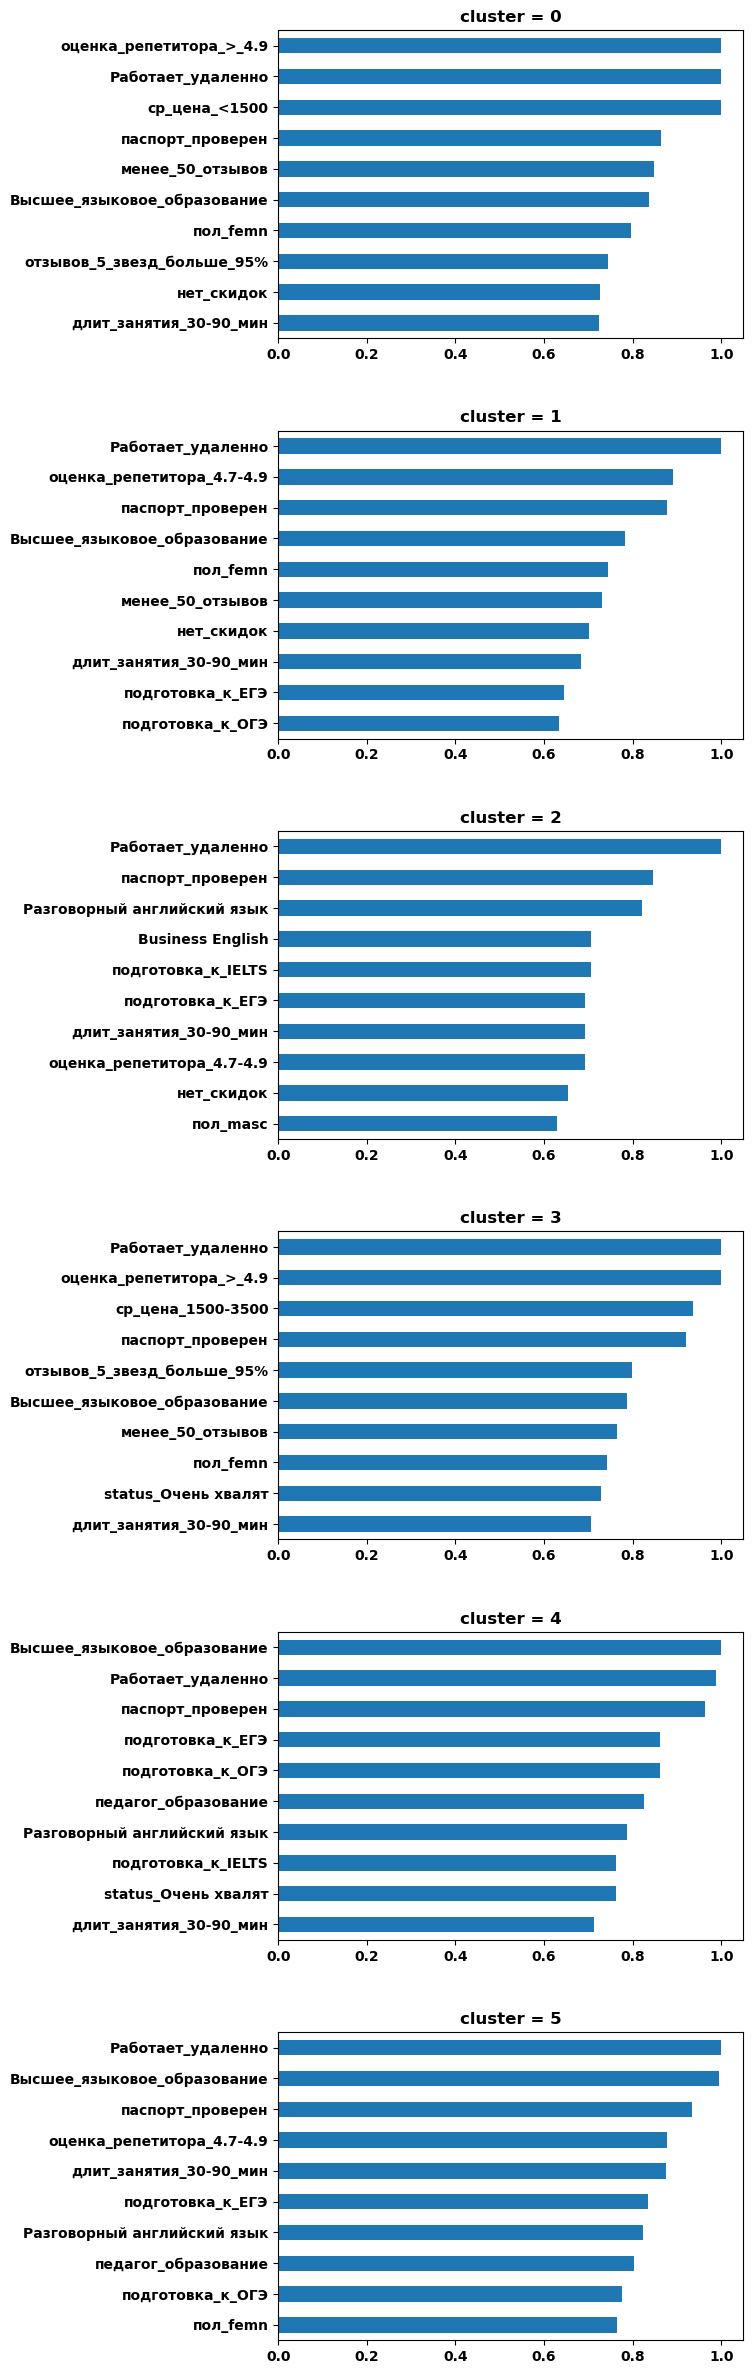

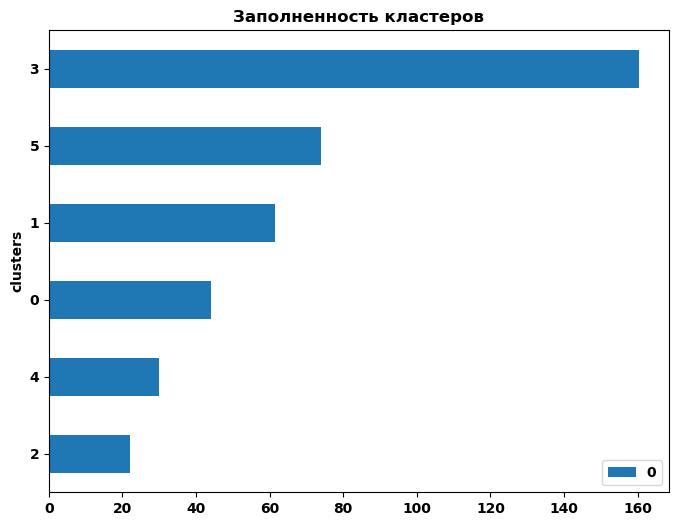

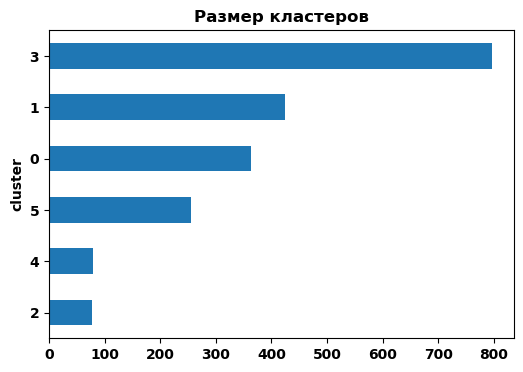

7 clusters
----------------------------------------------------------------------------------------------------


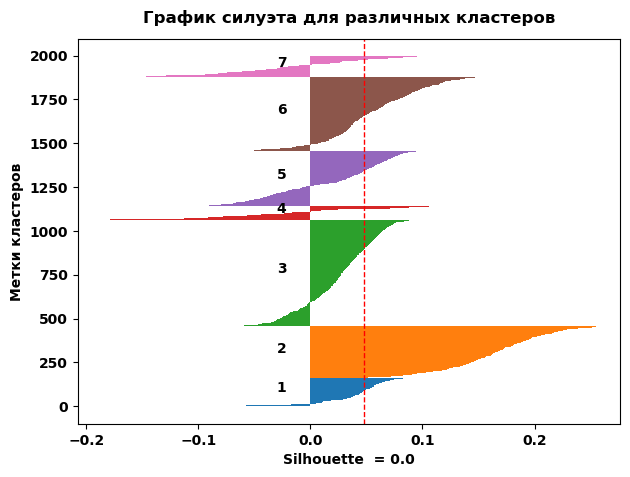

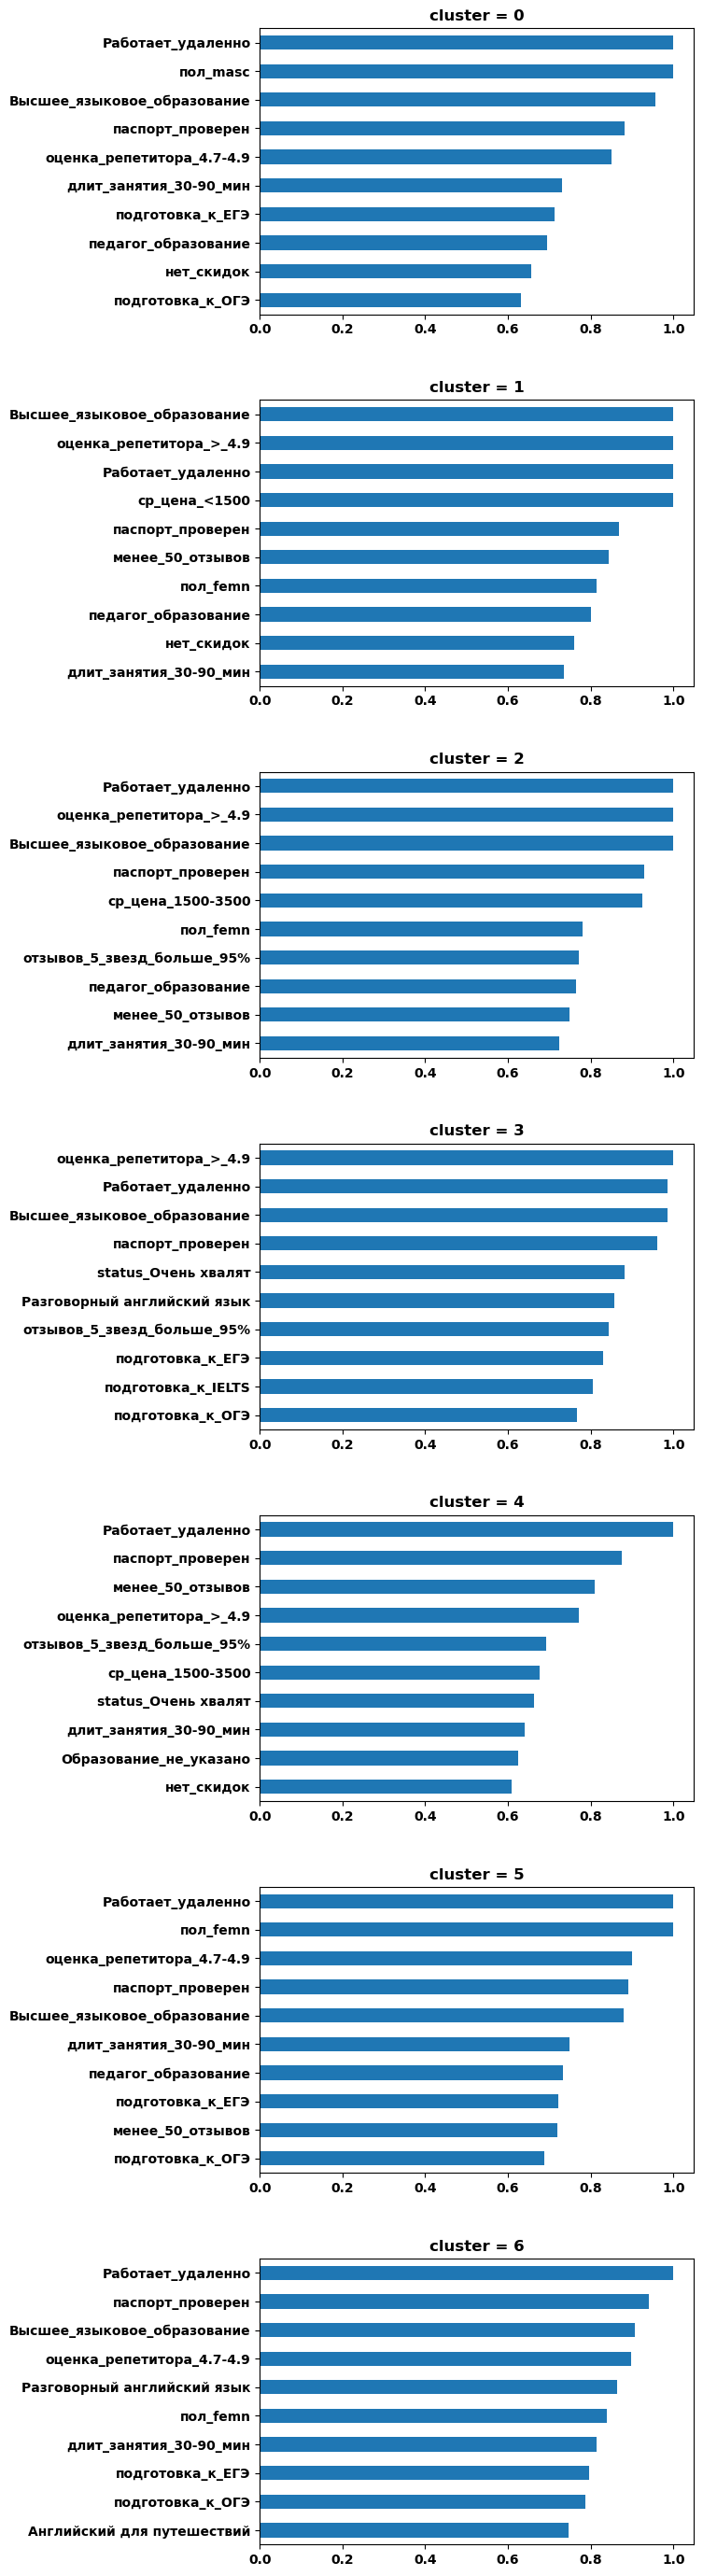

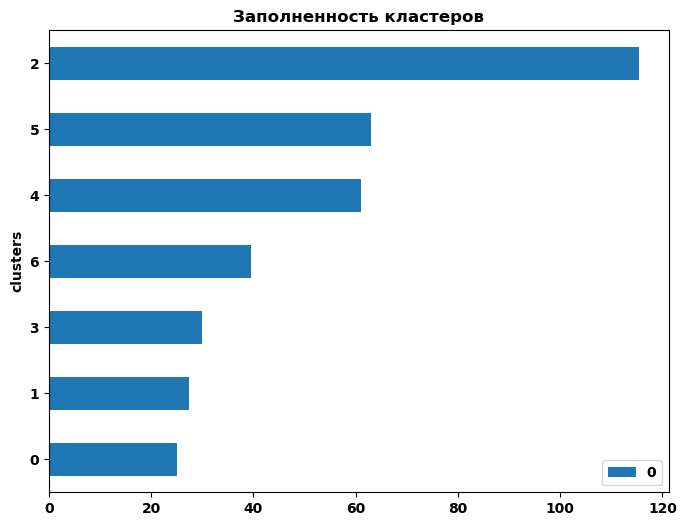

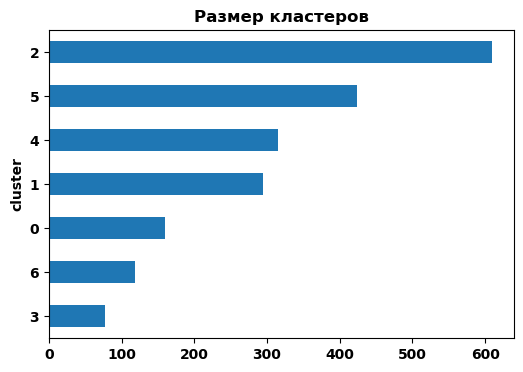

8 clusters
----------------------------------------------------------------------------------------------------


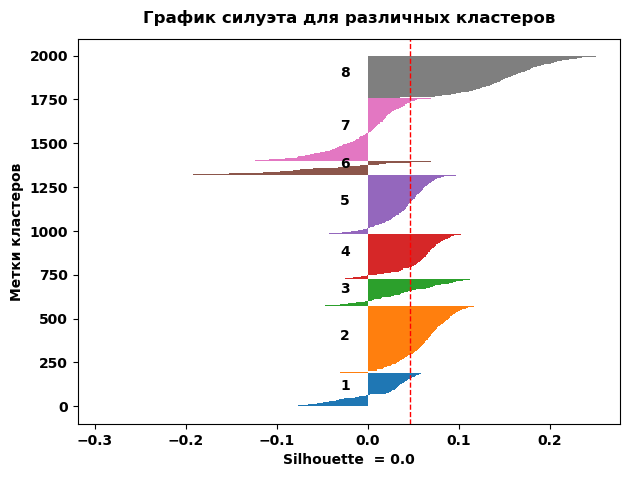

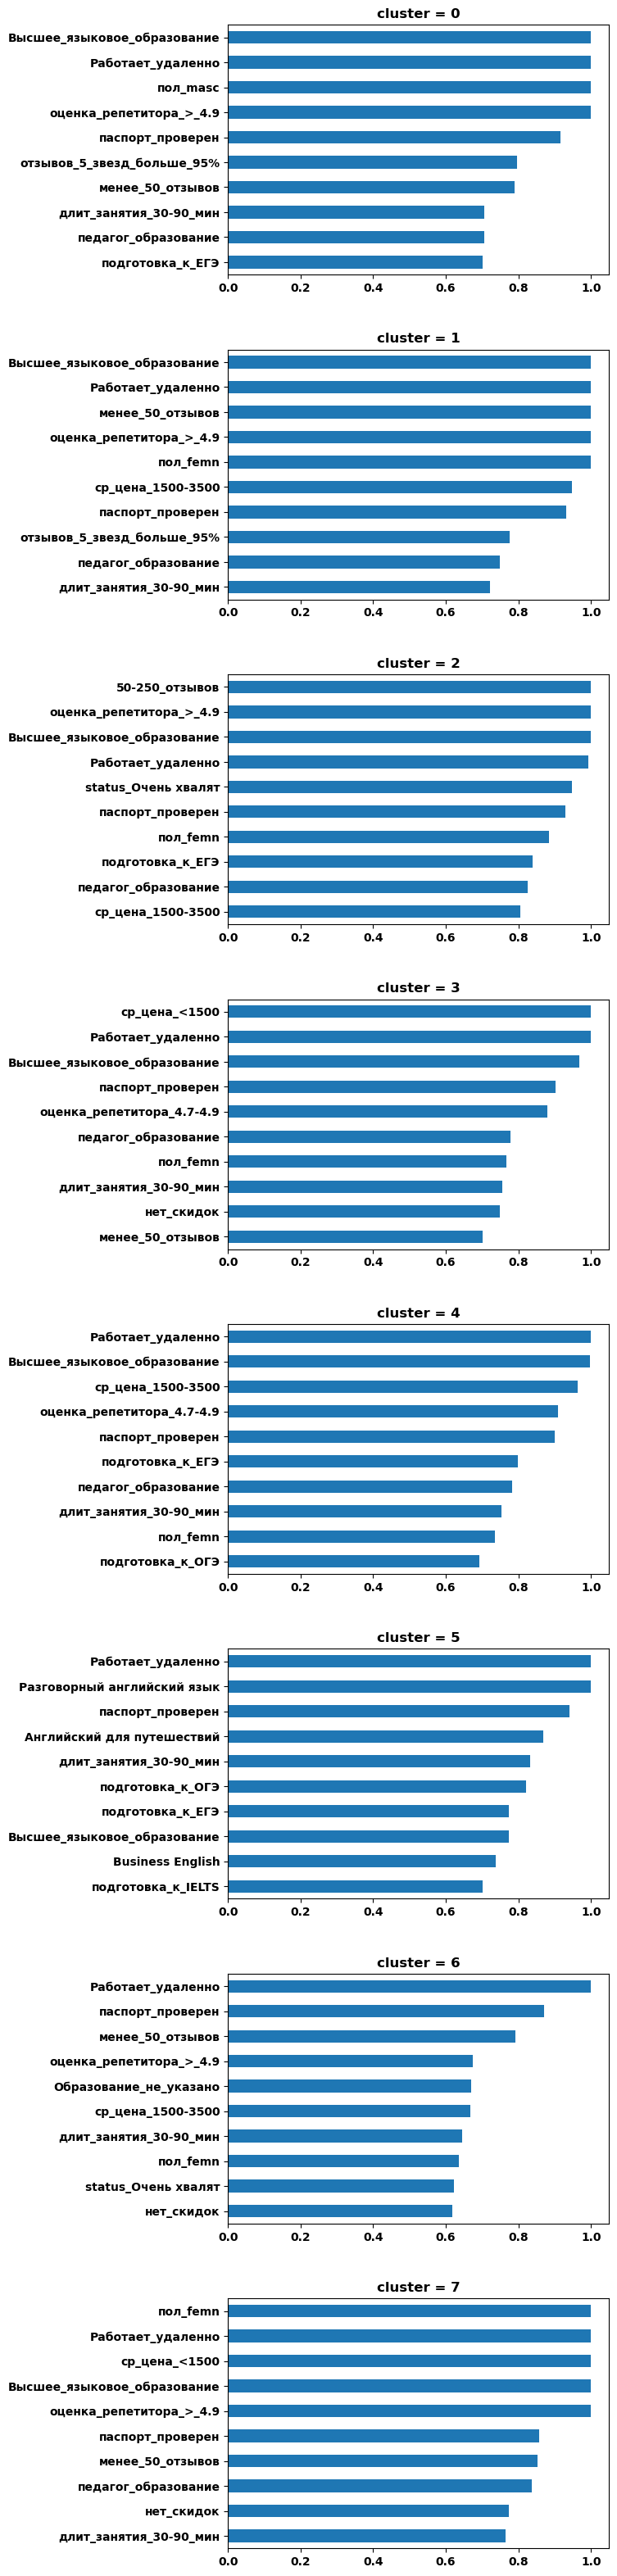

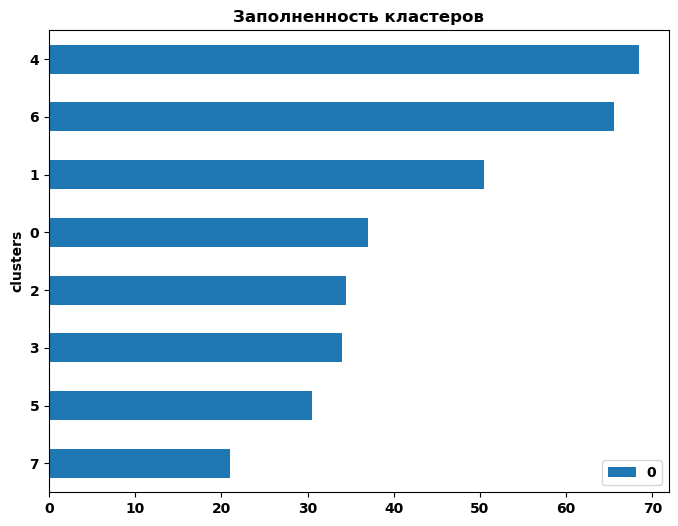

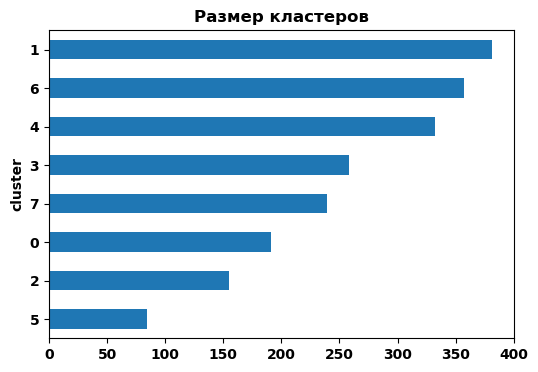

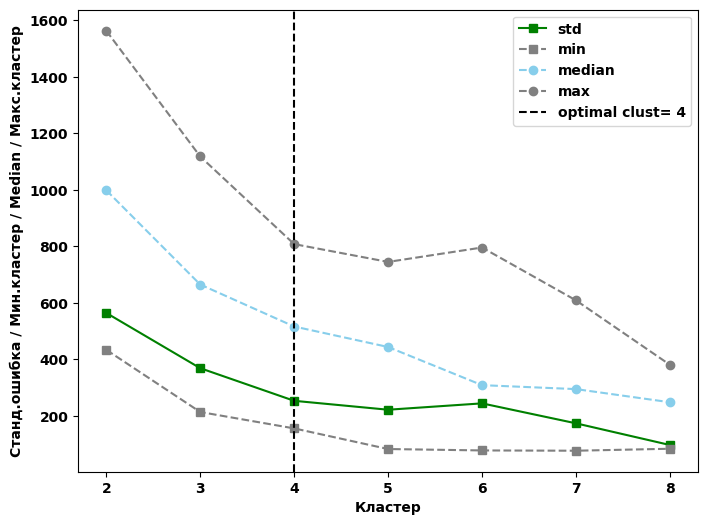

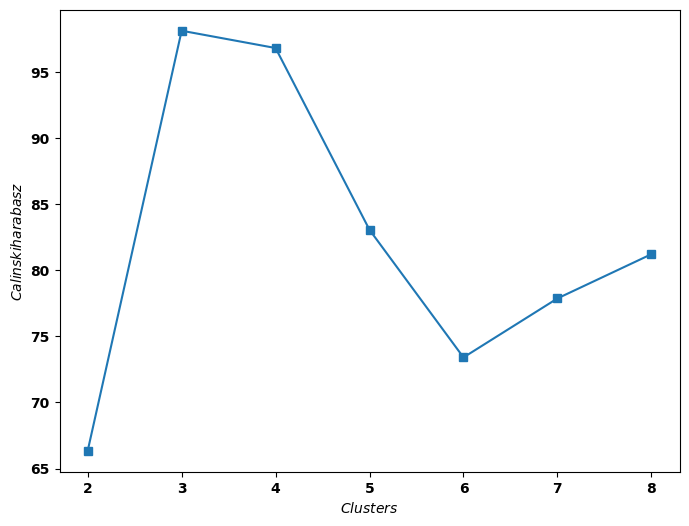

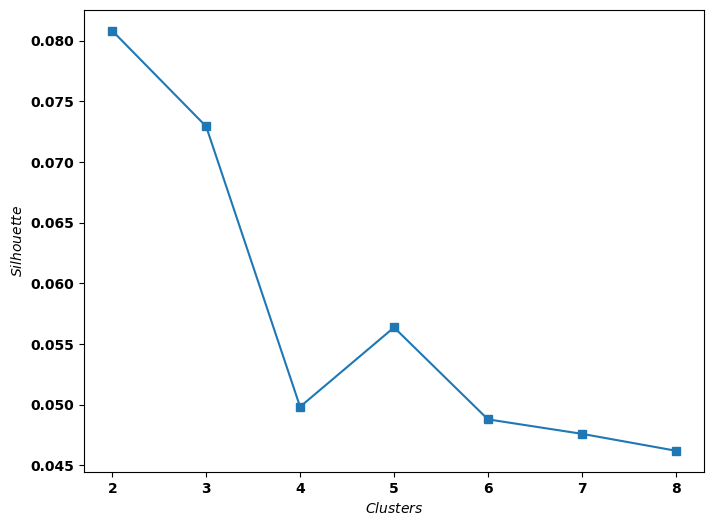

In [43]:
labels_std = []
labels_min = []
labels_max = []
labels_median = []

min_size = 2
max_size = 8
calinski_harabasz = []
silhouette_list = []

for clust in tqdm_notebook(range(min_size, max_size + 1)):
    clf = GaussianMixture(n_components=clust)
    labels = clf.fit_predict(df_cleaned)
    print(clust, 'clusters')
    print('-' * 100)

    silhouette_plot(df_cleaned, labels)
    # топ-признаков
    plot_top_features(df_cleaned, labels, clust)
    # медианная заполненность
    check_fullness(df_cleaned, labels)
    # размер кластеров
    plot_size(df_cleaned, labels)

    calinski_harabasz.append(calinski_harabasz_score(df_cleaned, labels))
    silhouette_list.append(silhouette_score(df_cleaned, labels))
    _, counts = np.unique(labels, return_counts=True)

    labels_std.append(np.std(counts))
    labels_min.append(np.min(counts))
    labels_max.append(np.max(counts))
    labels_median.append(np.median(counts))

elbow_picture(labels_std, labels_min, labels_max, labels_median, labels_median,
              min_size, max_size)
metric_picture(calinski_harabasz,
               min_size,
               max_size,
               name_metric='Calinski harabasz',
               optimal=False)
metric_picture(silhouette_list,
               min_size,
               max_size,
               name_metric='Silhouette',
               optimal=False)

In [41]:
gmm = GaussianMixture(n_components=3)
labels_gmm3 = gmm.fit_predict(df_cleaned)

In [42]:
print(f'silhouette: {silhouette_score(df_cleaned, labels_gmm3)}')
print(f'calinski_harabasz: {calinski_harabasz_score(df_cleaned, labels_gmm3)}')

silhouette: 0.06874379935942487
calinski_harabasz: 127.94888415485705


In [46]:
gmm = GaussianMixture(n_components=4)
labels_gmm4 = gmm.fit_predict(df_cleaned)

In [47]:
print(f'silhouette: {silhouette_score(df_cleaned, labels_gmm4)}')
print(f'calinski_harabasz: {calinski_harabasz_score(df_cleaned, labels_gmm4)}')

silhouette: 0.07278912062850963
calinski_harabasz: 96.93703924497699


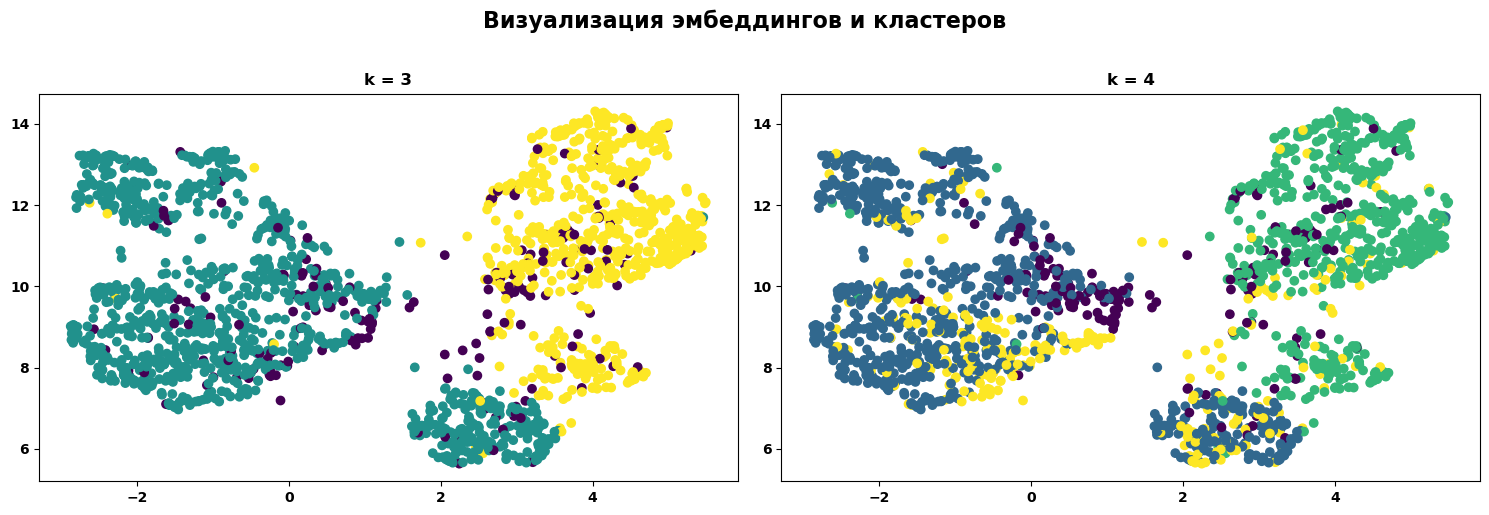

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, k in enumerate([3, 4]):
    gmm = GaussianMixture(n_components=k, random_state=RAND)
    labels = gmm.fit_predict(df_cleaned)

    ax = axes[i]
    ax.scatter(clean_df_embedding[:, 0], clean_df_embedding[:, 1], c=labels)
    ax.set_title(f'k = {k}')

fig.suptitle('Визуализация эмбеддингов и кластеров',
             y=1.02,
             fontsize=16,
             fontweight='bold')
plt.tight_layout()
plt.show()

In [48]:
gmm_final = df_cleaned.assign(target=labels_gmm3)
gmm_final[:4]

Принимает_у_себя  Выезд_к_клиенту  Работает_удаленно  Носитель английского  \
0                 1                1                  1                     1   
1                 0                0                  1                     0   
2                 0                0                  1                     0   
3                 1                0                  1                     0   

   стажировка в США  стажировка в Англии  переводчик  лингвист  \
0                 0                    0           0         0   
1                 0                    0           0         1   
2                 0                    0           1         0   
3                 1                    0           1         1   

   подготовка_к_IELTS  подготовка_к_IELTS_Academic  ...  менее_50_отзывов  \
0                   1                            1  ...                 0   
1                   1                            0  ...                 0   
2                   1                            0  ...                 0   
3                   1                            1  ...                 0   

   ср_цена_1500-3500  ср_цена_<1500  ср_цена_>3500  \
0                  1              0              0   
1                  1              0              0   
2                  1              0              0   
3                  1              0              0   

   уровень_знаний_подтверждён  нет_скидок  паспорт_проверен  \
0                           1           1                 1   
1                           1           1                 1   
2                           1           1                 1   
3                           0           0                 1   

   доля_плохих_отзывов_10%_и_более  отзывов_5_звезд_больше_95%  target  
0                                0                           0       1  
1                                0                           0       0  
2                                0                           1       0  
3                                0                           1       0  

[4 rows x 53 columns]

In [49]:
gmm_final['target'].value_counts()

target
0    1039
2     573
1     385
Name: count, dtype: int64

<Axes: xlabel='target'>

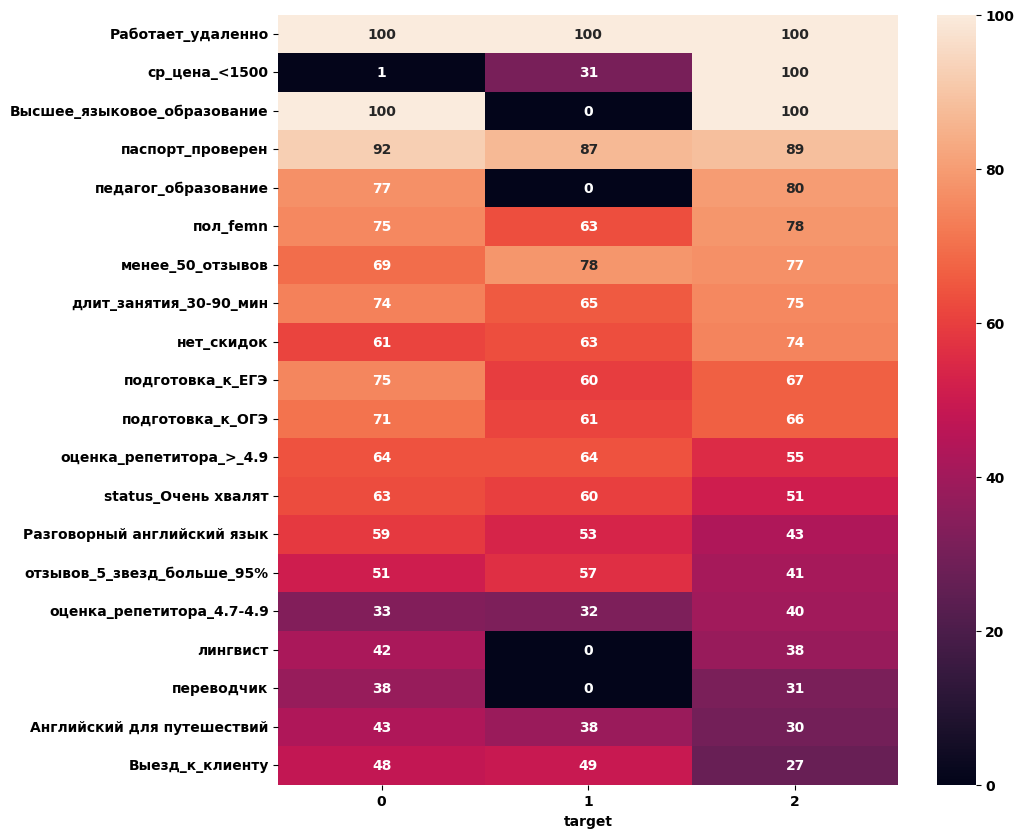

In [51]:
count = gmm_final.groupby('target').count().iloc[:, :1].T.values
normalize = gmm_final.groupby('target').sum().T / count * 100

plt.figure(figsize=(10, 10))

sns.heatmap(normalize.sort_values(by=2, ascending=False)[:20],
            fmt='.0f',
            annot=True)

- кластер 0 - преобладают женщины, все с высшим языковым образованием, отсутствует низкий ценовой сегмент, имеют высокие (в бОльшей степени) и средние оценки, каждый второй работает на выезде (помимо удаленки);
- кластер 1 - преобладают женщины, нет высшего языкового образ-я (или не указано), мало низкого ценового сегмента, имеют высокие (в бОльшей степени) и средние оценки, каждый второй работает на выезде (помимо удаленки), большинство имеет мало отзывов;
- кластер 2 - 2/3 женщины, с высшим языковым образ-ем, мало кто работает на выезде;

# Вывод

**Без подбора параметров ни один алгоритм не разделил на кластеры достаточно хорошо. Хуже всего справился алгоритм спектральной кластеризации.**

- По метрикам лучший результат имеет KMeans (n_clusters=3)
- По конечной интерпретации лучше разделила Аггломеративная класт-я (n_clusters=4)